In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import math  # Import the math module for sqrt and pow

def calculate_iou(box1, box2):
    """Calculates Intersection over Union (IoU) of two bounding boxes."""
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2

    x_intersection_start = max(x1_1, x1_2)
    y_intersection_start = max(y1_1, y1_2)
    x_intersection_end = min(x2_1, x2_2)
    y_intersection_end = min(y2_1, y2_2)

    intersection_area = max(0, x_intersection_end - x_intersection_start) * max(0, y_intersection_end - y_intersection_start)

    box1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
    box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)
    union_area = box1_area + box2_area - intersection_area

    iou = intersection_area / float(union_area) if union_area > 0 else 0
    return iou

def merge_boxes(boxes):
    """Merges a list of bounding boxes into a single bounding box."""
    if not boxes:
        return None

    x1s = [box[0] for box in boxes]
    y1s = [box[1] for box in boxes]
    x2s = [box[2] for box in boxes]
    y2s = [box[3] for box in boxes]

    min_x1 = min(x1s)
    min_y1 = min(y1s)
    max_x2 = max(max(x2s), min_x1 + 1)  # Ensure max_x2 is always greater than min_x1
    max_y2 = max(max(y2s), min_y1 + 1)  # Ensure max_y2 is always greater than min_y1


    return (min_x1, min_y1, max_x2, max_y2)

def calculate_box_center(box):
    """Calculates the center point (x, y) of a bounding box."""
    x1, y1, x2, y2 = box
    center_x = (x1 + x2) // 2
    center_y = (y1 + y2) // 2
    return (center_x, center_y)

def calculate_distance(center1, center2):
    """Calculates the Euclidean distance between two points."""
    x1, y1 = center1
    x2, y2 = center2
    return math.sqrt(pow(x2 - x1, 2) + pow(y2 - y1, 2))


def run_ultralytics_yolov8_object_counting_merged_no_class_filter_with_distance(image_path, model_name='yolov8s.pt', confidence_threshold=0.5, iou_threshold_merge=0.5):
    """
    Runs object detection, merges boxes, prints distances, and returns merged box count.

    Args:
        image_path (str): Path to the input image.
        model_name (str, optional): YOLOv8 model name. Defaults to 'yolov8s.pt'.
        confidence_threshold (float, optional): Confidence threshold. Defaults to 0.5.
        iou_threshold_merge (float, optional): IoU threshold for merging. Defaults to 0.5.

    Returns:
        tuple: (image_with_detections, object_counts_dict, merged_box_count)
               - image_with_detections: OpenCV image with merged bounding boxes.
               - object_counts_dict: Dictionary of object counts.
               - merged_box_count: The number of boxes after merging.
    """

    # 1. Load YOLOv8 Model
    model = YOLO(model_name)

    # 2. Run Inference
    results = model.predict(image_path, conf=confidence_threshold)
    result = results[0]

    # 3. Extract Detections
    boxes = result.boxes.cpu().numpy()
    class_ids = boxes.cls.astype(int)
    confidences = boxes.conf
    xyxy_coords = boxes.xyxy.astype(int)
    class_names = model.names

    # Calculate centers for original boxes
    box_centers = [calculate_box_center(box) for box in xyxy_coords]

    # # Print distances between original boxes
    # print("\nDistances between original bounding box centers:")
    # for i in range(len(xyxy_coords)):
    #     for j in range(i + 1, len(xyxy_coords)): # Avoid duplicate and self-comparisons
    #         distance = calculate_distance(box_centers[i], box_centers[j])
    #         print(f"Box {i} & Box {j}: Distance = {distance:.2f} pixels") # Format distance to 2 decimal places

    # 4. Merge Close Boxes (No Class Filter) - Same merging logic as before
    merged_boxes_coords = []
    merged_class_ids = []
    merged_confidences = []
    processed_indices = set()

    for i in range(len(xyxy_coords)):
        if i in processed_indices:
            continue

        current_box = xyxy_coords[i]
        current_class_id = class_ids[i]
        current_confidence = confidences[i]

        group_boxes = [current_box]
        group_indices = [i]

        for j in range(i + 1, len(xyxy_coords)):
            if j in processed_indices:
                continue

            comparison_box = xyxy_coords[j]
            iou = calculate_iou(current_box, comparison_box)
            if iou > iou_threshold_merge:
                group_boxes.append(comparison_box)
                group_indices.append(j)
                processed_indices.add(j)

        if len(group_boxes) > 1:
            merged_box = merge_boxes(group_boxes)
            merged_boxes_coords.append(merged_box)
            merged_class_ids.append(current_class_id)
            merged_confidences.append(current_confidence)
        else:
            merged_boxes_coords.append(current_box)
            merged_class_ids.append(current_class_id)
            merged_confidences.append(current_confidence)


    # 5. Count Objects and Draw Merged Bounding Boxes
    object_counts = {}
    image = cv2.imread(image_path)

    print(f"\nOriginal boxes count: {len(xyxy_coords)}")
    print(f"Merged boxes count: {len(merged_boxes_coords)}") # Keep this print inside function for debugging
    for i in range(len(merged_boxes_coords)):
        x1, y1, x2, y2 = merged_boxes_coords[i]
        class_id = merged_class_ids[i]
        confidence = merged_confidences[i]
        label = class_names[class_id]
        print("x1: ,y1: ,x2: ,y2: ",x1,y1,x2,y2)
        if label in object_counts:
            object_counts[label] += 1
        else:
            object_counts[label] = 1

        color = (0, 255, 0)
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        # No label text is added now:
        # label_text = f"{label} {confidence:.2f}"
        # cv2.putText(image, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    merged_box_count = len(merged_boxes_coords) # Get the count
    return merged_box_count,image,merged_boxes_coords # Return merged_box_count

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



image 1/1 /content/drive/MyDrive/Chess dataset/test/bq/alpha_data_image23621.jpeg: 640x320 3 vases, 15.4ms
Speed: 3.7ms preprocess, 15.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)

Original boxes count: 3
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  16 0 52 33
x1: ,y1: ,x2: ,y2:  16 46 68 150


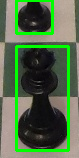

Object Counts:
2


In [ ]:

# --- Install Ultralytics (if you haven't already) ---
# You can uncomment this line to install if you don't have it:
# import subprocess
# subprocess.run(['pip', 'install', 'ultralytics'])

# --- Example Usage ---
image_file = '/content/drive/MyDrive/Chess dataset/test/bq/alpha_data_image23621.jpeg' # Replace with your image file

merged_box_count,output_image,para3 = run_ultralytics_yolov8_object_counting_merged_no_class_filter_with_distance(image_file,confidence_threshold=0.025,iou_threshold_merge=0.1)
#confidence_threshold 0.025
#iou_threshold for first filtering 0.01 delete 48 images
#iou_threshold for second filtering 0.1 delete 0 images
#iou_threshold for third filtering 0.9 delete 0 images
if output_image is not None:
    cv2_imshow(output_image)
    print("Object Counts:")
    print(merged_box_count)

In [ ]:
import os
from tqdm import tqdm
from PIL import Image

def find_images_with_multiple_pieces(dataset_path, count_pieces_function, cropped_dataset_path):
    """
    Scans a chess dataset directory structure to find images with 2 or more chess pieces,
    crops images with less than 2 pieces, and saves them to a new directory structure,
    with a progress bar.

    Args:
        dataset_path (str): Path to the 'Chess dataset' root folder.
        count_pieces_function (function): Function to count chess pieces in an image.
                                          It should return merged_box_count, image, merged_boxes_coords.
        cropped_dataset_path (str): Path to the root folder where cropped images will be saved.

    Returns:
        list: A list of file paths for images containing 2 or more chess pieces.
    """
    image_paths_with_multiple_pieces = []
    dataset_subfolders = ['test', 'train', 'validation']
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']

    total_files = 0
    for subfolder in dataset_subfolders:
        subfolder_path = os.path.join(dataset_path, subfolder)
        if os.path.isdir(subfolder_path):
            for piece_folder in os.listdir(subfolder_path):
                piece_folder_path = os.path.join(subfolder_path, piece_folder)
                if os.path.isdir(piece_folder_path):
                    for filename in os.listdir(piece_folder_path):
                        if any(filename.lower().endswith(ext) for ext in image_extensions):
                            total_files += 1

    with tqdm(total=total_files, desc="Scanning Images") as pbar:
        for subfolder in dataset_subfolders:
            subfolder_path = os.path.join(dataset_path, subfolder)
            if not os.path.isdir(subfolder_path):
                continue

            cropped_subfolder_path = os.path.join(cropped_dataset_path, subfolder) # Path for cropped images in this subfolder
            os.makedirs(cropped_subfolder_path, exist_ok=True) # Create subfolder in cropped dataset if not exists

            for piece_folder in os.listdir(subfolder_path):
                piece_folder_path = os.path.join(subfolder_path, piece_folder)
                if not os.path.isdir(piece_folder_path):
                    continue

                cropped_piece_folder_path = os.path.join(cropped_subfolder_path, piece_folder) # Path for cropped images in this piece folder
                os.makedirs(cropped_piece_folder_path, exist_ok=True) # Create piece folder in cropped dataset if not exists


                for filename in os.listdir(piece_folder_path):
                    if any(filename.lower().endswith(ext) for ext in image_extensions):
                        image_file_path = os.path.join(piece_folder_path, filename)
                        cropped_image_file_path = os.path.join(cropped_piece_folder_path, filename) # Output path for cropped image

                        piece_count, image, merged_boxes_coords = count_pieces_function(image_file_path) # Get count and boxes

                        if piece_count >= 2:
                            image_paths_with_multiple_pieces.append(image_file_path)
                        elif piece_count < 2: # Crop and save if less than 2 pieces
                            try:
                                original_image = Image.open(image_file_path)
                                if piece_count == 1 and merged_boxes_coords: # Crop if 1 piece and bounding box available
                                    box = merged_boxes_coords[0] # Assuming merged_boxes_coords is a list of boxes
                                    cropped_image = original_image.crop(box)
                                    cropped_image.save(cropped_image_file_path) # Save cropped image
                                    print('Saved to ',cropped_image_file_path)
                                elif piece_count == 0: # If no piece, save original image to cropped folder (or you can skip it)
                                    original_image.save(cropped_image_file_path) # Save original image as is
                                original_image.close() # Close original image in both cases

                            except Exception as e:
                                print(f"Error processing {image_file_path}: {e}")

                        pbar.update(1)

    return image_paths_with_multiple_pieces

In [ ]:
dataset_root_path = '/content/drive/MyDrive/Chess dataset'
new_dataset_root_path = '/content/'
images_with_multiple_pieces_paths = find_images_with_multiple_pieces(dataset_root_path, run_ultralytics_yolov8_object_counting_merged_no_class_filter_with_distance,new_dataset_root_path)

print("\nImages with 2 or more chess pieces:")
for path in images_with_multiple_pieces_paths:
    print(path)

Scanning Images:   0%|          | 0/2406 [00:00<?, ?it/s]


image 1/1 /content/drive/MyDrive/Chess dataset/test/wk/alpha_data_image23765.jpeg: 640x352 (no detections), 15.3ms
Speed: 1.9ms preprocess, 15.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   0%|          | 1/2406 [00:00<10:07,  3.96it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wk/alpha_data_image22613.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   0%|          | 2/2406 [00:00<10:21,  3.87it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wk/data_image3227.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.7ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   0%|          | 3/2406 [00:00<10:05,  3.97it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wk/alpha_data_image10220.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   0%|          | 4/2406 [00:01<09:55,  4.03it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wk/data_image3528.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   0%|          | 5/2406 [00:01<09:55,  4.03it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wk/alpha_data_image22014.jpeg: 640x320 2 donuts, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   0%|          | 6/2406 [00:01<10:02,  3.98it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  24 82 68 112
x1: ,y1: ,x2: ,y2:  21 45 66 90

image 1/1 /content/drive/MyDrive/Chess dataset/test/wk/alpha_data_image10436.jpeg: 640x352 (no detections), 13.3ms
Speed: 1.4ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   0%|          | 7/2406 [00:01<09:59,  4.00it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wk/data_image710.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   0%|          | 8/2406 [00:02<10:00,  3.99it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wk/data_image4377.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   0%|          | 9/2406 [00:02<09:54,  4.03it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wk/data_image3725.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   0%|          | 10/2406 [00:02<10:02,  3.98it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wk/alpha_data_image11045.jpeg: 640x320 (no detections), 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   0%|          | 11/2406 [00:02<09:59,  3.99it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wn/alpha_data_image11610.jpeg: 640x352 1 cat, 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   0%|          | 12/2406 [00:03<10:01,  3.98it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 81 75 155
Saved to  /content/test/wn/alpha_data_image11610.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/wn/alpha_data_image11190.jpeg: 640x320 1 toilet, 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   1%|          | 13/2406 [00:03<09:59,  3.99it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  19 35 66 98
Saved to  /content/test/wn/alpha_data_image11190.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/wn/data_image3721.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   1%|          | 14/2406 [00:03<10:03,  3.97it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wn/data_image3682.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   1%|          | 15/2406 [00:03<09:57,  4.00it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wn/data_image2881.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   1%|          | 16/2406 [00:04<09:57,  4.00it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wn/alpha_data_image10604.jpeg: 640x320 1 person, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   1%|          | 17/2406 [00:04<13:15,  3.00it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 23 50 134
Saved to  /content/test/wn/alpha_data_image10604.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/wn/data_image1558.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   1%|          | 18/2406 [00:04<12:23,  3.21it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wn/alpha_data_image24051.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   1%|          | 19/2406 [00:05<11:37,  3.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wn/alpha_data_image20996.jpeg: 640x320 (no detections), 11.2ms
Speed: 2.0ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   1%|          | 20/2406 [00:05<11:06,  3.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wn/alpha_data_image23111.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   1%|          | 21/2406 [00:05<11:21,  3.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wn/alpha_data_image10213.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   1%|          | 22/2406 [00:05<10:58,  3.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wn/alpha_data_image20290.jpeg: 640x320 (no detections), 13.1ms
Speed: 1.5ms preprocess, 13.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   1%|          | 23/2406 [00:06<10:47,  3.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wn/data_image2143.jpeg: 640x352 1 teddy bear, 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   1%|          | 24/2406 [00:06<10:54,  3.64it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 10 63 112
Saved to  /content/test/wn/data_image2143.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/wn/data_image3512.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   1%|          | 25/2406 [00:06<10:48,  3.67it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wn/alpha_data_image12482.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   1%|          | 26/2406 [00:06<11:08,  3.56it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wn/alpha_data_image21631.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   1%|          | 27/2406 [00:07<10:49,  3.66it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wn/data_image3372.jpeg: 640x352 1 teddy bear, 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   1%|          | 28/2406 [00:07<10:40,  3.71it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 1 58 70
Saved to  /content/test/wn/data_image3372.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/wn/data_image4559.jpeg: 640x320 1 orange, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   1%|          | 29/2406 [00:07<12:01,  3.30it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 99 67 166
Saved to  /content/test/wn/data_image4559.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/wn/data_image450.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   1%|          | 30/2406 [00:08<12:43,  3.11it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wn/alpha_data_image10897.jpeg: 640x320 (no detections), 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   1%|▏         | 31/2406 [00:08<13:15,  2.99it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/br/alpha_data_image23667.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   1%|▏         | 32/2406 [00:08<13:51,  2.86it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/br/alpha_data_image11119.jpeg: 640x352 (no detections), 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   1%|▏         | 33/2406 [00:09<14:13,  2.78it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/br/alpha_data_image10624.jpeg: 640x320 (no detections), 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   1%|▏         | 34/2406 [00:09<14:25,  2.74it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/br/data_image3111.jpeg: 640x320 1 vase, 1 teddy bear, 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   1%|▏         | 35/2406 [00:10<14:41,  2.69it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  35 66 73 135
x1: ,y1: ,x2: ,y2:  27 0 70 24

image 1/1 /content/drive/MyDrive/Chess dataset/test/br/alpha_data_image12771.jpeg: 640x320 (no detections), 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   1%|▏         | 36/2406 [00:10<14:52,  2.66it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/br/data_image4178.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   2%|▏         | 37/2406 [00:10<13:52,  2.84it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/br/alpha_data_image24281.jpeg: 640x352 1 dog, 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   2%|▏         | 38/2406 [00:11<12:45,  3.09it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  7 52 62 128
Saved to  /content/test/br/alpha_data_image24281.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/br/alpha_data_image12509.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   2%|▏         | 39/2406 [00:11<11:57,  3.30it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  20 66 63 134
Saved to  /content/test/br/alpha_data_image12509.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/br/alpha_data_image20853.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   2%|▏         | 40/2406 [00:11<11:35,  3.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/br/alpha_data_image10877.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   2%|▏         | 41/2406 [00:11<11:19,  3.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/br/data_image1879.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   2%|▏         | 42/2406 [00:12<10:58,  3.59it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/br/data_image1985.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   2%|▏         | 43/2406 [00:12<10:42,  3.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/br/alpha_data_image12623.jpeg: 640x352 1 person, 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   2%|▏         | 44/2406 [00:12<10:31,  3.74it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  15 52 52 116
Saved to  /content/test/br/alpha_data_image12623.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/br/data_image4274.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   2%|▏         | 45/2406 [00:12<10:36,  3.71it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/br/alpha_data_image21366.jpeg: 640x320 1 teddy bear, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   2%|▏         | 46/2406 [00:13<10:28,  3.75it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  32 88 86 170
Saved to  /content/test/br/alpha_data_image21366.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/br/alpha_data_image12629.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   2%|▏         | 47/2406 [00:13<10:21,  3.80it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/br/data_image1509.jpeg: 640x320 1 teddy bear, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   2%|▏         | 48/2406 [00:13<10:14,  3.84it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 67 54 135
Saved to  /content/test/br/data_image1509.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/br/data_image3595.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   2%|▏         | 49/2406 [00:13<10:21,  3.79it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wr/alpha_data_image10438.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   2%|▏         | 50/2406 [00:14<10:20,  3.80it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wr/alpha_data_image11226.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   2%|▏         | 51/2406 [00:14<10:19,  3.80it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wr/alpha_data_image12117.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   2%|▏         | 52/2406 [00:14<10:12,  3.84it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wr/alpha_data_image12639.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   2%|▏         | 53/2406 [00:15<13:09,  2.98it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wr/alpha_data_image21935.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   2%|▏         | 54/2406 [00:15<12:09,  3.22it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wr/alpha_data_image11928.jpeg: 640x320 (no detections), 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   2%|▏         | 55/2406 [00:15<11:26,  3.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wr/data_image2606.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   2%|▏         | 56/2406 [00:16<11:13,  3.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wr/alpha_data_image22191.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   2%|▏         | 57/2406 [00:16<10:51,  3.61it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wr/alpha_data_image10602.jpeg: 640x320 1 person, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   2%|▏         | 58/2406 [00:16<10:45,  3.64it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 20 43 133
Saved to  /content/test/wr/alpha_data_image10602.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/wr/alpha_data_image12418.jpeg: 640x352 1 toilet, 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   2%|▏         | 59/2406 [00:16<10:34,  3.70it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  5 49 40 105
Saved to  /content/test/wr/alpha_data_image12418.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/wr/data_image2723.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   2%|▏         | 60/2406 [00:17<10:26,  3.75it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wr/data_image2803.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   3%|▎         | 61/2406 [00:17<10:23,  3.76it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wr/alpha_data_image22919.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   3%|▎         | 62/2406 [00:17<10:11,  3.83it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  5 61 61 144
Saved to  /content/test/wr/alpha_data_image22919.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/wr/alpha_data_image20654.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   3%|▎         | 63/2406 [00:17<10:08,  3.85it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wr/data_image1163.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   3%|▎         | 64/2406 [00:18<10:08,  3.85it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wr/data_image2041.jpeg: 640x320 1 fire hydrant, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   3%|▎         | 65/2406 [00:18<10:02,  3.88it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 57 58 127
Saved to  /content/test/wr/data_image2041.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/wr/alpha_data_image12813.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   3%|▎         | 66/2406 [00:18<09:58,  3.91it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wr/data_image907.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   3%|▎         | 67/2406 [00:18<09:58,  3.91it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wr/alpha_data_image10811.jpeg: 640x352 1 person, 1 toilet, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   3%|▎         | 68/2406 [00:19<10:05,  3.86it/s]


Original boxes count: 2
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 22 52 116
Saved to  /content/test/wr/alpha_data_image10811.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/wr/data_image257.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.4ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   3%|▎         | 69/2406 [00:19<10:01,  3.89it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wr/data_image2236.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   3%|▎         | 70/2406 [00:19<09:59,  3.90it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bn/alpha_data_image21740.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   3%|▎         | 71/2406 [00:19<10:04,  3.86it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bn/data_image3497.jpeg: 640x320 1 dog, 11.3ms
Speed: 1.7ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   3%|▎         | 72/2406 [00:20<10:09,  3.83it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 64 62 142
Saved to  /content/test/bn/data_image3497.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bn/alpha_data_image10096.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   3%|▎         | 73/2406 [00:20<10:05,  3.85it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bn/alpha_data_image10387.jpeg: 640x320 1 cat, 12.6ms
Speed: 3.3ms preprocess, 12.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   3%|▎         | 74/2406 [00:20<10:18,  3.77it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 16 64 84
Saved to  /content/test/bn/alpha_data_image10387.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bn/data_image4643.jpeg: 640x320 1 dog, 11.6ms
Speed: 2.9ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   3%|▎         | 75/2406 [00:21<11:42,  3.32it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 67 63 141
Saved to  /content/test/bn/data_image4643.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bn/alpha_data_image12350.jpeg: 640x352 1 vase, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   3%|▎         | 76/2406 [00:21<12:29,  3.11it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  15 42 50 108
Saved to  /content/test/bn/alpha_data_image12350.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bn/alpha_data_image22250.jpeg: 640x320 1 cat, 12.9ms
Speed: 2.1ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   3%|▎         | 77/2406 [00:21<13:01,  2.98it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 81 83 162
Saved to  /content/test/bn/alpha_data_image22250.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bn/alpha_data_image11086.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   3%|▎         | 78/2406 [00:22<13:34,  2.86it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bn/data_image3443.jpeg: 640x320 1 vase, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   3%|▎         | 79/2406 [00:22<13:41,  2.83it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  6 42 45 112
Saved to  /content/test/bn/data_image3443.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bn/alpha_data_image23814.jpeg: 640x320 1 vase, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   3%|▎         | 80/2406 [00:22<13:46,  2.81it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 72 64 151
Saved to  /content/test/bn/alpha_data_image23814.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bn/data_image2794.jpeg: 640x352 1 donut, 12.1ms
Speed: 2.4ms preprocess, 12.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   3%|▎         | 81/2406 [00:23<14:02,  2.76it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  2 0 41 14
Saved to  /content/test/bn/data_image2794.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bn/alpha_data_image20842.jpeg: 640x320 (no detections), 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   3%|▎         | 82/2406 [00:23<14:14,  2.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bn/data_image4343.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   3%|▎         | 83/2406 [00:23<13:10,  2.94it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  4 48 50 115
Saved to  /content/test/bn/data_image4343.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bn/alpha_data_image22727.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   3%|▎         | 84/2406 [00:24<12:25,  3.12it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  24 76 80 157
Saved to  /content/test/bn/alpha_data_image22727.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bn/alpha_data_image23199.jpeg: 640x320 1 bottle, 1 vase, 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   4%|▎         | 85/2406 [00:24<11:36,  3.33it/s]


Original boxes count: 2
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  22 43 62 128
Saved to  /content/test/bn/alpha_data_image23199.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bn/data_image2698.jpeg: 640x352 1 cat, 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   4%|▎         | 86/2406 [00:24<10:58,  3.52it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  3 91 64 148
Saved to  /content/test/bn/data_image2698.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bn/data_image2665.jpeg: 640x352 1 dog, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   4%|▎         | 87/2406 [00:24<10:43,  3.60it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  27 57 71 122
Saved to  /content/test/bn/data_image2665.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/wp/data_image2278.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   4%|▎         | 88/2406 [00:25<10:29,  3.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wp/data_image3978.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   4%|▎         | 89/2406 [00:25<10:14,  3.77it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wp/alpha_data_image20822.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   4%|▎         | 90/2406 [00:25<10:03,  3.84it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wp/data_image4262.jpeg: 640x320 1 teddy bear, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   4%|▍         | 91/2406 [00:25<09:59,  3.86it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  19 78 58 133
Saved to  /content/test/wp/data_image4262.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/wp/data_image459.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   4%|▍         | 92/2406 [00:26<09:58,  3.87it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wp/alpha_data_image21012.jpeg: 640x352 1 donut, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   4%|▍         | 93/2406 [00:26<09:51,  3.91it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 96 48 129
Saved to  /content/test/wp/alpha_data_image21012.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/wp/alpha_data_image20292.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   4%|▍         | 94/2406 [00:26<09:58,  3.86it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wp/alpha_data_image22019.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   4%|▍         | 95/2406 [00:27<12:49,  3.00it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wp/alpha_data_image12798.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   4%|▍         | 96/2406 [00:27<11:49,  3.25it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wp/data_image4374.jpeg: 640x320 (no detections), 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   4%|▍         | 97/2406 [00:27<11:09,  3.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wp/data_image3258.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   4%|▍         | 98/2406 [00:28<10:37,  3.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wp/alpha_data_image12815.jpeg: 640x352 (no detections), 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   4%|▍         | 99/2406 [00:28<10:23,  3.70it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wp/data_image1802.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   4%|▍         | 100/2406 [00:28<10:10,  3.77it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wp/data_image968.jpeg: 640x352 1 donut, 11.9ms
Speed: 1.7ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   4%|▍         | 101/2406 [00:28<10:02,  3.83it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  25 123 76 173
Saved to  /content/test/wp/data_image968.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/wp/data_image765.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.7ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   4%|▍         | 102/2406 [00:29<09:57,  3.86it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wp/data_image3132.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   4%|▍         | 103/2406 [00:29<09:50,  3.90it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wp/data_image2986.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   4%|▍         | 104/2406 [00:29<09:50,  3.90it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wp/data_image3820.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   4%|▍         | 105/2406 [00:29<09:55,  3.87it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wp/data_image16.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   4%|▍         | 106/2406 [00:30<09:58,  3.84it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wb/data_image3942.jpeg: 640x320 (no detections), 14.0ms
Speed: 1.8ms preprocess, 14.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   4%|▍         | 107/2406 [00:30<10:03,  3.81it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wb/alpha_data_image20980.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   4%|▍         | 108/2406 [00:30<09:55,  3.86it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wb/data_image975.jpeg: 640x352 1 donut, 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   5%|▍         | 109/2406 [00:30<09:54,  3.86it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  15 57 61 109
Saved to  /content/test/wb/data_image975.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/wb/alpha_data_image10515.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   5%|▍         | 110/2406 [00:31<09:46,  3.92it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wb/alpha_data_image10075.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   5%|▍         | 111/2406 [00:31<09:47,  3.90it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wb/alpha_data_image21261.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   5%|▍         | 112/2406 [00:31<09:49,  3.89it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wb/alpha_data_image11767.jpeg: 640x320 (no detections), 13.3ms
Speed: 1.3ms preprocess, 13.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   5%|▍         | 113/2406 [00:31<09:52,  3.87it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wb/data_image2061.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   5%|▍         | 114/2406 [00:32<09:47,  3.90it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wb/data_image3663.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   5%|▍         | 115/2406 [00:32<09:49,  3.89it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wb/data_image2994.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   5%|▍         | 116/2406 [00:32<09:46,  3.90it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wb/data_image2398.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   5%|▍         | 117/2406 [00:32<09:49,  3.89it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wb/alpha_data_image20717.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   5%|▍         | 118/2406 [00:33<09:46,  3.90it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wb/alpha_data_image11235.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   5%|▍         | 119/2406 [00:33<09:43,  3.92it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wb/data_image1556.jpeg: 640x320 1 teddy bear, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   5%|▍         | 120/2406 [00:33<09:47,  3.89it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  20 91 67 155
Saved to  /content/test/wb/data_image1556.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/wb/alpha_data_image11559.jpeg: 640x352 (no detections), 13.7ms
Speed: 2.2ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   5%|▌         | 121/2406 [00:34<11:03,  3.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wb/alpha_data_image10606.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   5%|▌         | 122/2406 [00:34<12:03,  3.16it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wb/data_image2437.jpeg: 640x352 (no detections), 12.4ms
Speed: 3.4ms preprocess, 12.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   5%|▌         | 123/2406 [00:34<12:50,  2.96it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wb/alpha_data_image11759.jpeg: 640x352 (no detections), 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   5%|▌         | 124/2406 [00:35<13:24,  2.84it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wb/alpha_data_image22221.jpeg: 640x320 1 teddy bear, 16.8ms
Speed: 2.2ms preprocess, 16.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   5%|▌         | 125/2406 [00:35<13:46,  2.76it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 42 64 129
Saved to  /content/test/wb/alpha_data_image22221.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/wb/alpha_data_image22924.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   5%|▌         | 126/2406 [00:35<13:55,  2.73it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wb/alpha_data_image20165.jpeg: 640x320 (no detections), 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   5%|▌         | 127/2406 [00:36<14:06,  2.69it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wq/data_image2868.jpeg: 640x320 (no detections), 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   5%|▌         | 128/2406 [00:36<14:32,  2.61it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wq/alpha_data_image21067.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   5%|▌         | 129/2406 [00:37<14:27,  2.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wq/alpha_data_image23283.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   5%|▌         | 130/2406 [00:37<13:07,  2.89it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wq/alpha_data_image21963.jpeg: 640x320 (no detections), 12.6ms
Speed: 2.2ms preprocess, 12.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   5%|▌         | 131/2406 [00:37<12:09,  3.12it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wq/data_image1161.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   5%|▌         | 132/2406 [00:37<11:36,  3.27it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wq/data_image2810.jpeg: 640x320 2 toilets, 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   6%|▌         | 133/2406 [00:38<11:06,  3.41it/s]


Original boxes count: 2
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 15 62 112
Saved to  /content/test/wq/data_image2810.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/wq/alpha_data_image11391.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   6%|▌         | 134/2406 [00:38<11:01,  3.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wq/data_image3114.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   6%|▌         | 135/2406 [00:38<10:45,  3.52it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wq/alpha_data_image11628.jpeg: 640x352 2 vases, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   6%|▌         | 136/2406 [00:38<10:31,  3.60it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  18 46 66 132
x1: ,y1: ,x2: ,y2:  12 0 45 35

image 1/1 /content/drive/MyDrive/Chess dataset/test/wq/alpha_data_image24068.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   6%|▌         | 137/2406 [00:39<10:17,  3.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wq/alpha_data_image22147.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   6%|▌         | 138/2406 [00:39<10:08,  3.73it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wq/alpha_data_image10287.jpeg: 640x352 1 teddy bear, 11.9ms
Speed: 1.7ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   6%|▌         | 139/2406 [00:39<10:09,  3.72it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 0 71 86
Saved to  /content/test/wq/alpha_data_image10287.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/wq/alpha_data_image12406.jpeg: 640x352 1 vase, 13.3ms
Speed: 1.9ms preprocess, 13.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   6%|▌         | 140/2406 [00:40<10:06,  3.74it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  25 0 58 47
Saved to  /content/test/wq/alpha_data_image12406.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/wq/data_image3498.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   6%|▌         | 141/2406 [00:40<10:06,  3.73it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wq/alpha_data_image10933.jpeg: 640x352 1 vase, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   6%|▌         | 142/2406 [00:40<10:06,  3.73it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  7 59 55 137
Saved to  /content/test/wq/alpha_data_image10933.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/wq/data_image2123.jpeg: 640x320 1 teddy bear, 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   6%|▌         | 143/2406 [00:40<10:16,  3.67it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  3 0 63 133
Saved to  /content/test/wq/data_image2123.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/wq/alpha_data_image10592.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   6%|▌         | 144/2406 [00:41<10:06,  3.73it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wq/alpha_data_image12526.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   6%|▌         | 145/2406 [00:41<12:45,  2.95it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/wq/data_image3914.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   6%|▌         | 146/2406 [00:41<11:57,  3.15it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bq/alpha_data_image10677.jpeg: 640x352 1 vase, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   6%|▌         | 147/2406 [00:42<11:16,  3.34it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  7 0 35 46
Saved to  /content/test/bq/alpha_data_image10677.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bq/alpha_data_image23933.jpeg: 640x352 1 vase, 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   6%|▌         | 148/2406 [00:42<10:43,  3.51it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  15 32 67 135
Saved to  /content/test/bq/alpha_data_image23933.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bq/data_image4255.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   6%|▌         | 149/2406 [00:42<10:20,  3.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bq/alpha_data_image22405.jpeg: 640x352 2 vases, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   6%|▌         | 150/2406 [00:42<10:15,  3.66it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  17 0 54 35
x1: ,y1: ,x2: ,y2:  14 40 66 143

image 1/1 /content/drive/MyDrive/Chess dataset/test/bq/alpha_data_image11126.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   6%|▋         | 151/2406 [00:43<10:10,  3.69it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bq/data_image201.jpeg: 640x320 1 dog, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   6%|▋         | 152/2406 [00:43<09:57,  3.78it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 61 82 146
Saved to  /content/test/bq/data_image201.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bq/alpha_data_image21187.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   6%|▋         | 153/2406 [00:43<09:47,  3.84it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bq/data_image1527.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   6%|▋         | 154/2406 [00:43<09:53,  3.80it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bq/alpha_data_image21510.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   6%|▋         | 155/2406 [00:44<09:45,  3.85it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bq/alpha_data_image11894.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   6%|▋         | 156/2406 [00:44<09:39,  3.88it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bq/data_image2993.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   7%|▋         | 157/2406 [00:44<09:35,  3.91it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bq/alpha_data_image23374.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   7%|▋         | 158/2406 [00:44<09:45,  3.84it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 32 62 135
Saved to  /content/test/bq/alpha_data_image23374.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bq/data_image2718.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   7%|▋         | 159/2406 [00:45<09:43,  3.85it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bq/data_image2212.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   7%|▋         | 160/2406 [00:45<09:42,  3.86it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bq/alpha_data_image21770.jpeg: 640x320 1 fire hydrant, 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   7%|▋         | 161/2406 [00:45<09:40,  3.87it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  8 41 74 146
Saved to  /content/test/bq/alpha_data_image21770.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bq/alpha_data_image10308.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   7%|▋         | 162/2406 [00:46<09:50,  3.80it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bq/alpha_data_image23621.jpeg: 640x320 2 vases, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   7%|▋         | 163/2406 [00:46<09:45,  3.83it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  16 0 52 33
x1: ,y1: ,x2: ,y2:  16 46 68 149

image 1/1 /content/drive/MyDrive/Chess dataset/test/bq/alpha_data_image20885.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   7%|▋         | 164/2406 [00:46<09:41,  3.86it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 30 64 131
Saved to  /content/test/bq/alpha_data_image20885.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/empty/alpha_data_image20198.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   7%|▋         | 165/2406 [00:46<09:37,  3.88it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/empty/alpha_data_image20070.jpeg: 640x320 (no detections), 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   7%|▋         | 166/2406 [00:47<10:01,  3.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/empty/data_image412.jpeg: 640x320 1 teddy bear, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   7%|▋         | 167/2406 [00:47<11:16,  3.31it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 2 55 71
Saved to  /content/test/empty/data_image412.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/empty/data_image170.jpeg: 640x320 1 person, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   7%|▋         | 168/2406 [00:47<11:51,  3.14it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  37 128 67 144
Saved to  /content/test/empty/data_image170.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/empty/alpha_data_image20287.jpeg: 640x320 (no detections), 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   7%|▋         | 169/2406 [00:48<12:27,  2.99it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/empty/data_image888.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.9ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   7%|▋         | 170/2406 [00:48<12:57,  2.88it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/empty/alpha_data_image20228.jpeg: 640x320 (no detections), 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   7%|▋         | 171/2406 [00:48<13:03,  2.85it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/empty/alpha_data_image20224.jpeg: 640x320 (no detections), 62.2ms
Speed: 5.9ms preprocess, 62.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   7%|▋         | 172/2406 [00:49<16:49,  2.21it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/empty/data_image724.jpeg: 640x320 (no detections), 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   7%|▋         | 173/2406 [00:50<19:19,  1.93it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/empty/alpha_data_image20349.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   7%|▋         | 174/2406 [00:50<20:34,  1.81it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/empty/data_image1898.jpeg: 640x352 (no detections), 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   7%|▋         | 175/2406 [00:51<17:22,  2.14it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/empty/alpha_data_image24319.jpeg: 640x320 (no detections), 28.8ms
Speed: 11.9ms preprocess, 28.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   7%|▋         | 176/2406 [00:51<16:59,  2.19it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/empty/alpha_data_image24329.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   7%|▋         | 177/2406 [00:51<15:59,  2.32it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/empty/alpha_data_image20111.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   7%|▋         | 178/2406 [00:52<14:09,  2.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/empty/alpha_data_image24304.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   7%|▋         | 179/2406 [00:52<12:44,  2.91it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/empty/alpha_data_image20295.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.6ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   7%|▋         | 180/2406 [00:52<11:43,  3.16it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/empty/alpha_data_image20022.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   8%|▊         | 181/2406 [00:53<10:58,  3.38it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  40 0 85 29
Saved to  /content/test/empty/alpha_data_image20022.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/empty/alpha_data_image20149.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   8%|▊         | 182/2406 [00:53<10:37,  3.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/empty/data_image747.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   8%|▊         | 183/2406 [00:53<10:15,  3.61it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/empty/data_image4770.jpeg: 640x320 (no detections), 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   8%|▊         | 184/2406 [00:53<10:04,  3.67it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/empty/data_image1241.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   8%|▊         | 185/2406 [00:54<09:49,  3.77it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bp/data_image4323.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   8%|▊         | 186/2406 [00:54<09:44,  3.80it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bp/data_image1369.jpeg: 640x352 1 bird, 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   8%|▊         | 187/2406 [00:54<09:35,  3.86it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 66 64 121
Saved to  /content/test/bp/data_image1369.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bp/data_image4171.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   8%|▊         | 188/2406 [00:54<09:34,  3.86it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bp/data_image4079.jpeg: 640x320 1 bird, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   8%|▊         | 189/2406 [00:55<09:27,  3.91it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  31 71 68 128
Saved to  /content/test/bp/data_image4079.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bp/data_image2681.jpeg: 640x320 1 person, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   8%|▊         | 190/2406 [00:55<12:33,  2.94it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 66 49 124
Saved to  /content/test/bp/data_image2681.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bp/data_image3190.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   8%|▊         | 191/2406 [00:55<11:47,  3.13it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bp/data_image3188.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   8%|▊         | 192/2406 [00:56<11:00,  3.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bp/data_image3984.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   8%|▊         | 193/2406 [00:56<10:37,  3.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bp/data_image3597.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   8%|▊         | 194/2406 [00:56<10:12,  3.61it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bp/data_image1677.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   8%|▊         | 195/2406 [00:56<10:00,  3.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bp/data_image2184.jpeg: 640x320 1 bird, 11.6ms
Speed: 1.4ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   8%|▊         | 196/2406 [00:57<09:56,  3.70it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  5 103 61 156
Saved to  /content/test/bp/data_image2184.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bp/data_image4717.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   8%|▊         | 197/2406 [00:57<09:48,  3.75it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bp/alpha_data_image22517.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   8%|▊         | 198/2406 [00:57<09:47,  3.76it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  31 0 76 24
Saved to  /content/test/bp/alpha_data_image22517.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bp/alpha_data_image20910.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   8%|▊         | 199/2406 [00:57<09:43,  3.79it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bp/data_image1270.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   8%|▊         | 200/2406 [00:58<09:35,  3.83it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bp/data_image305.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   8%|▊         | 201/2406 [00:58<09:38,  3.81it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bp/data_image3413.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   8%|▊         | 202/2406 [00:58<09:30,  3.86it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bp/data_image3275.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   8%|▊         | 203/2406 [00:58<09:31,  3.86it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bp/data_image2768.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   8%|▊         | 204/2406 [00:59<09:32,  3.85it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bk/alpha_data_image23931.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   9%|▊         | 205/2406 [00:59<09:34,  3.83it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bk/alpha_data_image21396.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   9%|▊         | 206/2406 [00:59<09:29,  3.87it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bk/data_image4365.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   9%|▊         | 207/2406 [01:00<09:32,  3.84it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bk/data_image350.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   9%|▊         | 208/2406 [01:00<09:28,  3.87it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  8 97 58 144
Saved to  /content/test/bk/data_image350.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bk/alpha_data_image10562.jpeg: 640x352 (no detections), 11.8ms
Speed: 2.6ms preprocess, 11.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   9%|▊         | 209/2406 [01:00<10:11,  3.59it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bk/data_image3271.jpeg: 640x352 1 teddy bear, 12.5ms
Speed: 2.2ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   9%|▊         | 210/2406 [01:00<11:16,  3.25it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 63 68 148
Saved to  /content/test/bk/data_image3271.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bk/data_image1939.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   9%|▉         | 211/2406 [01:01<11:51,  3.09it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bk/alpha_data_image22739.jpeg: 640x320 (no detections), 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   9%|▉         | 212/2406 [01:01<12:26,  2.94it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bk/alpha_data_image21891.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   9%|▉         | 213/2406 [01:02<12:58,  2.82it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bk/data_image2380.jpeg: 640x320 1 teddy bear, 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   9%|▉         | 214/2406 [01:02<12:59,  2.81it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 61 72 147
Saved to  /content/test/bk/data_image2380.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bb/data_image1955.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   9%|▉         | 215/2406 [01:02<13:08,  2.78it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bb/data_image2780.jpeg: 640x320 (no detections), 13.5ms
Speed: 1.9ms preprocess, 13.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   9%|▉         | 216/2406 [01:03<13:21,  2.73it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bb/data_image4749.jpeg: 640x320 (no detections), 12.6ms
Speed: 2.4ms preprocess, 12.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   9%|▉         | 217/2406 [01:03<13:41,  2.66it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bb/data_image4068.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   9%|▉         | 218/2406 [01:03<12:51,  2.84it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bb/alpha_data_image20949.jpeg: 640x352 1 vase, 11.6ms
Speed: 1.4ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   9%|▉         | 219/2406 [01:04<11:46,  3.09it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  8 90 47 134
Saved to  /content/test/bb/alpha_data_image20949.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bb/alpha_data_image11258.jpeg: 640x352 (no detections), 11.6ms
Speed: 1.5ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:   9%|▉         | 220/2406 [01:04<15:22,  2.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bb/alpha_data_image21292.jpeg: 640x320 (no detections), 52.7ms
Speed: 2.2ms preprocess, 52.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   9%|▉         | 221/2406 [01:05<17:20,  2.10it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bb/data_image3252.jpeg: 640x320 1 person, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   9%|▉         | 222/2406 [01:06<21:04,  1.73it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 67 56 134
Saved to  /content/test/bb/data_image3252.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bb/alpha_data_image10555.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   9%|▉         | 223/2406 [01:06<20:44,  1.75it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bb/data_image3059.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   9%|▉         | 224/2406 [01:07<21:20,  1.70it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bb/data_image1148.jpeg: 640x320 1 vase, 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   9%|▉         | 225/2406 [01:08<22:06,  1.64it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  19 86 55 123
Saved to  /content/test/bb/data_image1148.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bb/alpha_data_image10750.jpeg: 640x320 1 vase, 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   9%|▉         | 226/2406 [01:08<21:31,  1.69it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 0 56 43
Saved to  /content/test/bb/alpha_data_image10750.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bb/alpha_data_image22852.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.7ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   9%|▉         | 227/2406 [01:09<22:37,  1.61it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bb/alpha_data_image22956.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:   9%|▉         | 228/2406 [01:09<22:20,  1.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bb/data_image1622.jpeg: 640x320 1 person, 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  10%|▉         | 229/2406 [01:10<25:32,  1.42it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  24 66 68 132
Saved to  /content/test/bb/data_image1622.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bb/alpha_data_image10304.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  10%|▉         | 230/2406 [01:11<26:24,  1.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bb/alpha_data_image23821.jpeg: 640x352 1 vase, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  10%|▉         | 231/2406 [01:12<25:47,  1.41it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  8 46 50 130
Saved to  /content/test/bb/alpha_data_image23821.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/test/bb/alpha_data_image23240.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.7ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  10%|▉         | 232/2406 [01:12<25:20,  1.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bb/data_image484.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  10%|▉         | 233/2406 [01:13<24:26,  1.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/test/bb/alpha_data_image20079.jpeg: 640x352 (no detections), 12.9ms
Speed: 2.5ms preprocess, 12.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  10%|▉         | 234/2406 [01:14<25:06,  1.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image1934.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  10%|▉         | 235/2406 [01:15<25:47,  1.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image10394.jpeg: 640x320 1 cat, 50.9ms
Speed: 7.9ms preprocess, 50.9ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 320)

Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 75 78 144


Scanning Images:  10%|▉         | 236/2406 [01:16<33:05,  1.09it/s]

Saved to  /content/train/br/alpha_data_image10394.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image12167.jpeg: 640x352 1 person, 16.1ms
Speed: 2.1ms preprocess, 16.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  10%|▉         | 237/2406 [01:16<29:03,  1.24it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  26 48 59 112
Saved to  /content/train/br/alpha_data_image12167.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image20883.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  10%|▉         | 238/2406 [01:17<24:49,  1.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image11607.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  10%|▉         | 239/2406 [01:17<20:09,  1.79it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image22756.jpeg: 640x320 (no detections), 11.2ms
Speed: 2.1ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  10%|▉         | 240/2406 [01:17<16:49,  2.14it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image22261.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  10%|█         | 241/2406 [01:18<14:38,  2.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image10679.jpeg: 640x352 1 vase, 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  10%|█         | 242/2406 [01:18<13:01,  2.77it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  35 0 64 51
Saved to  /content/train/br/alpha_data_image10679.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image21182.jpeg: 640x320 1 vase, 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  10%|█         | 243/2406 [01:18<11:48,  3.05it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  20 46 65 127
Saved to  /content/train/br/alpha_data_image21182.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image22412.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  10%|█         | 244/2406 [01:18<11:01,  3.27it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image10622.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  10%|█         | 245/2406 [01:19<10:31,  3.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image596.jpeg: 640x320 1 baseball glove, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  10%|█         | 246/2406 [01:19<10:05,  3.57it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 0 41 7
Saved to  /content/train/br/data_image596.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image11248.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  10%|█         | 247/2406 [01:19<09:43,  3.70it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image21882.jpeg: 640x352 (no detections), 11.8ms
Speed: 1.4ms preprocess, 11.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  10%|█         | 248/2406 [01:19<09:37,  3.74it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image11077.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  10%|█         | 249/2406 [01:20<09:39,  3.72it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 45 42 107
Saved to  /content/train/br/alpha_data_image11077.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image4041.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  10%|█         | 250/2406 [01:20<09:28,  3.79it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image4756.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  10%|█         | 251/2406 [01:20<09:20,  3.84it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image3495.jpeg: 640x320 1 person, 11.2ms
Speed: 1.6ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  10%|█         | 252/2406 [01:21<09:21,  3.83it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  7 136 38 150
Saved to  /content/train/br/data_image3495.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image11644.jpeg: 640x320 2 vases, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  11%|█         | 253/2406 [01:21<09:20,  3.84it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  7 0 41 38
x1: ,y1: ,x2: ,y2:  13 51 47 114

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image655.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  11%|█         | 254/2406 [01:21<09:14,  3.88it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image11269.jpeg: 640x320 (no detections), 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  11%|█         | 255/2406 [01:21<09:12,  3.90it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image21378.jpeg: 640x320 1 dog, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  11%|█         | 256/2406 [01:22<09:20,  3.83it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  15 69 79 150
Saved to  /content/train/br/alpha_data_image21378.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image3079.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.6ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  11%|█         | 257/2406 [01:22<09:20,  3.84it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image22508.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  11%|█         | 258/2406 [01:22<09:20,  3.83it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image11163.jpeg: 640x320 1 cat, 1 mouse, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  11%|█         | 259/2406 [01:22<09:21,  3.83it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  0 0 20 11
x1: ,y1: ,x2: ,y2:  16 69 80 137

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image22776.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  11%|█         | 260/2406 [01:23<09:15,  3.86it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image418.jpeg: 640x352 1 dog, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  11%|█         | 261/2406 [01:23<09:21,  3.82it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 63 60 132
Saved to  /content/train/br/data_image418.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image23340.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  11%|█         | 262/2406 [01:23<09:17,  3.85it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image21508.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  11%|█         | 263/2406 [01:23<09:15,  3.85it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image22718.jpeg: 640x352 2 vases, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  11%|█         | 264/2406 [01:24<09:10,  3.89it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  20 77 69 158
x1: ,y1: ,x2: ,y2:  38 0 81 30

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image3282.jpeg: 640x320 1 donut, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  11%|█         | 265/2406 [01:24<09:13,  3.87it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 4 49 65
Saved to  /content/train/br/data_image3282.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image11355.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  11%|█         | 266/2406 [01:24<09:06,  3.91it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image3434.jpeg: 640x320 1 dog, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  11%|█         | 267/2406 [01:24<09:09,  3.89it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  16 65 62 134
Saved to  /content/train/br/data_image3434.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image1716.jpeg: 640x320 1 cat, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  11%|█         | 268/2406 [01:25<09:08,  3.90it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 53 50 125
Saved to  /content/train/br/data_image1716.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image244.jpeg: 640x320 1 dog, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  11%|█         | 269/2406 [01:25<09:09,  3.89it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 51 50 122
Saved to  /content/train/br/data_image244.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image20940.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  11%|█         | 270/2406 [01:25<09:03,  3.93it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 63 66 143
Saved to  /content/train/br/alpha_data_image20940.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image22965.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  11%|█▏        | 271/2406 [01:25<09:05,  3.91it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image1104.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  11%|█▏        | 272/2406 [01:26<09:05,  3.91it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image3140.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  11%|█▏        | 273/2406 [01:26<11:50,  3.00it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image2975.jpeg: 640x320 1 teddy bear, 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  11%|█▏        | 274/2406 [01:26<11:13,  3.17it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 76 64 146
Saved to  /content/train/br/data_image2975.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image2237.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  11%|█▏        | 275/2406 [01:27<10:47,  3.29it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image2699.jpeg: 640x320 (no detections), 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  11%|█▏        | 276/2406 [01:27<11:24,  3.11it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image11135.jpeg: 640x320 1 vase, 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  12%|█▏        | 277/2406 [01:27<12:06,  2.93it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  17 37 51 102
Saved to  /content/train/br/alpha_data_image11135.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image1105.jpeg: 640x320 (no detections), 15.5ms
Speed: 1.9ms preprocess, 15.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  12%|█▏        | 278/2406 [01:28<12:36,  2.81it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image21301.jpeg: 640x320 1 vase, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  12%|█▏        | 279/2406 [01:28<12:42,  2.79it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  26 0 72 22
Saved to  /content/train/br/alpha_data_image21301.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image12143.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  12%|█▏        | 280/2406 [01:29<13:13,  2.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image3524.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  12%|█▏        | 281/2406 [01:29<13:19,  2.66it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image3638.jpeg: 640x320 (no detections), 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  12%|█▏        | 282/2406 [01:29<13:08,  2.70it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image1675.jpeg: 640x352 (no detections), 11.9ms
Speed: 2.2ms preprocess, 11.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  12%|█▏        | 283/2406 [01:30<13:24,  2.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image23932.jpeg: 640x320 (no detections), 13.7ms
Speed: 2.0ms preprocess, 13.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  12%|█▏        | 284/2406 [01:30<13:35,  2.60it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image2223.jpeg: 640x320 (no detections), 14.9ms
Speed: 2.6ms preprocess, 14.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  12%|█▏        | 285/2406 [01:31<13:52,  2.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image2599.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  12%|█▏        | 286/2406 [01:31<13:19,  2.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image22635.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  12%|█▏        | 287/2406 [01:31<12:10,  2.90it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image1486.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  12%|█▏        | 288/2406 [01:31<11:25,  3.09it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image3445.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  12%|█▏        | 289/2406 [01:32<10:38,  3.32it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image472.jpeg: 640x320 1 teddy bear, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  12%|█▏        | 290/2406 [01:32<10:09,  3.47it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  5 69 65 138
Saved to  /content/train/br/data_image472.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image330.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  12%|█▏        | 291/2406 [01:32<09:59,  3.53it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image2784.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  12%|█▏        | 292/2406 [01:33<09:43,  3.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image10110.jpeg: 640x352 1 vase, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  12%|█▏        | 293/2406 [01:33<09:30,  3.71it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  26 34 60 98
Saved to  /content/train/br/alpha_data_image10110.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image4614.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  12%|█▏        | 294/2406 [01:33<09:25,  3.74it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image603.jpeg: 640x352 1 dog, 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  12%|█▏        | 295/2406 [01:33<09:26,  3.73it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  15 64 61 133
Saved to  /content/train/br/data_image603.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image366.jpeg: 640x320 1 vase, 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  12%|█▏        | 296/2406 [01:34<09:21,  3.76it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 61 54 129
Saved to  /content/train/br/data_image366.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image20418.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  12%|█▏        | 297/2406 [01:34<09:14,  3.80it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image24120.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.4ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  12%|█▏        | 298/2406 [01:34<09:14,  3.80it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image11574.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  12%|█▏        | 299/2406 [01:34<09:12,  3.81it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image23787.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  12%|█▏        | 300/2406 [01:35<09:07,  3.85it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image24194.jpeg: 640x320 (no detections), 11.2ms
Speed: 2.0ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  13%|█▎        | 301/2406 [01:35<09:06,  3.85it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image2791.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  13%|█▎        | 302/2406 [01:35<09:11,  3.81it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image22986.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  13%|█▎        | 303/2406 [01:35<09:08,  3.83it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image86.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  13%|█▎        | 304/2406 [01:36<09:02,  3.88it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image1992.jpeg: 640x320 1 teddy bear, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  13%|█▎        | 305/2406 [01:36<09:02,  3.87it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  1 81 68 151
Saved to  /content/train/br/data_image1992.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image20214.jpeg: 640x320 1 vase, 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  13%|█▎        | 306/2406 [01:36<09:06,  3.85it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  38 0 84 29
Saved to  /content/train/br/alpha_data_image20214.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image3041.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  13%|█▎        | 307/2406 [01:36<09:07,  3.84it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image1403.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.8ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  13%|█▎        | 308/2406 [01:37<09:29,  3.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image12351.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  13%|█▎        | 309/2406 [01:37<09:25,  3.71it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image21879.jpeg: 640x320 1 vase, 1 teddy bear, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  13%|█▎        | 310/2406 [01:37<12:04,  2.89it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  7 78 74 160
x1: ,y1: ,x2: ,y2:  48 0 93 23

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image23193.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  13%|█▎        | 311/2406 [01:38<11:11,  3.12it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image1856.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  13%|█▎        | 312/2406 [01:38<10:43,  3.25it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image12230.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  13%|█▎        | 313/2406 [01:38<10:21,  3.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image10789.jpeg: 640x320 1 dog, 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  13%|█▎        | 314/2406 [01:39<09:55,  3.52it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 70 66 138
Saved to  /content/train/br/alpha_data_image10789.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image23200.jpeg: 640x352 1 cat, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  13%|█▎        | 315/2406 [01:39<09:33,  3.64it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  8 47 59 127
Saved to  /content/train/br/alpha_data_image23200.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image2696.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  13%|█▎        | 316/2406 [01:39<09:20,  3.73it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image22291.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.6ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  13%|█▎        | 317/2406 [01:39<09:25,  3.69it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 47 64 126
Saved to  /content/train/br/alpha_data_image22291.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image3221.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  13%|█▎        | 318/2406 [01:40<09:16,  3.75it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image24187.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  13%|█▎        | 319/2406 [01:40<09:07,  3.81it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image21322.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  13%|█▎        | 320/2406 [01:40<09:02,  3.85it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image22533.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  13%|█▎        | 321/2406 [01:40<09:10,  3.79it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  24 64 69 146
Saved to  /content/train/br/alpha_data_image22533.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image10302.jpeg: 640x320 1 bottle, 1 vase, 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  13%|█▎        | 322/2406 [01:41<09:03,  3.84it/s]


Original boxes count: 2
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 49 49 114
Saved to  /content/train/br/alpha_data_image10302.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image10812.jpeg: 640x320 (no detections), 15.5ms
Speed: 1.8ms preprocess, 15.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  13%|█▎        | 323/2406 [01:41<09:23,  3.70it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image20406.jpeg: 640x320 (no detections), 14.3ms
Speed: 1.9ms preprocess, 14.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  13%|█▎        | 324/2406 [01:41<10:41,  3.24it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image3209.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  14%|█▎        | 325/2406 [01:42<11:41,  2.97it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image2649.jpeg: 640x352 (no detections), 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  14%|█▎        | 326/2406 [01:42<12:11,  2.84it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image4710.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  14%|█▎        | 327/2406 [01:43<12:45,  2.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image23614.jpeg: 640x352 2 vases, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  14%|█▎        | 328/2406 [01:43<12:40,  2.73it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  28 0 72 37
x1: ,y1: ,x2: ,y2:  38 79 87 161

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image11914.jpeg: 640x320 1 person, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  14%|█▎        | 329/2406 [01:43<12:40,  2.73it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 52 54 112
Saved to  /content/train/br/alpha_data_image11914.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image77.jpeg: 640x320 (no detections), 13.1ms
Speed: 1.9ms preprocess, 13.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  14%|█▎        | 330/2406 [01:44<13:06,  2.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image23224.jpeg: 640x352 1 teddy bear, 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  14%|█▍        | 331/2406 [01:44<13:12,  2.62it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 88 93 172
Saved to  /content/train/br/alpha_data_image23224.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image22868.jpeg: 640x352 (no detections), 12.9ms
Speed: 2.3ms preprocess, 12.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  14%|█▍        | 332/2406 [01:44<13:20,  2.59it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image1629.jpeg: 640x352 (no detections), 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  14%|█▍        | 333/2406 [01:45<12:58,  2.66it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image23678.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  14%|█▍        | 334/2406 [01:45<11:42,  2.95it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  35 0 77 28
Saved to  /content/train/br/alpha_data_image23678.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image3544.jpeg: 640x320 1 teddy bear, 11.6ms
Speed: 1.3ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  14%|█▍        | 335/2406 [01:45<11:37,  2.97it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 78 76 148
Saved to  /content/train/br/data_image3544.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image21168.jpeg: 640x320 1 vase, 1 teddy bear, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  14%|█▍        | 336/2406 [01:46<10:55,  3.16it/s]


Original boxes count: 2
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 79 73 162
Saved to  /content/train/br/alpha_data_image21168.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image12525.jpeg: 640x320 1 vase, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  14%|█▍        | 337/2406 [01:46<10:21,  3.33it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  7 0 39 28
Saved to  /content/train/br/alpha_data_image12525.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image1962.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  14%|█▍        | 338/2406 [01:46<09:51,  3.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image4034.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  14%|█▍        | 339/2406 [01:46<09:35,  3.59it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image10789 3.12.36 PM.jpeg: 640x320 1 dog, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  14%|█▍        | 340/2406 [01:47<09:27,  3.64it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 70 66 138
Saved to  /content/train/br/alpha_data_image10789 3.12.36 PM.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image3474.jpeg: 640x352 (no detections), 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  14%|█▍        | 341/2406 [01:47<09:19,  3.69it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image12599.jpeg: 640x352 1 cat, 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  14%|█▍        | 342/2406 [01:47<09:15,  3.71it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 0 61 106
Saved to  /content/train/br/alpha_data_image12599.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image12010.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  14%|█▍        | 343/2406 [01:47<09:11,  3.74it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image12462.jpeg: 640x320 1 toilet, 1 vase, 11.1ms
Speed: 1.8ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  14%|█▍        | 344/2406 [01:48<09:10,  3.75it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  0 0 19 43
x1: ,y1: ,x2: ,y2:  20 74 63 139

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image10239.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  14%|█▍        | 345/2406 [01:48<09:06,  3.77it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 46 46 110
Saved to  /content/train/br/alpha_data_image10239.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image4488.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  14%|█▍        | 346/2406 [01:48<11:27,  3.00it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image420.jpeg: 640x352 1 teddy bear, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  14%|█▍        | 347/2406 [01:49<10:46,  3.18it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 59 58 129
Saved to  /content/train/br/data_image420.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image20469.jpeg: 640x352 1 vase, 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  14%|█▍        | 348/2406 [01:49<10:19,  3.32it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  30 0 74 23
Saved to  /content/train/br/alpha_data_image20469.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image11056.jpeg: 640x320 1 person, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  15%|█▍        | 349/2406 [01:49<09:53,  3.47it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  16 62 73 136
Saved to  /content/train/br/alpha_data_image11056.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image1616.jpeg: 640x320 (no detections), 11.2ms
Speed: 2.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  15%|█▍        | 350/2406 [01:50<09:33,  3.59it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image479.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  15%|█▍        | 351/2406 [01:50<09:25,  3.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image10046.jpeg: 640x320 1 vase, 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  15%|█▍        | 352/2406 [01:50<09:12,  3.71it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  16 36 49 100
Saved to  /content/train/br/alpha_data_image10046.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image11959.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  15%|█▍        | 353/2406 [01:50<09:06,  3.76it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image3011.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  15%|█▍        | 354/2406 [01:51<09:01,  3.79it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image152.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  15%|█▍        | 355/2406 [01:51<09:03,  3.77it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image20230.jpeg: 640x320 1 teddy bear, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  15%|█▍        | 356/2406 [01:51<09:00,  3.79it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  20 71 67 154
Saved to  /content/train/br/alpha_data_image20230.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image1849.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  15%|█▍        | 357/2406 [01:51<08:59,  3.80it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image10340.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  15%|█▍        | 358/2406 [01:52<08:55,  3.82it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image20077.jpeg: 640x320 1 teddy bear, 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  15%|█▍        | 359/2406 [01:52<09:01,  3.78it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 101 78 182
Saved to  /content/train/br/alpha_data_image20077.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image3003.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  15%|█▍        | 360/2406 [01:52<08:54,  3.83it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image23468.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  15%|█▌        | 361/2406 [01:52<08:53,  3.84it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image3144.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  15%|█▌        | 362/2406 [01:53<08:52,  3.84it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image203.jpeg: 640x352 1 vase, 11.5ms
Speed: 1.6ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  15%|█▌        | 363/2406 [01:53<08:54,  3.82it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 76 61 144
Saved to  /content/train/br/data_image203.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image4617.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  15%|█▌        | 364/2406 [01:53<08:47,  3.87it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image2513.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  15%|█▌        | 365/2406 [01:53<08:50,  3.84it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image2592.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  15%|█▌        | 366/2406 [01:54<08:48,  3.86it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image2401.jpeg: 640x352 1 vase, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  15%|█▌        | 367/2406 [01:54<08:53,  3.82it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  2 0 36 26
Saved to  /content/train/br/data_image2401.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image130.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  15%|█▌        | 368/2406 [01:54<08:54,  3.81it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image10748.jpeg: 640x352 1 vase, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  15%|█▌        | 369/2406 [01:55<08:54,  3.81it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 0 46 36
Saved to  /content/train/br/alpha_data_image10748.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image1280.jpeg: 640x352 1 person, 16.1ms
Speed: 2.1ms preprocess, 16.1ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  15%|█▌        | 370/2406 [01:55<09:36,  3.53it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 121 16 132
Saved to  /content/train/br/data_image1280.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image23486.jpeg: 640x320 1 fire hydrant, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  15%|█▌        | 371/2406 [01:55<10:36,  3.20it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 76 70 159
Saved to  /content/train/br/alpha_data_image23486.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image4007.jpeg: 640x320 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  15%|█▌        | 372/2406 [01:56<11:11,  3.03it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image10550.jpeg: 640x320 2 vases, 14.5ms
Speed: 1.9ms preprocess, 14.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  16%|█▌        | 373/2406 [01:56<11:35,  2.92it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  11 53 48 121
x1: ,y1: ,x2: ,y2:  32 0 64 34

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image20490.jpeg: 640x352 (no detections), 12.0ms
Speed: 2.4ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  16%|█▌        | 374/2406 [01:56<12:20,  2.74it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image1882.jpeg: 640x352 (no detections), 12.6ms
Speed: 2.3ms preprocess, 12.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  16%|█▌        | 375/2406 [01:57<12:28,  2.71it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image4747.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  16%|█▌        | 376/2406 [01:57<12:37,  2.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image2658.jpeg: 640x320 1 baseball glove, 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  16%|█▌        | 377/2406 [01:58<12:36,  2.68it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 0 27 11
Saved to  /content/train/br/data_image2658.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image2524.jpeg: 640x320 (no detections), 13.8ms
Speed: 1.9ms preprocess, 13.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  16%|█▌        | 378/2406 [01:58<12:53,  2.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image4361.jpeg: 640x320 (no detections), 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  16%|█▌        | 379/2406 [01:58<13:09,  2.57it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image12714.jpeg: 640x320 1 dog, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  16%|█▌        | 380/2406 [01:59<12:46,  2.64it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 31 63 97
Saved to  /content/train/br/alpha_data_image12714.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image4163.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  16%|█▌        | 381/2406 [01:59<11:31,  2.93it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image674.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  16%|█▌        | 382/2406 [01:59<10:43,  3.15it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image11994.jpeg: 640x320 1 cat, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  16%|█▌        | 383/2406 [01:59<10:09,  3.32it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  7 70 73 138
Saved to  /content/train/br/alpha_data_image11994.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image1288.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  16%|█▌        | 384/2406 [02:00<09:42,  3.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image11847.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  16%|█▌        | 385/2406 [02:00<09:24,  3.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image4694.jpeg: 640x320 (no detections), 13.0ms
Speed: 1.6ms preprocess, 13.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  16%|█▌        | 386/2406 [02:00<09:18,  3.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image22707.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  16%|█▌        | 387/2406 [02:01<09:08,  3.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image1281.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  16%|█▌        | 388/2406 [02:01<09:02,  3.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image4507.jpeg: 640x320 1 teddy bear, 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  16%|█▌        | 389/2406 [02:01<08:55,  3.76it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 63 58 131
Saved to  /content/train/br/data_image4507.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image1400.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  16%|█▌        | 390/2406 [02:01<08:57,  3.75it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image4371.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  16%|█▋        | 391/2406 [02:02<08:50,  3.80it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image12151.jpeg: 640x320 1 vase, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  16%|█▋        | 392/2406 [02:02<08:52,  3.78it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  48 0 66 49
Saved to  /content/train/br/alpha_data_image12151.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/alpha_data_image22660.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  16%|█▋        | 393/2406 [02:02<08:51,  3.78it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/br/data_image3807.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.6ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  16%|█▋        | 394/2406 [02:02<08:56,  3.75it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image20722.jpeg: 640x320 1 orange, 11.6ms
Speed: 2.6ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  16%|█▋        | 395/2406 [02:03<13:08,  2.55it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  36 70 82 116
Saved to  /content/train/wb/alpha_data_image20722.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image11884.jpeg: 640x352 (no detections), 15.8ms
Speed: 3.0ms preprocess, 15.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  16%|█▋        | 396/2406 [02:05<24:51,  1.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image2270.jpeg: 640x320 (no detections), 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  17%|█▋        | 397/2406 [02:05<20:24,  1.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image2131.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  17%|█▋        | 398/2406 [02:05<17:11,  1.95it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image2586.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.7ms preprocess, 11.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  17%|█▋        | 399/2406 [02:06<15:10,  2.20it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image2597.jpeg: 640x320 1 teddy bear, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  17%|█▋        | 400/2406 [02:06<13:20,  2.50it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  3 68 46 136
Saved to  /content/train/wb/data_image2597.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image4690.jpeg: 640x320 1 teddy bear, 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  17%|█▋        | 401/2406 [02:06<11:51,  2.82it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  7 71 60 137
Saved to  /content/train/wb/data_image4690.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image12322.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  17%|█▋        | 402/2406 [02:06<11:02,  3.02it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image11109.jpeg: 640x352 1 vase, 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  17%|█▋        | 403/2406 [02:07<10:15,  3.26it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  20 85 59 126
Saved to  /content/train/wb/alpha_data_image11109.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image3342.jpeg: 640x320 1 donut, 1 teddy bear, 12.3ms
Speed: 1.3ms preprocess, 12.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  17%|█▋        | 404/2406 [02:07<10:06,  3.30it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  17 88 67 151
x1: ,y1: ,x2: ,y2:  15 0 71 68

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image3299.jpeg: 640x320 1 sports ball, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  17%|█▋        | 405/2406 [02:07<09:37,  3.47it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  25 66 54 101
Saved to  /content/train/wb/data_image3299.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image3061.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  17%|█▋        | 406/2406 [02:07<09:31,  3.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image12238.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  17%|█▋        | 407/2406 [02:08<09:18,  3.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image1339.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  17%|█▋        | 408/2406 [02:08<09:11,  3.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image11926.jpeg: 640x320 1 toilet, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  17%|█▋        | 409/2406 [02:08<09:10,  3.63it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 62 69 130
Saved to  /content/train/wb/alpha_data_image11926.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image11100.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  17%|█▋        | 410/2406 [02:08<09:10,  3.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image12327.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  17%|█▋        | 411/2406 [02:09<09:38,  3.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image2705.jpeg: 640x352 (no detections), 11.6ms
Speed: 4.0ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  17%|█▋        | 412/2406 [02:09<10:35,  3.14it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image948.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  17%|█▋        | 413/2406 [02:10<11:24,  2.91it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image3723.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  17%|█▋        | 414/2406 [02:10<11:42,  2.84it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image12131 2.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  17%|█▋        | 415/2406 [02:10<12:04,  2.75it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image11244.jpeg: 640x352 1 vase, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  17%|█▋        | 416/2406 [02:11<12:25,  2.67it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  4 0 42 28
Saved to  /content/train/wb/alpha_data_image11244.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image21690.jpeg: 640x320 (no detections), 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  17%|█▋        | 417/2406 [02:11<12:23,  2.67it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image4683.jpeg: 640x320 (no detections), 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  17%|█▋        | 418/2406 [02:12<12:35,  2.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image1044.jpeg: 640x320 (no detections), 12.9ms
Speed: 2.2ms preprocess, 12.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  17%|█▋        | 419/2406 [02:12<12:42,  2.61it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image1795.jpeg: 640x320 (no detections), 12.7ms
Speed: 2.0ms preprocess, 12.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  17%|█▋        | 420/2406 [02:12<12:58,  2.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image2980.jpeg: 640x320 1 teddy bear, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  17%|█▋        | 421/2406 [02:13<13:13,  2.50it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 54 59 141
Saved to  /content/train/wb/data_image2980.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image1046.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  18%|█▊        | 422/2406 [02:13<12:29,  2.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image22151.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.6ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  18%|█▊        | 423/2406 [02:13<11:20,  2.91it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image11043.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  18%|█▊        | 424/2406 [02:14<10:29,  3.15it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image4596.jpeg: 640x320 1 teddy bear, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  18%|█▊        | 425/2406 [02:14<09:59,  3.30it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 56 59 127
Saved to  /content/train/wb/data_image4596.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image21044.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  18%|█▊        | 426/2406 [02:14<09:28,  3.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image3266.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  18%|█▊        | 427/2406 [02:14<09:14,  3.57it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image22464.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  18%|█▊        | 428/2406 [02:15<08:58,  3.67it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image1627.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  18%|█▊        | 429/2406 [02:15<09:01,  3.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image21807.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  18%|█▊        | 430/2406 [02:15<08:49,  3.73it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image4110.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  18%|█▊        | 431/2406 [02:15<08:47,  3.74it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image259.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  18%|█▊        | 432/2406 [02:16<09:51,  3.34it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image760.jpeg: 640x352 1 person, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  18%|█▊        | 433/2406 [02:16<09:29,  3.46it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 49 57 130
Saved to  /content/train/wb/data_image760.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image23317.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  18%|█▊        | 434/2406 [02:16<09:20,  3.52it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image2150.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  18%|█▊        | 435/2406 [02:17<09:06,  3.61it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image3805.jpeg: 640x320 1 teddy bear, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  18%|█▊        | 436/2406 [02:17<09:02,  3.63it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  15 38 57 108
Saved to  /content/train/wb/data_image3805.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image20140.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  18%|█▊        | 437/2406 [02:17<08:52,  3.69it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image22322.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  18%|█▊        | 438/2406 [02:17<08:54,  3.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image10718.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  18%|█▊        | 439/2406 [02:18<08:51,  3.70it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image20271.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  18%|█▊        | 440/2406 [02:18<08:55,  3.67it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image774.jpeg: 640x320 1 teddy bear, 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  18%|█▊        | 441/2406 [02:18<08:51,  3.70it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 94 53 158
Saved to  /content/train/wb/data_image774.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image11394.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  18%|█▊        | 442/2406 [02:18<08:47,  3.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image11302.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  18%|█▊        | 443/2406 [02:19<08:41,  3.77it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image21411.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  18%|█▊        | 444/2406 [02:19<08:44,  3.74it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image12646.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  18%|█▊        | 445/2406 [02:19<08:42,  3.75it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image20331.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  19%|█▊        | 446/2406 [02:20<08:41,  3.76it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image4195.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  19%|█▊        | 447/2406 [02:20<08:48,  3.71it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image20666.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  19%|█▊        | 448/2406 [02:20<08:49,  3.70it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image3204.jpeg: 640x320 1 apple, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  19%|█▊        | 449/2406 [02:20<08:43,  3.74it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  15 95 65 154
Saved to  /content/train/wb/data_image3204.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image10215.jpeg: 640x320 (no detections), 12.3ms
Speed: 1.5ms preprocess, 12.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  19%|█▊        | 450/2406 [02:21<11:14,  2.90it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image21546.jpeg: 640x320 1 orange, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  19%|█▊        | 451/2406 [02:21<10:25,  3.13it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  39 94 91 141
Saved to  /content/train/wb/alpha_data_image21546.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image763.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  19%|█▉        | 452/2406 [02:21<09:51,  3.30it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image2938.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  19%|█▉        | 453/2406 [02:22<09:27,  3.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image1204.jpeg: 640x352 (no detections), 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  19%|█▉        | 454/2406 [02:22<09:11,  3.54it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image21940.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  19%|█▉        | 455/2406 [02:22<08:59,  3.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image10898.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  19%|█▉        | 456/2406 [02:22<08:54,  3.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image831.jpeg: 640x320 1 teddy bear, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  19%|█▉        | 457/2406 [02:23<08:46,  3.70it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  31 44 67 118
Saved to  /content/train/wb/data_image831.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image14.jpeg: 640x320 (no detections), 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  19%|█▉        | 458/2406 [02:23<08:51,  3.67it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image12653.jpeg: 640x320 1 vase, 12.6ms
Speed: 2.1ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  19%|█▉        | 459/2406 [02:23<09:55,  3.27it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  22 0 52 30
Saved to  /content/train/wb/alpha_data_image12653.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image1778.jpeg: 640x320 (no detections), 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  19%|█▉        | 460/2406 [02:24<10:33,  3.07it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image20659.jpeg: 640x320 1 donut, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  19%|█▉        | 461/2406 [02:24<11:05,  2.92it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 0 41 21
Saved to  /content/train/wb/alpha_data_image20659.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image22437.jpeg: 640x320 (no detections), 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  19%|█▉        | 462/2406 [02:25<11:40,  2.78it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image315.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  19%|█▉        | 463/2406 [02:25<11:56,  2.71it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image21602.jpeg: 640x352 (no detections), 16.1ms
Speed: 3.5ms preprocess, 16.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  19%|█▉        | 464/2406 [02:25<12:04,  2.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image1342.jpeg: 640x320 (no detections), 12.2ms
Speed: 3.6ms preprocess, 12.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  19%|█▉        | 465/2406 [02:26<12:10,  2.66it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image3732.jpeg: 640x352 (no detections), 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  19%|█▉        | 466/2406 [02:26<12:06,  2.67it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image504.jpeg: 640x320 (no detections), 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  19%|█▉        | 467/2406 [02:26<12:22,  2.61it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image1453.jpeg: 640x352 (no detections), 12.6ms
Speed: 2.0ms preprocess, 12.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  19%|█▉        | 468/2406 [02:27<12:32,  2.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image318.jpeg: 640x320 (no detections), 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  19%|█▉        | 469/2406 [02:27<12:46,  2.53it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image10163.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  20%|█▉        | 470/2406 [02:28<12:01,  2.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image23125.jpeg: 640x320 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  20%|█▉        | 471/2406 [02:28<10:55,  2.95it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image2367.jpeg: 640x320 1 teddy bear, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  20%|█▉        | 472/2406 [02:28<10:12,  3.16it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 51 51 124
Saved to  /content/train/wb/data_image2367.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image186.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  20%|█▉        | 473/2406 [02:28<09:45,  3.30it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image946.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  20%|█▉        | 474/2406 [02:29<09:20,  3.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image2369.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  20%|█▉        | 475/2406 [02:29<09:02,  3.56it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image2261.jpeg: 640x320 1 teddy bear, 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  20%|█▉        | 476/2406 [02:29<08:48,  3.65it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 71 66 138
Saved to  /content/train/wb/data_image2261.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image10.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  20%|█▉        | 477/2406 [02:29<08:49,  3.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image189.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  20%|█▉        | 478/2406 [02:30<08:48,  3.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image23854.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  20%|█▉        | 479/2406 [02:30<08:39,  3.71it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image4162.jpeg: 640x352 (no detections), 11.8ms
Speed: 1.4ms preprocess, 11.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  20%|█▉        | 480/2406 [02:30<08:39,  3.71it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image12508.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  20%|█▉        | 481/2406 [02:31<08:44,  3.67it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image3695.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  20%|██        | 482/2406 [02:31<08:35,  3.73it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image262.jpeg: 640x320 1 donut, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  20%|██        | 483/2406 [02:31<08:31,  3.76it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  23 16 65 67
Saved to  /content/train/wb/data_image262.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image22317.jpeg: 640x320 (no detections), 12.7ms
Speed: 2.0ms preprocess, 12.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  20%|██        | 484/2406 [02:31<08:32,  3.75it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image3486.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  20%|██        | 485/2406 [02:32<08:27,  3.78it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image2731.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  20%|██        | 486/2406 [02:32<08:23,  3.82it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image3504.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  20%|██        | 487/2406 [02:32<08:22,  3.82it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image12794.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  20%|██        | 488/2406 [02:32<08:29,  3.76it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image10852.jpeg: 640x352 1 vase, 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  20%|██        | 489/2406 [02:33<08:26,  3.79it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 0 50 45
Saved to  /content/train/wb/alpha_data_image10852.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image23285.jpeg: 640x320 1 apple, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  20%|██        | 490/2406 [02:33<08:23,  3.80it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  22 83 58 128
Saved to  /content/train/wb/alpha_data_image23285.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image2887.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  20%|██        | 491/2406 [02:33<08:19,  3.84it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image24058.jpeg: 640x352 (no detections), 54.5ms
Speed: 2.3ms preprocess, 54.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  20%|██        | 492/2406 [02:34<09:27,  3.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image2789.jpeg: 640x320 (no detections), 14.1ms
Speed: 1.9ms preprocess, 14.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  20%|██        | 493/2406 [02:34<10:31,  3.03it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image12506.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  21%|██        | 494/2406 [02:34<09:50,  3.24it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image11427.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  21%|██        | 495/2406 [02:34<09:33,  3.33it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image12473.jpeg: 640x320 1 toilet, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  21%|██        | 496/2406 [02:35<09:14,  3.45it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 46 43 114
Saved to  /content/train/wb/alpha_data_image12473.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image4252.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  21%|██        | 497/2406 [02:35<08:56,  3.56it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image22010.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  21%|██        | 498/2406 [02:35<08:45,  3.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image4251.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  21%|██        | 499/2406 [02:36<11:10,  2.84it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image22894.jpeg: 640x320 2 donuts, 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  21%|██        | 500/2406 [02:36<10:22,  3.06it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  35 0 91 21
x1: ,y1: ,x2: ,y2:  31 101 71 148

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image11623.jpeg: 640x320 1 cup, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  21%|██        | 501/2406 [02:36<09:50,  3.22it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  46 0 75 30
Saved to  /content/train/wb/alpha_data_image11623.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image1202.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  21%|██        | 502/2406 [02:37<09:27,  3.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image20294.jpeg: 640x320 (no detections), 11.7ms
Speed: 1.5ms preprocess, 11.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  21%|██        | 503/2406 [02:37<09:05,  3.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image2043.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  21%|██        | 504/2406 [02:37<09:05,  3.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image10166.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  21%|██        | 505/2406 [02:37<08:55,  3.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image23884.jpeg: 640x320 (no detections), 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  21%|██        | 506/2406 [02:38<09:58,  3.18it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image3572.jpeg: 640x320 (no detections), 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  21%|██        | 507/2406 [02:38<10:39,  2.97it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image4376.jpeg: 640x352 (no detections), 15.3ms
Speed: 2.0ms preprocess, 15.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  21%|██        | 508/2406 [02:39<10:58,  2.88it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image22003.jpeg: 640x320 1 donut, 13.6ms
Speed: 1.9ms preprocess, 13.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  21%|██        | 509/2406 [02:39<11:21,  2.78it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 0 44 23
Saved to  /content/train/wb/alpha_data_image22003.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image22196.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.3ms preprocess, 11.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  21%|██        | 510/2406 [02:39<11:29,  2.75it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image21005.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  21%|██        | 511/2406 [02:40<11:45,  2.69it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image10279.jpeg: 640x320 (no detections), 15.0ms
Speed: 1.8ms preprocess, 15.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  21%|██▏       | 512/2406 [02:40<11:57,  2.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image542.jpeg: 640x352 (no detections), 12.7ms
Speed: 3.1ms preprocess, 12.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  21%|██▏       | 513/2406 [02:40<12:11,  2.59it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image10588.jpeg: 640x320 (no detections), 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  21%|██▏       | 514/2406 [02:41<12:13,  2.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image21636.jpeg: 640x320 1 donut, 16.3ms
Speed: 1.9ms preprocess, 16.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  21%|██▏       | 515/2406 [02:41<12:17,  2.56it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  31 129 73 148
Saved to  /content/train/wb/alpha_data_image21636.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image1542.jpeg: 640x320 (no detections), 13.4ms
Speed: 1.9ms preprocess, 13.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  21%|██▏       | 516/2406 [02:42<12:07,  2.60it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image11539.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  21%|██▏       | 517/2406 [02:42<11:41,  2.69it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image3134.jpeg: 640x320 (no detections), 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  22%|██▏       | 518/2406 [02:42<10:35,  2.97it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image12796.jpeg: 640x352 1 toilet, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  22%|██▏       | 519/2406 [02:43<09:55,  3.17it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  16 0 54 120
Saved to  /content/train/wb/alpha_data_image12796.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image1222.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  22%|██▏       | 520/2406 [02:43<09:28,  3.32it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image24295.jpeg: 640x320 1 donut, 11.5ms
Speed: 1.6ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  22%|██▏       | 521/2406 [02:43<09:05,  3.45it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  16 126 99 202
Saved to  /content/train/wb/alpha_data_image24295.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image22604.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  22%|██▏       | 522/2406 [02:43<08:59,  3.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image23093.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  22%|██▏       | 523/2406 [02:44<08:42,  3.60it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image11806.jpeg: 640x352 1 toilet, 1 vase, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  22%|██▏       | 524/2406 [02:44<08:36,  3.64it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  9 75 55 145
x1: ,y1: ,x2: ,y2:  21 0 64 15

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image10727.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  22%|██▏       | 525/2406 [02:44<08:25,  3.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image23756.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  22%|██▏       | 526/2406 [02:44<08:23,  3.73it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image3554.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  22%|██▏       | 527/2406 [02:45<08:18,  3.77it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image11400.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  22%|██▏       | 528/2406 [02:45<08:20,  3.75it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image1451.jpeg: 640x320 1 teddy bear, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  22%|██▏       | 529/2406 [02:45<08:15,  3.78it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 61 52 129
Saved to  /content/train/wb/data_image1451.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image22113.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  22%|██▏       | 530/2406 [02:45<08:16,  3.78it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image2066.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  22%|██▏       | 531/2406 [02:46<08:10,  3.82it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image20365.jpeg: 640x320 1 toilet, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  22%|██▏       | 532/2406 [02:46<08:18,  3.76it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 42 52 127
Saved to  /content/train/wb/alpha_data_image20365.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image3925.jpeg: 640x352 1 teddy bear, 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  22%|██▏       | 533/2406 [02:46<08:16,  3.77it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  16 79 63 145
Saved to  /content/train/wb/data_image3925.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image3028.jpeg: 640x352 1 teddy bear, 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  22%|██▏       | 534/2406 [02:46<08:18,  3.75it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 68 60 134
Saved to  /content/train/wb/data_image3028.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image2447.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  22%|██▏       | 535/2406 [02:47<08:14,  3.79it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image2046.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  22%|██▏       | 536/2406 [02:47<08:23,  3.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image20788.jpeg: 640x320 1 donut, 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  22%|██▏       | 537/2406 [02:47<08:24,  3.70it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  27 86 65 131
Saved to  /content/train/wb/alpha_data_image20788.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image4387.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  22%|██▏       | 538/2406 [02:48<10:39,  2.92it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image4005.jpeg: 640x320 1 teddy bear, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  22%|██▏       | 539/2406 [02:48<10:03,  3.09it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 61 61 131
Saved to  /content/train/wb/data_image4005.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image12422.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  22%|██▏       | 540/2406 [02:48<09:29,  3.27it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image11052.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  22%|██▏       | 541/2406 [02:49<09:06,  3.41it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  3 0 41 32
Saved to  /content/train/wb/alpha_data_image11052.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image2877.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.4ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  23%|██▎       | 542/2406 [02:49<08:45,  3.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image517.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  23%|██▎       | 543/2406 [02:49<08:37,  3.60it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image2334.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  23%|██▎       | 544/2406 [02:49<08:43,  3.56it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image10003.jpeg: 640x320 1 mouse, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  23%|██▎       | 545/2406 [02:50<08:34,  3.62it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  30 111 71 153
Saved to  /content/train/wb/alpha_data_image10003.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image24293.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  23%|██▎       | 546/2406 [02:50<08:29,  3.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image21234.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.5ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  23%|██▎       | 547/2406 [02:50<08:19,  3.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image2218.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  23%|██▎       | 548/2406 [02:50<08:21,  3.70it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image3994.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  23%|██▎       | 549/2406 [02:51<08:16,  3.74it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image10432.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  23%|██▎       | 550/2406 [02:51<08:22,  3.70it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image10526.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  23%|██▎       | 551/2406 [02:51<08:15,  3.74it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image23738.jpeg: 640x352 (no detections), 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  23%|██▎       | 552/2406 [02:52<08:08,  3.80it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image24059.jpeg: 640x320 1 donut, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  23%|██▎       | 553/2406 [02:52<08:04,  3.83it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  3 0 56 28
Saved to  /content/train/wb/alpha_data_image24059.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image12587.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  23%|██▎       | 554/2406 [02:52<08:53,  3.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image21580.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  23%|██▎       | 555/2406 [02:53<09:42,  3.18it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image12016.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  23%|██▎       | 556/2406 [02:53<10:11,  3.02it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image2229.jpeg: 640x320 (no detections), 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  23%|██▎       | 557/2406 [02:53<10:43,  2.87it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image10355.jpeg: 640x352 1 person, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  23%|██▎       | 558/2406 [02:54<10:59,  2.80it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  46 70 62 124
Saved to  /content/train/wb/alpha_data_image10355.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image1780.jpeg: 640x352 1 teddy bear, 11.9ms
Speed: 2.2ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  23%|██▎       | 559/2406 [02:54<11:06,  2.77it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 52 49 124
Saved to  /content/train/wb/data_image1780.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image3245.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  23%|██▎       | 560/2406 [02:54<11:14,  2.74it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image21830.jpeg: 640x320 (no detections), 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  23%|██▎       | 561/2406 [02:55<11:18,  2.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image20551.jpeg: 640x320 1 person, 13.2ms
Speed: 2.0ms preprocess, 13.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  23%|██▎       | 562/2406 [02:55<11:45,  2.61it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 0 82 162
Saved to  /content/train/wb/alpha_data_image20551.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image3075.jpeg: 640x320 (no detections), 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  23%|██▎       | 563/2406 [02:56<11:57,  2.57it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image21445.jpeg: 640x352 1 vase, 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  23%|██▎       | 564/2406 [02:56<11:43,  2.62it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  15 36 45 79
Saved to  /content/train/wb/alpha_data_image21445.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/data_image4558.jpeg: 640x320 (no detections), 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  23%|██▎       | 565/2406 [02:56<10:47,  2.84it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image12144.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  24%|██▎       | 566/2406 [02:57<09:55,  3.09it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wb/alpha_data_image10091.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  24%|██▎       | 567/2406 [02:57<09:22,  3.27it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image2897.jpeg: 640x320 1 donut, 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  24%|██▎       | 568/2406 [02:57<12:48,  2.39it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 0 41 14
Saved to  /content/train/wr/data_image2897.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image10725.jpeg: 640x320 1 vase, 18.9ms
Speed: 2.8ms preprocess, 18.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  24%|██▎       | 569/2406 [02:59<20:34,  1.49it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  24 0 56 27
Saved to  /content/train/wr/alpha_data_image10725.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image21810.jpeg: 640x320 (no detections), 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  24%|██▎       | 570/2406 [02:59<17:21,  1.76it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image10903.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  24%|██▎       | 571/2406 [02:59<15:08,  2.02it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image1423.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  24%|██▍       | 572/2406 [03:00<13:30,  2.26it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image12575.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  24%|██▍       | 573/2406 [03:00<11:50,  2.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image21078.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.6ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  24%|██▍       | 574/2406 [03:00<10:38,  2.87it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image1633.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  24%|██▍       | 575/2406 [03:00<09:58,  3.06it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image11063.jpeg: 640x352 2 vases, 11.8ms
Speed: 1.5ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  24%|██▍       | 576/2406 [03:01<09:22,  3.25it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  25 0 62 36
x1: ,y1: ,x2: ,y2:  11 86 49 129

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image21447.jpeg: 640x352 1 vase, 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  24%|██▍       | 577/2406 [03:01<09:02,  3.37it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  20 53 70 135
Saved to  /content/train/wr/alpha_data_image21447.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image22435.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  24%|██▍       | 578/2406 [03:01<08:41,  3.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image24069.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  24%|██▍       | 579/2406 [03:02<08:29,  3.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image2286.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  24%|██▍       | 580/2406 [03:02<08:19,  3.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image22590.jpeg: 640x352 1 cup, 1 toilet, 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  24%|██▍       | 581/2406 [03:02<08:27,  3.60it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  42 0 86 32
x1: ,y1: ,x2: ,y2:  21 61 70 144

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image12413.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  24%|██▍       | 582/2406 [03:02<08:21,  3.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image21254.jpeg: 640x352 1 fire hydrant, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  24%|██▍       | 583/2406 [03:03<08:23,  3.62it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  23 64 69 147
Saved to  /content/train/wr/alpha_data_image21254.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image11396.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  24%|██▍       | 584/2406 [03:03<08:19,  3.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image12324.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  24%|██▍       | 585/2406 [03:03<08:17,  3.66it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image20806.jpeg: 640x320 1 fire hydrant, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  24%|██▍       | 586/2406 [03:03<08:19,  3.64it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  30 57 76 140
Saved to  /content/train/wr/alpha_data_image20806.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image24060.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  24%|██▍       | 587/2406 [03:04<08:12,  3.69it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image20515.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  24%|██▍       | 588/2406 [03:04<08:08,  3.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image10595.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  24%|██▍       | 589/2406 [03:04<08:17,  3.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image24291.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  25%|██▍       | 590/2406 [03:05<08:17,  3.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image12655.jpeg: 640x320 1 vase, 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  25%|██▍       | 591/2406 [03:05<08:15,  3.66it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  41 0 70 38
Saved to  /content/train/wr/alpha_data_image12655.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image21039.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  25%|██▍       | 592/2406 [03:05<08:11,  3.69it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image1597.jpeg: 640x352 1 vase, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  25%|██▍       | 593/2406 [03:05<08:14,  3.66it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 51 48 123
Saved to  /content/train/wr/data_image1597.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image2798.jpeg: 640x352 1 donut, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  25%|██▍       | 594/2406 [03:06<08:21,  3.61it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  22 0 64 22
Saved to  /content/train/wr/data_image2798.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image2389.jpeg: 640x320 (no detections), 12.1ms
Speed: 3.5ms preprocess, 12.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  25%|██▍       | 595/2406 [03:06<08:19,  3.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image10535.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  25%|██▍       | 596/2406 [03:06<09:34,  3.15it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image169.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  25%|██▍       | 597/2406 [03:07<10:07,  2.98it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image12466.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  25%|██▍       | 598/2406 [03:07<11:32,  2.61it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image11439.jpeg: 640x320 (no detections), 14.2ms
Speed: 1.9ms preprocess, 14.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  25%|██▍       | 599/2406 [03:08<11:45,  2.56it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image2486.jpeg: 640x320 1 vase, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  25%|██▍       | 600/2406 [03:08<11:47,  2.55it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  5 53 46 123
Saved to  /content/train/wr/data_image2486.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image12542.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  25%|██▍       | 601/2406 [03:08<11:49,  2.54it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image11290.jpeg: 640x320 1 cup, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  25%|██▌       | 602/2406 [03:09<14:36,  2.06it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  3 86 55 134
Saved to  /content/train/wr/alpha_data_image11290.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image12.jpeg: 640x320 (no detections), 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  25%|██▌       | 603/2406 [03:10<13:57,  2.15it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image21998.jpeg: 640x320 (no detections), 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  25%|██▌       | 604/2406 [03:10<13:18,  2.26it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image10508.jpeg: 640x320 1 toilet, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  25%|██▌       | 605/2406 [03:10<13:00,  2.31it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  17 48 49 111
Saved to  /content/train/wr/alpha_data_image10508.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image11555.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  25%|██▌       | 606/2406 [03:11<11:46,  2.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image182.jpeg: 640x320 1 vase, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  25%|██▌       | 607/2406 [03:11<10:39,  2.81it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  20 57 61 127
Saved to  /content/train/wr/data_image182.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image1154.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  25%|██▌       | 608/2406 [03:11<09:48,  3.05it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image23127.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  25%|██▌       | 609/2406 [03:11<09:17,  3.22it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image264.jpeg: 640x320 1 donut, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  25%|██▌       | 610/2406 [03:12<08:50,  3.39it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  31 20 84 72
Saved to  /content/train/wr/data_image264.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image21604.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  25%|██▌       | 611/2406 [03:12<08:34,  3.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image20715.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  25%|██▌       | 612/2406 [03:12<08:23,  3.56it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image23431.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  25%|██▌       | 613/2406 [03:12<08:19,  3.59it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image10183.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  26%|██▌       | 614/2406 [03:13<08:08,  3.67it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image20301.jpeg: 640x352 1 fire hydrant, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  26%|██▌       | 615/2406 [03:13<08:08,  3.66it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  16 44 59 125
Saved to  /content/train/wr/alpha_data_image20301.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image12580.jpeg: 640x352 (no detections), 11.8ms
Speed: 2.4ms preprocess, 11.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  26%|██▌       | 616/2406 [03:13<08:05,  3.69it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image10362.jpeg: 640x320 1 toilet, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  26%|██▌       | 617/2406 [03:14<07:57,  3.75it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  5 33 50 97
Saved to  /content/train/wr/alpha_data_image10362.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image2858.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  26%|██▌       | 618/2406 [03:14<07:53,  3.78it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image21974.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  26%|██▌       | 619/2406 [03:14<07:56,  3.75it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image1224.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  26%|██▌       | 620/2406 [03:14<07:56,  3.75it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image11814.jpeg: 640x320 1 vase, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  26%|██▌       | 621/2406 [03:15<07:54,  3.76it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 0 51 16
Saved to  /content/train/wr/alpha_data_image11814.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image21638.jpeg: 640x320 (no detections), 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  26%|██▌       | 622/2406 [03:15<07:53,  3.77it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image12275.jpeg: 640x320 1 toilet, 11.1ms
Speed: 1.5ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  26%|██▌       | 623/2406 [03:15<07:50,  3.79it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 57 51 117
Saved to  /content/train/wr/alpha_data_image12275.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image11378.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  26%|██▌       | 624/2406 [03:15<07:52,  3.77it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image20975.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  26%|██▌       | 625/2406 [03:16<08:01,  3.70it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image10734.jpeg: 640x320 2 vases, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  26%|██▌       | 626/2406 [03:16<08:01,  3.70it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  18 59 59 128
x1: ,y1: ,x2: ,y2:  31 0 65 35

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image23082.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  26%|██▌       | 627/2406 [03:16<07:55,  3.74it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image2141.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  26%|██▌       | 628/2406 [03:16<07:57,  3.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image10811 3.12.39 PM.jpeg: 640x352 1 person, 1 toilet, 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  26%|██▌       | 629/2406 [03:17<07:50,  3.77it/s]


Original boxes count: 2
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 22 52 116
Saved to  /content/train/wr/alpha_data_image10811 3.12.39 PM.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image23742.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  26%|██▌       | 630/2406 [03:17<07:54,  3.75it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image2077.jpeg: 640x320 1 vase, 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  26%|██▌       | 631/2406 [03:17<07:59,  3.70it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  16 75 61 142
Saved to  /content/train/wr/data_image2077.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image23972.jpeg: 640x320 1 donut, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  26%|██▋       | 632/2406 [03:18<07:55,  3.73it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 71 71 150
Saved to  /content/train/wr/alpha_data_image23972.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image12314.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  26%|██▋       | 633/2406 [03:18<07:56,  3.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image20158.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  26%|██▋       | 634/2406 [03:18<08:01,  3.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image1739.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  26%|██▋       | 635/2406 [03:18<08:08,  3.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image20144.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  26%|██▋       | 636/2406 [03:19<08:01,  3.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image1800.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  26%|██▋       | 637/2406 [03:19<07:57,  3.71it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image2239.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  27%|██▋       | 638/2406 [03:19<07:54,  3.73it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image12486.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  27%|██▋       | 639/2406 [03:19<07:55,  3.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image22892.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  27%|██▋       | 640/2406 [03:20<07:52,  3.74it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image23274.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  27%|██▋       | 641/2406 [03:20<07:49,  3.76it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image2436.jpeg: 640x320 (no detections), 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  27%|██▋       | 642/2406 [03:20<07:54,  3.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image2378.jpeg: 640x320 (no detections), 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  27%|██▋       | 643/2406 [03:21<08:03,  3.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image21238.jpeg: 640x320 1 vase, 12.3ms
Speed: 2.8ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  27%|██▋       | 644/2406 [03:21<11:44,  2.50it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  40 0 87 23
Saved to  /content/train/wr/alpha_data_image21238.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image22214.jpeg: 640x352 1 fire hydrant, 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  27%|██▋       | 645/2406 [03:22<11:38,  2.52it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  29 60 75 142
Saved to  /content/train/wr/alpha_data_image22214.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image21701.jpeg: 640x352 1 donut, 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  27%|██▋       | 646/2406 [03:22<11:42,  2.51it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  34 146 60 158
Saved to  /content/train/wr/alpha_data_image21701.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image11034.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  27%|██▋       | 647/2406 [03:22<11:35,  2.53it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image20367.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  27%|██▋       | 648/2406 [03:23<11:32,  2.54it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image22599.jpeg: 640x320 (no detections), 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  27%|██▋       | 649/2406 [03:23<11:27,  2.56it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image20549.jpeg: 640x352 (no detections), 14.1ms
Speed: 2.1ms preprocess, 14.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  27%|██▋       | 650/2406 [03:24<11:27,  2.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image10861.jpeg: 640x320 1 vase, 12.0ms
Speed: 2.5ms preprocess, 12.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  27%|██▋       | 651/2406 [03:24<11:31,  2.54it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  20 0 55 47
Saved to  /content/train/wr/alpha_data_image10861.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image22149.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  27%|██▋       | 652/2406 [03:24<11:29,  2.54it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image22115.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  27%|██▋       | 653/2406 [03:25<10:21,  2.82it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image2125.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  27%|██▋       | 654/2406 [03:25<09:32,  3.06it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image22471.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  27%|██▋       | 655/2406 [03:25<08:57,  3.26it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image1037.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  27%|██▋       | 656/2406 [03:25<08:44,  3.34it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image11098.jpeg: 640x352 (no detections), 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  27%|██▋       | 657/2406 [03:26<08:24,  3.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image10107.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  27%|██▋       | 658/2406 [03:26<08:12,  3.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image11876.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  27%|██▋       | 659/2406 [03:26<07:59,  3.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image11630.jpeg: 640x320 2 vases, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  27%|██▋       | 660/2406 [03:27<08:01,  3.63it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  11 68 52 134
x1: ,y1: ,x2: ,y2:  25 0 59 33

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image2100.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  27%|██▋       | 661/2406 [03:27<07:56,  3.67it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 53 52 122
Saved to  /content/train/wr/data_image2100.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image12124.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  28%|██▊       | 662/2406 [03:27<07:51,  3.70it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 45 61 114
Saved to  /content/train/wr/alpha_data_image12124.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image10212.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  28%|██▊       | 663/2406 [03:27<07:46,  3.74it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image2711.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  28%|██▊       | 664/2406 [03:28<07:51,  3.69it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image23751.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  28%|██▊       | 665/2406 [03:28<07:49,  3.71it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image11996.jpeg: 640x352 1 toilet, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  28%|██▊       | 666/2406 [03:28<07:42,  3.76it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  16 80 53 134
Saved to  /content/train/wr/alpha_data_image11996.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image21692.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  28%|██▊       | 667/2406 [03:28<07:48,  3.71it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image2259.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  28%|██▊       | 668/2406 [03:29<07:50,  3.69it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image1730.jpeg: 640x352 1 donut, 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  28%|██▊       | 669/2406 [03:29<07:53,  3.67it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 14 55 66
Saved to  /content/train/wr/data_image1730.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image21413.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  28%|██▊       | 670/2406 [03:29<07:46,  3.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image24327.jpeg: 640x320 (no detections), 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  28%|██▊       | 671/2406 [03:29<07:48,  3.70it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image21582.jpeg: 640x352 1 toilet, 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  28%|██▊       | 672/2406 [03:30<07:50,  3.69it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 61 57 144
Saved to  /content/train/wr/alpha_data_image21582.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image20804.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  28%|██▊       | 673/2406 [03:30<07:48,  3.70it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image22315.jpeg: 640x352 (no detections), 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  28%|██▊       | 674/2406 [03:30<07:46,  3.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image23422.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  28%|██▊       | 675/2406 [03:31<07:50,  3.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image2048.jpeg: 640x320 (no detections), 13.0ms
Speed: 1.9ms preprocess, 13.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  28%|██▊       | 676/2406 [03:31<07:48,  3.70it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image2929.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  28%|██▊       | 677/2406 [03:31<07:40,  3.75it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image10080.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  28%|██▊       | 678/2406 [03:31<07:41,  3.74it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image2611.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  28%|██▊       | 679/2406 [03:32<09:59,  2.88it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 44 41 115
Saved to  /content/train/wr/data_image2611.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image1417.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  28%|██▊       | 680/2406 [03:32<09:16,  3.10it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image1217.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  28%|██▊       | 681/2406 [03:32<08:47,  3.27it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image20333.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  28%|██▊       | 682/2406 [03:33<08:30,  3.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image20742.jpeg: 640x352 (no detections), 11.3ms
Speed: 1.6ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  28%|██▊       | 683/2406 [03:33<08:11,  3.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image11886.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  28%|██▊       | 684/2406 [03:33<07:57,  3.60it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  25 0 59 18
Saved to  /content/train/wr/alpha_data_image11886.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image21548.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  28%|██▊       | 685/2406 [03:33<07:55,  3.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image23319.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  29%|██▊       | 686/2406 [03:34<07:54,  3.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image1545.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  29%|██▊       | 687/2406 [03:34<07:52,  3.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image11548.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  29%|██▊       | 688/2406 [03:34<07:51,  3.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image20663.jpeg: 640x320 (no detections), 14.8ms
Speed: 1.9ms preprocess, 14.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  29%|██▊       | 689/2406 [03:35<08:40,  3.30it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image12239.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  29%|██▊       | 690/2406 [03:35<09:25,  3.04it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image12799.jpeg: 640x352 1 toilet, 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  29%|██▊       | 691/2406 [03:35<10:02,  2.84it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 42 54 108
Saved to  /content/train/wr/alpha_data_image12799.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image2360.jpeg: 640x320 (no detections), 15.4ms
Speed: 1.9ms preprocess, 15.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  29%|██▉       | 692/2406 [03:36<10:29,  2.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image23852.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  29%|██▉       | 693/2406 [03:36<10:35,  2.69it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image11621.jpeg: 640x320 1 vase, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  29%|██▉       | 694/2406 [03:37<10:35,  2.69it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  24 0 57 30
Saved to  /content/train/wr/alpha_data_image11621.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image10851.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  29%|██▉       | 695/2406 [03:37<10:42,  2.66it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image1344.jpeg: 640x320 1 vase, 13.1ms
Speed: 1.9ms preprocess, 13.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  29%|██▉       | 696/2406 [03:37<11:03,  2.58it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 50 60 121
Saved to  /content/train/wr/data_image1344.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/alpha_data_image21837.jpeg: 640x352 1 fire hydrant, 12.9ms
Speed: 2.0ms preprocess, 12.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  29%|██▉       | 697/2406 [03:38<11:07,  2.56it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 50 55 132
Saved to  /content/train/wr/alpha_data_image21837.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image744.jpeg: 640x352 (no detections), 12.8ms
Speed: 2.1ms preprocess, 12.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  29%|██▉       | 698/2406 [03:38<11:10,  2.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image3659.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  29%|██▉       | 699/2406 [03:39<10:46,  2.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image3731.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  29%|██▉       | 700/2406 [03:39<09:53,  2.87it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image477.jpeg: 640x320 1 teddy bear, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  29%|██▉       | 701/2406 [03:39<09:08,  3.11it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 70 65 139
Saved to  /content/train/wr/data_image477.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image3363.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  29%|██▉       | 702/2406 [03:39<08:39,  3.28it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image4125.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  29%|██▉       | 703/2406 [03:40<08:18,  3.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image3229.jpeg: 640x320 1 teddy bear, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  29%|██▉       | 704/2406 [03:40<08:07,  3.49it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 70 65 137
Saved to  /content/train/wr/data_image3229.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image563.jpeg: 640x320 1 vase, 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  29%|██▉       | 705/2406 [03:40<07:57,  3.56it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  25 47 66 119
Saved to  /content/train/wr/data_image563.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image3507.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  29%|██▉       | 706/2406 [03:40<07:49,  3.62it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 51 39 123
Saved to  /content/train/wr/data_image3507.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image898.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  29%|██▉       | 707/2406 [03:41<07:40,  3.69it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image320.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  29%|██▉       | 708/2406 [03:41<07:41,  3.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image3100.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  29%|██▉       | 709/2406 [03:41<07:36,  3.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image3249.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.7ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  30%|██▉       | 710/2406 [03:41<07:38,  3.70it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image4586.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  30%|██▉       | 711/2406 [03:42<07:34,  3.73it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image4190.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  30%|██▉       | 712/2406 [03:42<07:42,  3.66it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image3116.jpeg: 640x320 1 donut, 1 vase, 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  30%|██▉       | 713/2406 [03:42<07:36,  3.71it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  7 0 41 12
x1: ,y1: ,x2: ,y2:  21 60 64 130

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image313.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  30%|██▉       | 714/2406 [03:43<07:34,  3.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image46.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  30%|██▉       | 715/2406 [03:43<07:30,  3.76it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image4014.jpeg: 640x352 1 donut, 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  30%|██▉       | 716/2406 [03:43<07:33,  3.72it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  15 0 59 29
Saved to  /content/train/wr/data_image4014.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image3543.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  30%|██▉       | 717/2406 [03:43<07:37,  3.70it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image4393.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  30%|██▉       | 718/2406 [03:44<07:33,  3.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image4359.jpeg: 640x352 1 teddy bear, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  30%|██▉       | 719/2406 [03:44<07:33,  3.72it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  8 14 67 78
Saved to  /content/train/wr/data_image4359.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image3294.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  30%|██▉       | 720/2406 [03:44<07:30,  3.74it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image3458.jpeg: 640x320 1 orange, 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  30%|██▉       | 721/2406 [03:44<07:33,  3.72it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 108 77 168
Saved to  /content/train/wr/data_image3458.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image3818.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  30%|███       | 722/2406 [03:45<07:30,  3.74it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image4197.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  30%|███       | 723/2406 [03:45<07:34,  3.70it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image3538.jpeg: 640x320 (no detections), 12.0ms
Speed: 1.7ms preprocess, 12.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  30%|███       | 724/2406 [03:45<07:31,  3.73it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image3730.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  30%|███       | 725/2406 [03:46<07:30,  3.73it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image827.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  30%|███       | 726/2406 [03:46<07:31,  3.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image4701.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  30%|███       | 727/2406 [03:46<09:44,  2.87it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image2973.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  30%|███       | 728/2406 [03:47<09:03,  3.09it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image3702.jpeg: 640x320 1 vase, 11.2ms
Speed: 2.3ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  30%|███       | 729/2406 [03:47<08:34,  3.26it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 52 61 119
Saved to  /content/train/wr/data_image3702.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image463.jpeg: 640x352 1 teddy bear, 15.8ms
Speed: 1.5ms preprocess, 15.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  30%|███       | 730/2406 [03:47<08:19,  3.36it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  25 84 79 149
Saved to  /content/train/wr/data_image463.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image4134.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  30%|███       | 731/2406 [03:47<08:02,  3.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image729.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  30%|███       | 732/2406 [03:48<07:50,  3.56it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image3934.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  30%|███       | 733/2406 [03:48<07:47,  3.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image3040.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  31%|███       | 734/2406 [03:48<07:40,  3.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image3816.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  31%|███       | 735/2406 [03:48<07:40,  3.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image4272.jpeg: 640x320 (no detections), 16.5ms
Speed: 1.9ms preprocess, 16.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  31%|███       | 736/2406 [03:49<08:37,  3.23it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image976.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  31%|███       | 737/2406 [03:49<09:03,  3.07it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image2969.jpeg: 640x320 (no detections), 12.7ms
Speed: 3.9ms preprocess, 12.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  31%|███       | 738/2406 [03:50<09:35,  2.90it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image574.jpeg: 640x320 (no detections), 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  31%|███       | 739/2406 [03:50<10:05,  2.75it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image4696.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  31%|███       | 740/2406 [03:50<10:18,  2.69it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wr/data_image3370.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  31%|███       | 741/2406 [03:51<10:21,  2.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20032.jpeg: 640x320 (no detections), 16.6ms
Speed: 2.7ms preprocess, 16.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  31%|███       | 742/2406 [03:52<13:52,  2.00it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24317.jpeg: 640x320 (no detections), 44.4ms
Speed: 2.1ms preprocess, 44.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  31%|███       | 743/2406 [03:53<19:03,  1.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24302.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.4ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  31%|███       | 744/2406 [03:53<16:30,  1.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image288.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  31%|███       | 745/2406 [03:53<14:09,  1.96it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20162.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  31%|███       | 746/2406 [03:54<12:30,  2.21it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1684.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  31%|███       | 747/2406 [03:54<11:09,  2.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image591.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  31%|███       | 748/2406 [03:54<10:05,  2.74it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1601.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  31%|███       | 749/2406 [03:55<09:17,  2.97it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20170.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  31%|███       | 750/2406 [03:55<08:44,  3.15it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image149.jpeg: 640x352 1 vase, 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  31%|███       | 751/2406 [03:55<08:17,  3.33it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 0 62 62
Saved to  /content/train/empty/data_image149.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20147.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  31%|███▏      | 752/2406 [03:55<08:06,  3.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20085.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  31%|███▏      | 753/2406 [03:56<07:56,  3.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1014.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.8ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  31%|███▏      | 754/2406 [03:56<07:44,  3.56it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20310.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  31%|███▏      | 755/2406 [03:56<07:34,  3.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image38.jpeg: 640x352 1 fire hydrant, 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  31%|███▏      | 756/2406 [03:56<07:36,  3.62it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  33 7 72 78
Saved to  /content/train/empty/data_image38.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image915.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  31%|███▏      | 757/2406 [03:57<07:28,  3.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24328.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  32%|███▏      | 758/2406 [03:57<07:23,  3.71it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20107.jpeg: 640x320 (no detections), 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  32%|███▏      | 759/2406 [03:57<07:23,  3.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1326.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  32%|███▏      | 760/2406 [03:58<07:26,  3.69it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20142.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  32%|███▏      | 761/2406 [03:58<07:24,  3.70it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1980.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  32%|███▏      | 762/2406 [03:58<07:20,  3.73it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1922.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  32%|███▏      | 763/2406 [03:58<07:22,  3.71it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1080.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  32%|███▏      | 764/2406 [03:59<07:25,  3.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20368.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  32%|███▏      | 765/2406 [03:59<07:21,  3.71it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20141.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  32%|███▏      | 766/2406 [03:59<07:17,  3.75it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1692.jpeg: 640x320 (no detections), 11.8ms
Speed: 1.3ms preprocess, 11.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  32%|███▏      | 767/2406 [03:59<07:20,  3.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20159.jpeg: 640x320 1 donut, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  32%|███▏      | 768/2406 [04:00<07:18,  3.73it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  25 0 62 17
Saved to  /content/train/empty/alpha_data_image20159.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24290.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  32%|███▏      | 769/2406 [04:00<07:18,  3.73it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1364.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  32%|███▏      | 770/2406 [04:00<07:23,  3.69it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image74.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  32%|███▏      | 771/2406 [04:01<07:30,  3.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20155.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  32%|███▏      | 772/2406 [04:01<07:27,  3.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20108.jpeg: 640x320 (no detections), 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  32%|███▏      | 773/2406 [04:01<07:23,  3.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20343.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  32%|███▏      | 774/2406 [04:01<07:21,  3.70it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20364.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  32%|███▏      | 775/2406 [04:02<07:22,  3.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image8.jpeg: 640x320 (no detections), 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  32%|███▏      | 776/2406 [04:02<07:21,  3.69it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1253.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  32%|███▏      | 777/2406 [04:02<07:18,  3.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20093.jpeg: 640x352 (no detections), 17.6ms
Speed: 2.0ms preprocess, 17.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  32%|███▏      | 778/2406 [04:03<08:14,  3.29it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image514.jpeg: 640x320 (no detections), 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  32%|███▏      | 779/2406 [04:03<08:52,  3.06it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20286.jpeg: 640x320 1 person, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  32%|███▏      | 780/2406 [04:03<09:15,  2.93it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  25 135 68 169
Saved to  /content/train/empty/alpha_data_image20286.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1190.jpeg: 640x352 (no detections), 11.8ms
Speed: 1.6ms preprocess, 11.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  32%|███▏      | 781/2406 [04:04<09:35,  2.83it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image557.jpeg: 640x320 1 sports ball, 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  33%|███▎      | 782/2406 [04:04<09:50,  2.75it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  31 15 55 47
Saved to  /content/train/empty/data_image557.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image20.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  33%|███▎      | 783/2406 [04:04<10:13,  2.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24292.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  33%|███▎      | 784/2406 [04:05<10:22,  2.61it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image444.jpeg: 640x320 (no detections), 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  33%|███▎      | 785/2406 [04:05<10:33,  2.56it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1390.jpeg: 640x352 (no detections), 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  33%|███▎      | 786/2406 [04:06<10:36,  2.54it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24331.jpeg: 640x320 (no detections), 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  33%|███▎      | 787/2406 [04:06<10:49,  2.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20072.jpeg: 640x320 (no detections), 14.5ms
Speed: 2.3ms preprocess, 14.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  33%|███▎      | 788/2406 [04:06<11:00,  2.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image2055.jpeg: 640x320 (no detections), 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  33%|███▎      | 789/2406 [04:07<10:39,  2.53it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24324.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  33%|███▎      | 790/2406 [04:07<09:34,  2.81it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image225.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  33%|███▎      | 791/2406 [04:07<09:06,  2.96it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image385.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  33%|███▎      | 792/2406 [04:08<08:43,  3.08it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image737.jpeg: 640x352 (no detections), 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  33%|███▎      | 793/2406 [04:08<10:36,  2.53it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image211.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  33%|███▎      | 794/2406 [04:09<09:39,  2.78it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1537.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  33%|███▎      | 795/2406 [04:09<09:03,  2.96it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20164.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  33%|███▎      | 796/2406 [04:09<08:27,  3.17it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24289.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  33%|███▎      | 797/2406 [04:09<08:04,  3.32it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24343.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  33%|███▎      | 798/2406 [04:10<07:46,  3.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1972.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  33%|███▎      | 799/2406 [04:10<07:40,  3.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image297.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  33%|███▎      | 800/2406 [04:10<07:30,  3.57it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24315.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  33%|███▎      | 801/2406 [04:10<07:28,  3.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20196.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  33%|███▎      | 802/2406 [04:11<07:22,  3.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1487.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  33%|███▎      | 803/2406 [04:11<07:23,  3.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20351.jpeg: 640x320 (no detections), 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  33%|███▎      | 804/2406 [04:11<07:17,  3.66it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20130.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  33%|███▎      | 805/2406 [04:12<07:15,  3.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20341.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  33%|███▎      | 806/2406 [04:12<07:11,  3.71it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24336.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  34%|███▎      | 807/2406 [04:12<07:13,  3.69it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20096.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  34%|███▎      | 808/2406 [04:12<07:12,  3.70it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image762.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  34%|███▎      | 809/2406 [04:13<07:09,  3.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24307.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  34%|███▎      | 810/2406 [04:13<07:07,  3.73it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image622.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  34%|███▎      | 811/2406 [04:13<07:11,  3.69it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24335.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  34%|███▎      | 812/2406 [04:13<07:12,  3.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20101.jpeg: 640x352 (no detections), 11.6ms
Speed: 1.5ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  34%|███▍      | 813/2406 [04:14<07:07,  3.73it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20288.jpeg: 640x320 (no detections), 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  34%|███▍      | 814/2406 [04:14<07:14,  3.67it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20113.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  34%|███▍      | 815/2406 [04:14<07:06,  3.73it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24321.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  34%|███▍      | 816/2406 [04:14<07:11,  3.69it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image250.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  34%|███▍      | 817/2406 [04:15<07:11,  3.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1899.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.7ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  34%|███▍      | 818/2406 [04:15<07:14,  3.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image644.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  34%|███▍      | 819/2406 [04:15<07:14,  3.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20132.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  34%|███▍      | 820/2406 [04:16<07:11,  3.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20366.jpeg: 640x320 (no detections), 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  34%|███▍      | 821/2406 [04:16<07:09,  3.69it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image447.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  34%|███▍      | 822/2406 [04:16<07:07,  3.71it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20394.jpeg: 640x320 1 dog, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  34%|███▍      | 823/2406 [04:16<07:08,  3.69it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 0 68 76
Saved to  /content/train/empty/alpha_data_image20394.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1310.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  34%|███▍      | 824/2406 [04:17<07:07,  3.70it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image855.jpeg: 640x352 (no detections), 14.8ms
Speed: 2.1ms preprocess, 14.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  34%|███▍      | 825/2406 [04:17<08:00,  3.29it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image163.jpeg: 640x320 1 teddy bear, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  34%|███▍      | 826/2406 [04:17<08:46,  3.00it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 0 58 77
Saved to  /content/train/empty/data_image163.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1519.jpeg: 640x320 1 bird, 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  34%|███▍      | 827/2406 [04:18<09:18,  2.83it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  33 0 68 75
Saved to  /content/train/empty/data_image1519.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20125.jpeg: 640x352 (no detections), 14.2ms
Speed: 2.0ms preprocess, 14.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  34%|███▍      | 828/2406 [04:18<09:37,  2.73it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20084.jpeg: 640x320 1 vase, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  34%|███▍      | 829/2406 [04:19<09:50,  2.67it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 0 43 26
Saved to  /content/train/empty/alpha_data_image20084.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image206.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  34%|███▍      | 830/2406 [04:19<12:29,  2.10it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20109.jpeg: 640x352 (no detections), 17.5ms
Speed: 2.7ms preprocess, 17.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  35%|███▍      | 831/2406 [04:20<12:01,  2.18it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image694.jpeg: 640x320 (no detections), 13.8ms
Speed: 1.8ms preprocess, 13.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  35%|███▍      | 832/2406 [04:20<11:33,  2.27it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image677.jpeg: 640x320 (no detections), 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  35%|███▍      | 833/2406 [04:21<11:23,  2.30it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24299.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  35%|███▍      | 834/2406 [04:21<10:31,  2.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1828.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.6ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  35%|███▍      | 835/2406 [04:21<09:34,  2.74it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1874.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  35%|███▍      | 836/2406 [04:21<08:53,  2.94it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image439.jpeg: 640x320 1 person, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  35%|███▍      | 837/2406 [04:22<08:18,  3.15it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 100 39 133
Saved to  /content/train/empty/data_image439.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24316.jpeg: 640x320 1 donut, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  35%|███▍      | 838/2406 [04:22<07:55,  3.30it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  5 0 55 29
Saved to  /content/train/empty/alpha_data_image24316.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20019.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  35%|███▍      | 839/2406 [04:22<07:37,  3.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20151.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  35%|███▍      | 840/2406 [04:23<07:30,  3.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20347.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  35%|███▍      | 841/2406 [04:23<07:23,  3.53it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image2027.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  35%|███▍      | 842/2406 [04:23<07:17,  3.57it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24312.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  35%|███▌      | 843/2406 [04:23<07:16,  3.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20285.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  35%|███▌      | 844/2406 [04:24<07:09,  3.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20088.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  35%|███▌      | 845/2406 [04:24<07:06,  3.66it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image638.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  35%|███▌      | 846/2406 [04:24<07:01,  3.70it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1681.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  35%|███▌      | 847/2406 [04:24<07:06,  3.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24305.jpeg: 640x352 (no detections), 11.6ms
Speed: 1.5ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  35%|███▌      | 848/2406 [04:25<07:01,  3.69it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1815.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  35%|███▌      | 849/2406 [04:25<06:59,  3.71it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24301.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  35%|███▌      | 850/2406 [04:25<06:55,  3.75it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1414.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  35%|███▌      | 851/2406 [04:26<07:02,  3.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1547.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  35%|███▌      | 852/2406 [04:26<06:58,  3.71it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image485.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  35%|███▌      | 853/2406 [04:26<06:58,  3.71it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20097.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  35%|███▌      | 854/2406 [04:26<07:00,  3.69it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1949.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  36%|███▌      | 855/2406 [04:27<07:02,  3.67it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  19 0 67 75
Saved to  /content/train/empty/data_image1949.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24341.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  36%|███▌      | 856/2406 [04:27<07:01,  3.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image908.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  36%|███▌      | 857/2406 [04:27<07:27,  3.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image217.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.5ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  36%|███▌      | 858/2406 [04:28<07:26,  3.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image78.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  36%|███▌      | 859/2406 [04:28<07:16,  3.54it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20073.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  36%|███▌      | 860/2406 [04:28<07:09,  3.60it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image573.jpeg: 640x320 1 person, 11.2ms
Speed: 2.0ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  36%|███▌      | 861/2406 [04:28<07:04,  3.64it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  27 118 49 131
Saved to  /content/train/empty/data_image573.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24294.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.6ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  36%|███▌      | 862/2406 [04:29<07:07,  3.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20099.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  36%|███▌      | 863/2406 [04:29<07:10,  3.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20103.jpeg: 640x320 1 person, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  36%|███▌      | 864/2406 [04:29<07:05,  3.63it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 129 37 166
Saved to  /content/train/empty/alpha_data_image20103.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20298.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.7ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  36%|███▌      | 865/2406 [04:29<07:01,  3.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1048.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  36%|███▌      | 866/2406 [04:30<07:03,  3.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1158.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  36%|███▌      | 867/2406 [04:30<06:58,  3.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image283.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.8ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  36%|███▌      | 868/2406 [04:30<06:54,  3.71it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24303.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  36%|███▌      | 869/2406 [04:30<06:57,  3.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24323.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  36%|███▌      | 870/2406 [04:31<07:00,  3.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24318.jpeg: 640x352 (no detections), 17.9ms
Speed: 2.1ms preprocess, 17.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  36%|███▌      | 871/2406 [04:31<08:00,  3.19it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image503.jpeg: 640x320 (no detections), 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  36%|███▌      | 872/2406 [04:32<08:32,  2.99it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24347.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  36%|███▋      | 873/2406 [04:32<08:58,  2.85it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image103.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  36%|███▋      | 874/2406 [04:32<09:12,  2.77it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24338.jpeg: 640x320 (no detections), 15.5ms
Speed: 1.8ms preprocess, 15.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  36%|███▋      | 875/2406 [04:33<09:18,  2.74it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24339.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  36%|███▋      | 876/2406 [04:33<09:16,  2.75it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24333.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  36%|███▋      | 877/2406 [04:33<09:12,  2.77it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20071.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  36%|███▋      | 878/2406 [04:34<09:31,  2.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image49.jpeg: 640x352 (no detections), 12.3ms
Speed: 2.2ms preprocess, 12.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  37%|███▋      | 879/2406 [04:34<09:45,  2.61it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24310.jpeg: 640x320 (no detections), 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  37%|███▋      | 880/2406 [04:35<09:49,  2.59it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image95.jpeg: 640x320 (no detections), 11.2ms
Speed: 2.0ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  37%|███▋      | 881/2406 [04:35<11:26,  2.22it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20076.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  37%|███▋      | 882/2406 [04:35<10:01,  2.53it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image328.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  37%|███▋      | 883/2406 [04:36<09:04,  2.80it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20355.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  37%|███▋      | 884/2406 [04:36<08:26,  3.01it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image63.jpeg: 640x320 1 person, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  37%|███▋      | 885/2406 [04:36<08:00,  3.16it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  24 116 48 135
Saved to  /content/train/empty/data_image63.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image813.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  37%|███▋      | 886/2406 [04:37<07:37,  3.33it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image868.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.5ms preprocess, 11.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  37%|███▋      | 887/2406 [04:37<07:23,  3.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20146.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  37%|███▋      | 888/2406 [04:37<07:14,  3.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20115.jpeg: 640x320 (no detections), 13.3ms
Speed: 1.3ms preprocess, 13.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  37%|███▋      | 889/2406 [04:37<07:14,  3.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image578.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.7ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  37%|███▋      | 890/2406 [04:38<07:22,  3.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1618.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  37%|███▋      | 891/2406 [04:38<07:16,  3.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20157.jpeg: 640x352 (no detections), 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  37%|███▋      | 892/2406 [04:38<07:07,  3.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1003.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  37%|███▋      | 893/2406 [04:39<07:02,  3.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image135.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  37%|███▋      | 894/2406 [04:39<06:56,  3.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20303.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  37%|███▋      | 895/2406 [04:39<06:58,  3.61it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20120.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  37%|███▋      | 896/2406 [04:39<06:59,  3.60it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20116.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  37%|███▋      | 897/2406 [04:40<06:54,  3.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image256.jpeg: 640x320 1 person, 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  37%|███▋      | 898/2406 [04:40<06:51,  3.66it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  6 115 31 131
Saved to  /content/train/empty/data_image256.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1735.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  37%|███▋      | 899/2406 [04:40<06:59,  3.59it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20119.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  37%|███▋      | 900/2406 [04:40<07:03,  3.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24296.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  37%|███▋      | 901/2406 [04:41<06:52,  3.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20110.jpeg: 640x320 (no detections), 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  37%|███▋      | 902/2406 [04:41<06:50,  3.66it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24320.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.5ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  38%|███▊      | 903/2406 [04:41<06:50,  3.67it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image112.jpeg: 640x320 1 person, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  38%|███▊      | 904/2406 [04:42<06:47,  3.68it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 131 36 143
Saved to  /content/train/empty/data_image112.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20300.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  38%|███▊      | 905/2406 [04:42<06:47,  3.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20293.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.6ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  38%|███▊      | 906/2406 [04:42<06:50,  3.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image1748.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  38%|███▊      | 907/2406 [04:42<06:52,  3.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image20236.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  38%|███▊      | 908/2406 [04:43<06:51,  3.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/alpha_data_image24297.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  38%|███▊      | 909/2406 [04:43<06:50,  3.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image2015.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  38%|███▊      | 910/2406 [04:43<06:52,  3.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/empty/data_image336.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  38%|███▊      | 911/2406 [04:43<06:52,  3.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image11612.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.5ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  38%|███▊      | 912/2406 [04:44<09:45,  2.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image4685.jpeg: 640x352 1 teddy bear, 22.3ms
Speed: 2.4ms preprocess, 22.3ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  38%|███▊      | 913/2406 [04:46<18:05,  1.37it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  6 74 59 151
Saved to  /content/train/wq/data_image4685.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image10732.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  38%|███▊      | 914/2406 [04:46<16:28,  1.51it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image4184.jpeg: 640x320 (no detections), 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  38%|███▊      | 915/2406 [04:47<14:52,  1.67it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image1341.jpeg: 640x320 1 toilet, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  38%|███▊      | 916/2406 [04:47<13:24,  1.85it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  7 26 51 115
Saved to  /content/train/wq/data_image1341.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image21046.jpeg: 640x320 (no detections), 13.8ms
Speed: 2.2ms preprocess, 13.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  38%|███▊      | 917/2406 [04:47<12:54,  1.92it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image3374.jpeg: 640x320 (no detections), 13.7ms
Speed: 3.3ms preprocess, 13.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  38%|███▊      | 918/2406 [04:48<12:16,  2.02it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image2045.jpeg: 640x320 (no detections), 14.0ms
Speed: 2.1ms preprocess, 14.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  38%|███▊      | 919/2406 [04:48<11:41,  2.12it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image12404.jpeg: 640x320 (no detections), 17.4ms
Speed: 2.3ms preprocess, 17.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  38%|███▊      | 920/2406 [04:49<11:12,  2.21it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image21259.jpeg: 640x320 (no detections), 12.2ms
Speed: 2.2ms preprocess, 12.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  38%|███▊      | 921/2406 [04:49<10:49,  2.29it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image24330.jpeg: 640x320 (no detections), 13.8ms
Speed: 2.4ms preprocess, 13.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  38%|███▊      | 922/2406 [04:50<10:48,  2.29it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image963.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  38%|███▊      | 923/2406 [04:50<09:52,  2.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image10830.jpeg: 640x352 1 parking meter, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  38%|███▊      | 924/2406 [04:50<08:53,  2.78it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 13 35 48
Saved to  /content/train/wq/alpha_data_image10830.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image12484.jpeg: 640x320 1 toilet, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  38%|███▊      | 925/2406 [04:50<08:20,  2.96it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 28 47 113
Saved to  /content/train/wq/alpha_data_image12484.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image3093.jpeg: 640x352 1 banana, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  38%|███▊      | 926/2406 [04:51<07:51,  3.14it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  16 64 49 95
Saved to  /content/train/wq/data_image3093.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image21996.jpeg: 640x320 (no detections), 11.2ms
Speed: 2.1ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  39%|███▊      | 927/2406 [04:51<07:30,  3.28it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image317.jpeg: 640x320 1 teddy bear, 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  39%|███▊      | 928/2406 [04:51<07:16,  3.39it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 48 57 119
Saved to  /content/train/wq/data_image317.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image4222.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  39%|███▊      | 929/2406 [04:52<07:08,  3.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image4712.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  39%|███▊      | 930/2406 [04:52<06:59,  3.52it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image3829.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  39%|███▊      | 931/2406 [04:52<06:51,  3.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image21578.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  39%|███▊      | 932/2406 [04:53<08:47,  2.79it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  3 79 53 140
Saved to  /content/train/wq/alpha_data_image21578.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image2618.jpeg: 640x320 1 toilet, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  39%|███▉      | 933/2406 [04:53<08:07,  3.02it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 37 62 123
Saved to  /content/train/wq/data_image2618.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image11389 3.13.10 PM.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  39%|███▉      | 934/2406 [04:53<07:39,  3.21it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image20163.jpeg: 640x320 1 teddy bear, 11.7ms
Speed: 1.4ms preprocess, 11.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  39%|███▉      | 935/2406 [04:53<07:25,  3.30it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 30 73 133
Saved to  /content/train/wq/alpha_data_image20163.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image793.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  39%|███▉      | 936/2406 [04:54<07:14,  3.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image20978.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.7ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  39%|███▉      | 937/2406 [04:54<07:05,  3.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image22452.jpeg: 640x320 (no detections), 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  39%|███▉      | 938/2406 [04:54<06:58,  3.51it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image2358.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  39%|███▉      | 939/2406 [04:55<06:59,  3.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image1458.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  39%|███▉      | 940/2406 [04:55<07:02,  3.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image10900.jpeg: 640x320 (no detections), 11.2ms
Speed: 2.1ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  39%|███▉      | 941/2406 [04:55<06:51,  3.56it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image12204.jpeg: 640x320 1 toilet, 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  39%|███▉      | 942/2406 [04:55<06:53,  3.54it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  8 7 51 92
Saved to  /content/train/wq/alpha_data_image12204.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image12336.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  39%|███▉      | 943/2406 [04:56<06:51,  3.56it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image11436.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  39%|███▉      | 944/2406 [04:56<06:44,  3.62it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  2 0 33 30
Saved to  /content/train/wq/alpha_data_image11436.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image12488 2.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  39%|███▉      | 945/2406 [04:56<06:39,  3.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image261.jpeg: 640x320 1 teddy bear, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  39%|███▉      | 946/2406 [04:56<06:39,  3.66it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 87 56 159
Saved to  /content/train/wq/data_image261.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image11429.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  39%|███▉      | 947/2406 [04:57<06:42,  3.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image2703.jpeg: 640x352 1 teddy bear, 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  39%|███▉      | 948/2406 [04:57<06:44,  3.61it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  5 20 74 156
Saved to  /content/train/wq/data_image2703.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image706.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  39%|███▉      | 949/2406 [04:57<06:42,  3.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image2928.jpeg: 640x320 (no detections), 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  39%|███▉      | 950/2406 [04:58<06:41,  3.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image10211.jpeg: 640x320 1 vase, 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  40%|███▉      | 951/2406 [04:58<06:40,  3.63it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  6 92 54 140
Saved to  /content/train/wq/alpha_data_image10211.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image21803.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  40%|███▉      | 952/2406 [04:58<06:37,  3.66it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image10987 3.12.49 PM.jpeg: 640x320 (no detections), 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  40%|███▉      | 953/2406 [04:58<06:38,  3.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image10845.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  40%|███▉      | 954/2406 [04:59<06:40,  3.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image10987.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  40%|███▉      | 955/2406 [04:59<06:38,  3.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image10275.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  40%|███▉      | 956/2406 [04:59<06:35,  3.66it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image3722.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  40%|███▉      | 957/2406 [05:00<06:37,  3.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image12235.jpeg: 640x320 (no detections), 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  40%|███▉      | 958/2406 [05:00<06:46,  3.57it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image3350.jpeg: 640x320 (no detections), 12.2ms
Speed: 2.3ms preprocess, 12.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  40%|███▉      | 959/2406 [05:00<07:23,  3.26it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image11391 3.13.10 PM.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  40%|███▉      | 960/2406 [05:01<07:48,  3.08it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image2479.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  40%|███▉      | 961/2406 [05:01<08:05,  2.98it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image561.jpeg: 640x320 (no detections), 18.0ms
Speed: 3.2ms preprocess, 18.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  40%|███▉      | 962/2406 [05:01<08:14,  2.92it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image20675.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  40%|████      | 963/2406 [05:02<08:40,  2.77it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image3661.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  40%|████      | 964/2406 [05:02<08:50,  2.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image19.jpeg: 640x320 (no detections), 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  40%|████      | 965/2406 [05:02<09:03,  2.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image3527.jpeg: 640x352 1 teddy bear, 13.6ms
Speed: 2.1ms preprocess, 13.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  40%|████      | 966/2406 [05:03<09:03,  2.65it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 78 67 155
Saved to  /content/train/wq/data_image3527.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image10001.jpeg: 640x320 (no detections), 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  40%|████      | 967/2406 [05:03<09:06,  2.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image4363.jpeg: 640x320 (no detections), 16.4ms
Speed: 2.0ms preprocess, 16.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  40%|████      | 968/2406 [05:04<09:26,  2.54it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image20811.jpeg: 640x352 (no detections), 14.4ms
Speed: 2.3ms preprocess, 14.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  40%|████      | 969/2406 [05:04<09:39,  2.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image20267.jpeg: 640x320 (no detections), 13.5ms
Speed: 2.3ms preprocess, 13.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  40%|████      | 970/2406 [05:05<09:54,  2.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image11389.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  40%|████      | 971/2406 [05:05<09:14,  2.59it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image24011.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  40%|████      | 972/2406 [05:05<08:28,  2.82it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image20133.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  40%|████      | 973/2406 [05:05<07:55,  3.02it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image22474.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  40%|████      | 974/2406 [05:06<07:28,  3.19it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image22340.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  41%|████      | 975/2406 [05:06<08:57,  2.66it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image11242.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  41%|████      | 976/2406 [05:06<08:12,  2.91it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image23308.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.3ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  41%|████      | 977/2406 [05:07<07:42,  3.09it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image21229.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  41%|████      | 978/2406 [05:07<07:22,  3.23it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image3569.jpeg: 640x320 (no detections), 12.5ms
Speed: 2.6ms preprocess, 12.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  41%|████      | 979/2406 [05:07<07:06,  3.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image11205.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  41%|████      | 980/2406 [05:08<06:57,  3.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image10162.jpeg: 640x320 1 toilet, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  41%|████      | 981/2406 [05:08<06:58,  3.40it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  1 0 30 34
Saved to  /content/train/wq/alpha_data_image10162.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image11047.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  41%|████      | 982/2406 [05:08<06:54,  3.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image2475.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  41%|████      | 983/2406 [05:08<06:50,  3.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image21443.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  41%|████      | 984/2406 [05:09<06:41,  3.54it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image11932.jpeg: 640x352 (no detections), 11.8ms
Speed: 1.5ms preprocess, 11.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  41%|████      | 985/2406 [05:09<06:44,  3.51it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image2972.jpeg: 640x352 (no detections), 12.3ms
Speed: 2.3ms preprocess, 12.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  41%|████      | 986/2406 [05:09<06:47,  3.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image10533.jpeg: 640x320 1 vase, 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  41%|████      | 987/2406 [05:10<06:43,  3.51it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 57 59 143
Saved to  /content/train/wq/alpha_data_image10533.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image21643.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  41%|████      | 988/2406 [05:10<06:40,  3.54it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image1615.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  41%|████      | 989/2406 [05:10<06:41,  3.53it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image21606.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  41%|████      | 990/2406 [05:10<06:38,  3.56it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image10716.jpeg: 640x320 (no detections), 11.1ms
Speed: 2.0ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  41%|████      | 991/2406 [05:11<06:34,  3.59it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image10094.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  41%|████      | 992/2406 [05:11<06:30,  3.62it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  19 44 62 130
Saved to  /content/train/wq/alpha_data_image10094.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image22901.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  41%|████▏     | 993/2406 [05:11<06:35,  3.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image11091.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  41%|████▏     | 994/2406 [05:11<06:35,  3.57it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image11875.jpeg: 640x320 1 teddy bear, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  41%|████▏     | 995/2406 [05:12<06:31,  3.61it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  8 42 71 132
Saved to  /content/train/wq/alpha_data_image11875.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image21942.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  41%|████▏     | 996/2406 [05:12<06:27,  3.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image20363.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  41%|████▏     | 997/2406 [05:12<06:33,  3.58it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  5 77 54 135
Saved to  /content/train/wq/alpha_data_image20363.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image12488.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  41%|████▏     | 998/2406 [05:13<06:27,  3.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image1221.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  42%|████▏     | 999/2406 [05:13<06:26,  3.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image11870.jpeg: 640x320 (no detections), 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  42%|████▏     | 1000/2406 [05:13<06:24,  3.66it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image2091.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  42%|████▏     | 1001/2406 [05:13<06:31,  3.59it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image955.jpeg: 640x352 1 donut, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  42%|████▏     | 1002/2406 [05:14<06:30,  3.60it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  24 48 54 70
Saved to  /content/train/wq/data_image955.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image2622.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  42%|████▏     | 1003/2406 [05:14<06:26,  3.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image2234.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  42%|████▏     | 1004/2406 [05:14<06:28,  3.61it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image12642.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  42%|████▏     | 1005/2406 [05:15<06:27,  3.61it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image23747.jpeg: 640x320 (no detections), 12.7ms
Speed: 2.1ms preprocess, 12.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  42%|████▏     | 1006/2406 [05:15<06:40,  3.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image20299.jpeg: 640x320 1 vase, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  42%|████▏     | 1007/2406 [05:15<07:31,  3.10it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  8 63 59 124
Saved to  /content/train/wq/alpha_data_image20299.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image4244.jpeg: 640x320 (no detections), 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  42%|████▏     | 1008/2406 [05:16<07:55,  2.94it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image1060.jpeg: 640x320 (no detections), 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  42%|████▏     | 1009/2406 [05:16<08:00,  2.91it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image23974.jpeg: 640x320 (no detections), 13.6ms
Speed: 1.9ms preprocess, 13.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  42%|████▏     | 1010/2406 [05:16<08:22,  2.78it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image2871.jpeg: 640x352 1 toilet, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  42%|████▏     | 1011/2406 [05:17<08:29,  2.74it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  15 32 66 123
Saved to  /content/train/wq/data_image2871.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image2426.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  42%|████▏     | 1012/2406 [05:17<08:27,  2.75it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image1062.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  42%|████▏     | 1013/2406 [05:17<08:31,  2.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image24308.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.9ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  42%|████▏     | 1014/2406 [05:18<08:34,  2.70it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image11050 3.12.52 PM.jpeg: 640x352 (no detections), 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  42%|████▏     | 1015/2406 [05:18<08:35,  2.70it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image2387.jpeg: 640x320 (no detections), 15.5ms
Speed: 1.8ms preprocess, 15.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  42%|████▏     | 1016/2406 [05:19<11:17,  2.05it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image20738.jpeg: 640x352 1 teddy bear, 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  42%|████▏     | 1017/2406 [05:19<10:37,  2.18it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  5 46 78 153
Saved to  /content/train/wq/alpha_data_image20738.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image2268.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  42%|████▏     | 1018/2406 [05:20<09:45,  2.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image23861.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  42%|████▏     | 1019/2406 [05:20<08:42,  2.66it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image23413.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  42%|████▏     | 1020/2406 [05:20<07:59,  2.89it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image21707.jpeg: 640x352 (no detections), 12.5ms
Speed: 2.2ms preprocess, 12.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  42%|████▏     | 1021/2406 [05:21<07:35,  3.04it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image3928.jpeg: 640x320 (no detections), 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  42%|████▏     | 1022/2406 [05:21<07:10,  3.21it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image20652.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  43%|████▎     | 1023/2406 [05:21<06:54,  3.34it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image2238.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  43%|████▎     | 1024/2406 [05:21<06:44,  3.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image2983.jpeg: 640x320 1 donut, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  43%|████▎     | 1025/2406 [05:22<06:41,  3.44it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  5 134 37 147
Saved to  /content/train/wq/data_image2983.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image20786.jpeg: 640x320 1 teddy bear, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  43%|████▎     | 1026/2406 [05:22<06:34,  3.50it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  8 64 87 174
Saved to  /content/train/wq/alpha_data_image20786.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image23091.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  43%|████▎     | 1027/2406 [05:22<06:24,  3.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image502.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  43%|████▎     | 1028/2406 [05:22<06:27,  3.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image2814.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  43%|████▎     | 1029/2406 [05:23<06:24,  3.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image20547.jpeg: 640x320 1 donut, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  43%|████▎     | 1030/2406 [05:23<06:19,  3.63it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  32 67 69 96
Saved to  /content/train/wq/alpha_data_image20547.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image21700.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  43%|████▎     | 1031/2406 [05:23<06:18,  3.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image20522.jpeg: 640x320 (no detections), 11.2ms
Speed: 2.0ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  43%|████▎     | 1032/2406 [05:24<06:16,  3.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image4566.jpeg: 640x320 1 teddy bear, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  43%|████▎     | 1033/2406 [05:24<06:21,  3.60it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  6 2 68 141
Saved to  /content/train/wq/data_image4566.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image4590.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  43%|████▎     | 1034/2406 [05:24<06:16,  3.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image12811.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  43%|████▎     | 1035/2406 [05:24<06:17,  3.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image3233.jpeg: 640x320 1 donut, 15.8ms
Speed: 2.3ms preprocess, 15.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  43%|████▎     | 1036/2406 [05:25<06:20,  3.60it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 0 38 17
Saved to  /content/train/wq/data_image3233.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image23116.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  43%|████▎     | 1037/2406 [05:25<06:16,  3.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image22581.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  43%|████▎     | 1038/2406 [05:25<06:14,  3.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image22906.jpeg: 640x320 (no detections), 11.2ms
Speed: 2.0ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  43%|████▎     | 1039/2406 [05:26<06:17,  3.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image1787.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  43%|████▎     | 1040/2406 [05:26<06:17,  3.61it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image4026.jpeg: 640x320 1 toilet, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  43%|████▎     | 1041/2406 [05:26<06:15,  3.63it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  4 7 57 115
Saved to  /content/train/wq/data_image4026.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image10371.jpeg: 640x320 1 toilet, 11.1ms
Speed: 1.5ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  43%|████▎     | 1042/2406 [05:26<06:15,  3.64it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 9 53 90
Saved to  /content/train/wq/alpha_data_image10371.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image4030.jpeg: 640x320 1 toilet, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  43%|████▎     | 1043/2406 [05:27<06:12,  3.66it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 41 51 129
Saved to  /content/train/wq/data_image4030.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image171.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  43%|████▎     | 1044/2406 [05:27<06:15,  3.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image4128.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  43%|████▎     | 1045/2406 [05:27<06:12,  3.66it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image22595.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  43%|████▎     | 1046/2406 [05:27<06:13,  3.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image3716.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  44%|████▎     | 1047/2406 [05:28<06:11,  3.66it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image24075.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.6ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  44%|████▎     | 1048/2406 [05:28<06:14,  3.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image42.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  44%|████▎     | 1049/2406 [05:28<06:11,  3.66it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image11205 3.13.01 PM.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.9ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  44%|████▎     | 1050/2406 [05:29<06:15,  3.61it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image2129.jpeg: 640x320 (no detections), 13.3ms
Speed: 2.1ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  44%|████▎     | 1051/2406 [05:29<06:17,  3.59it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image3288.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  44%|████▎     | 1052/2406 [05:29<06:20,  3.56it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image22194.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  44%|████▍     | 1053/2406 [05:29<06:19,  3.57it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image12637.jpeg: 640x320 1 vase, 13.0ms
Speed: 1.9ms preprocess, 13.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  44%|████▍     | 1054/2406 [05:30<06:36,  3.41it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 54 65 142
Saved to  /content/train/wq/alpha_data_image12637.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image969.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  44%|████▍     | 1055/2406 [05:30<07:12,  3.12it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image21420.jpeg: 640x352 (no detections), 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  44%|████▍     | 1056/2406 [05:30<07:28,  3.01it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image1211.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.3ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  44%|████▍     | 1057/2406 [05:31<07:41,  2.92it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image10223.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  44%|████▍     | 1058/2406 [05:31<08:03,  2.79it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image3825.jpeg: 640x352 1 toilet, 16.7ms
Speed: 1.9ms preprocess, 16.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  44%|████▍     | 1059/2406 [05:32<08:20,  2.69it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 1 61 107
Saved to  /content/train/wq/data_image3825.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image22210.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.7ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  44%|████▍     | 1060/2406 [05:32<08:28,  2.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image1797.jpeg: 640x320 1 teddy bear, 11.4ms
Speed: 1.7ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  44%|████▍     | 1061/2406 [05:32<08:25,  2.66it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 87 55 160
Saved to  /content/train/wq/data_image1797.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image20994.jpeg: 640x352 1 teddy bear, 13.0ms
Speed: 2.6ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  44%|████▍     | 1062/2406 [05:33<08:32,  2.62it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  2 45 78 149
Saved to  /content/train/wq/alpha_data_image20994.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image2285.jpeg: 640x352 (no detections), 14.2ms
Speed: 1.9ms preprocess, 14.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  44%|████▍     | 1063/2406 [05:33<08:45,  2.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image2098.jpeg: 640x320 1 teddy bear, 16.1ms
Speed: 2.0ms preprocess, 16.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  44%|████▍     | 1064/2406 [05:34<09:09,  2.44it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 43 69 136
Saved to  /content/train/wq/data_image2098.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image1538.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  44%|████▍     | 1065/2406 [05:34<08:35,  2.60it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image491.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  44%|████▍     | 1066/2406 [05:34<07:54,  2.83it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image531.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  44%|████▍     | 1067/2406 [05:35<07:22,  3.03it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image1586.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  44%|████▍     | 1068/2406 [05:35<06:59,  3.19it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image12323.jpeg: 640x320 1 vase, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  44%|████▍     | 1069/2406 [05:35<06:43,  3.31it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  5 0 38 27
Saved to  /content/train/wq/alpha_data_image12323.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/alpha_data_image21835.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  44%|████▍     | 1070/2406 [05:35<06:31,  3.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wq/data_image4112.jpeg: 640x320 1 teddy bear, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  45%|████▍     | 1071/2406 [05:36<06:30,  3.42it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 1 80 162
Saved to  /content/train/wq/data_image4112.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image10815.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  45%|████▍     | 1072/2406 [05:36<09:07,  2.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image12685.jpeg: 640x352 1 vase, 22.2ms
Speed: 2.2ms preprocess, 22.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  45%|████▍     | 1073/2406 [05:37<11:48,  1.88it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 38 41 99
Saved to  /content/train/bn/alpha_data_image12685.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image12228.jpeg: 640x352 1 person, 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  45%|████▍     | 1074/2406 [05:38<12:25,  1.79it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 32 47 106
Saved to  /content/train/bn/alpha_data_image12228.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image4278.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  45%|████▍     | 1075/2406 [05:38<10:46,  2.06it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image22083.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  45%|████▍     | 1076/2406 [05:38<09:25,  2.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image10506.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  45%|████▍     | 1077/2406 [05:39<08:24,  2.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image22506.jpeg: 640x352 1 cat, 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  45%|████▍     | 1078/2406 [05:39<07:46,  2.85it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 99 95 176
Saved to  /content/train/bn/alpha_data_image22506.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image11581.jpeg: 640x320 1 vase, 15.0ms
Speed: 2.2ms preprocess, 15.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  45%|████▍     | 1079/2406 [05:39<07:19,  3.02it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  2 43 35 104
Saved to  /content/train/bn/alpha_data_image11581.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image11059.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  45%|████▍     | 1080/2406 [05:39<07:01,  3.15it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  4 47 43 117
Saved to  /content/train/bn/alpha_data_image11059.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image3056.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  45%|████▍     | 1081/2406 [05:40<06:43,  3.28it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image23475.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  45%|████▍     | 1082/2406 [05:40<06:31,  3.38it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 0 40 22
Saved to  /content/train/bn/alpha_data_image23475.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image11343.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  45%|████▌     | 1083/2406 [05:40<06:25,  3.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image3274.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  45%|████▌     | 1084/2406 [05:41<06:17,  3.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image12165.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  45%|████▌     | 1085/2406 [05:41<06:14,  3.53it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image3138.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.6ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  45%|████▌     | 1086/2406 [05:41<06:08,  3.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image12674.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  45%|████▌     | 1087/2406 [05:41<06:12,  3.54it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image23470.jpeg: 640x320 1 bird, 1 vase, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  45%|████▌     | 1088/2406 [05:42<06:08,  3.58it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  24 110 81 192
x1: ,y1: ,x2: ,y2:  42 0 90 22

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image10746.jpeg: 640x352 1 cat, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  45%|████▌     | 1089/2406 [05:42<06:05,  3.61it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 57 58 118
Saved to  /content/train/bn/alpha_data_image10746.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image12226.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.6ms preprocess, 11.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  45%|████▌     | 1090/2406 [05:42<06:07,  3.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image22419.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  45%|████▌     | 1091/2406 [05:43<06:10,  3.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image20075.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  45%|████▌     | 1092/2406 [05:43<06:07,  3.57it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image23635.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  45%|████▌     | 1093/2406 [05:43<06:03,  3.61it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image11971.jpeg: 640x320 (no detections), 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  45%|████▌     | 1094/2406 [05:43<06:06,  3.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image20908.jpeg: 640x320 1 cat, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  46%|████▌     | 1095/2406 [05:44<06:02,  3.61it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  16 92 77 165
Saved to  /content/train/bn/alpha_data_image20908.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image10791.jpeg: 640x352 (no detections), 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  46%|████▌     | 1096/2406 [05:44<06:23,  3.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image2953.jpeg: 640x352 (no detections), 18.0ms
Speed: 2.1ms preprocess, 18.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  46%|████▌     | 1097/2406 [05:44<07:33,  2.89it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image24125.jpeg: 640x320 1 vase, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  46%|████▌     | 1098/2406 [05:45<07:47,  2.80it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  6 75 53 159
Saved to  /content/train/bn/alpha_data_image24125.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image22723.jpeg: 640x320 1 bird, 15.6ms
Speed: 1.9ms preprocess, 15.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  46%|████▌     | 1099/2406 [05:45<07:57,  2.74it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  5 65 52 144
Saved to  /content/train/bn/alpha_data_image22723.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image4395.jpeg: 640x320 (no detections), 13.5ms
Speed: 1.9ms preprocess, 13.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  46%|████▌     | 1100/2406 [05:46<08:16,  2.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image10240.jpeg: 640x352 (no detections), 13.6ms
Speed: 1.9ms preprocess, 13.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  46%|████▌     | 1101/2406 [05:46<08:18,  2.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image22531.jpeg: 640x352 (no detections), 13.5ms
Speed: 2.0ms preprocess, 13.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  46%|████▌     | 1102/2406 [05:46<08:14,  2.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image11854.jpeg: 640x352 1 person, 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  46%|████▌     | 1103/2406 [05:47<08:22,  2.60it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 57 47 114
Saved to  /content/train/bn/alpha_data_image11854.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image21506.jpeg: 640x320 (no detections), 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  46%|████▌     | 1104/2406 [05:47<08:33,  2.54it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image23222.jpeg: 640x320 (no detections), 13.8ms
Speed: 2.0ms preprocess, 13.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  46%|████▌     | 1105/2406 [05:48<08:41,  2.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image3265.jpeg: 640x320 1 cat, 19.4ms
Speed: 1.9ms preprocess, 19.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  46%|████▌     | 1106/2406 [05:48<08:52,  2.44it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 79 82 141
Saved to  /content/train/bn/data_image3265.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image4674.jpeg: 640x352 (no detections), 13.1ms
Speed: 2.3ms preprocess, 13.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  46%|████▌     | 1107/2406 [05:48<08:49,  2.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image4783.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  46%|████▌     | 1108/2406 [05:49<08:23,  2.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image23683.jpeg: 640x320 2 vases, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  46%|████▌     | 1109/2406 [05:49<07:40,  2.82it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  7 58 63 137
x1: ,y1: ,x2: ,y2:  0 0 43 30

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image11365.jpeg: 640x352 1 vase, 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  46%|████▌     | 1110/2406 [05:49<07:13,  2.99it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  24 70 67 135
Saved to  /content/train/bn/alpha_data_image11365.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image22979.jpeg: 640x320 1 cat, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  46%|████▌     | 1111/2406 [05:50<06:53,  3.13it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  2 68 58 143
Saved to  /content/train/bn/alpha_data_image22979.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image23546.jpeg: 640x320 1 bird, 11.1ms
Speed: 1.6ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  46%|████▌     | 1112/2406 [05:50<06:37,  3.25it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  3 26 52 107
Saved to  /content/train/bn/alpha_data_image23546.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image11278.jpeg: 640x352 1 bottle, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  46%|████▋     | 1113/2406 [05:50<06:25,  3.36it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 32 44 98
Saved to  /content/train/bn/alpha_data_image11278.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image23194.jpeg: 640x352 1 vase, 11.7ms
Speed: 1.5ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  46%|████▋     | 1114/2406 [05:50<06:19,  3.41it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  6 71 46 126
Saved to  /content/train/bn/alpha_data_image23194.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image12387.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  46%|████▋     | 1115/2406 [05:51<06:16,  3.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image20942.jpeg: 640x320 1 vase, 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  46%|████▋     | 1116/2406 [05:51<06:10,  3.48it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 57 53 144
Saved to  /content/train/bn/alpha_data_image20942.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image21362.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  46%|████▋     | 1117/2406 [05:51<06:09,  3.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image3104.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  46%|████▋     | 1118/2406 [05:52<06:10,  3.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image21483.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  47%|████▋     | 1119/2406 [05:52<06:11,  3.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image24214.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  47%|████▋     | 1120/2406 [05:52<07:40,  2.79it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image22642.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  47%|████▋     | 1121/2406 [05:53<07:07,  3.00it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image11443.jpeg: 640x352 1 knife, 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  47%|████▋     | 1122/2406 [05:53<06:49,  3.14it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  4 34 45 104
Saved to  /content/train/bn/alpha_data_image11443.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image4489.jpeg: 640x320 1 dog, 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  47%|████▋     | 1123/2406 [05:53<06:29,  3.29it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  7 65 73 128
Saved to  /content/train/bn/data_image4489.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image23610.jpeg: 640x352 1 dog, 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  47%|████▋     | 1124/2406 [05:54<06:16,  3.40it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 79 75 163
Saved to  /content/train/bn/alpha_data_image23610.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image10303.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  47%|████▋     | 1125/2406 [05:54<06:12,  3.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image2547.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  47%|████▋     | 1126/2406 [05:54<06:04,  3.52it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image3058.jpeg: 640x320 1 cat, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  47%|████▋     | 1127/2406 [05:54<05:58,  3.57it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  16 49 60 120
Saved to  /content/train/bn/data_image3058.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image3980.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  47%|████▋     | 1128/2406 [05:55<05:54,  3.61it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image10045.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  47%|████▋     | 1129/2406 [05:55<05:58,  3.56it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image10333.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  47%|████▋     | 1130/2406 [05:55<05:54,  3.60it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image3236.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  47%|████▋     | 1131/2406 [05:55<05:55,  3.59it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image3493.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  47%|████▋     | 1132/2406 [05:56<05:54,  3.59it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 57 55 131
Saved to  /content/train/bn/data_image3493.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image11172.jpeg: 640x320 1 vase, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  47%|████▋     | 1133/2406 [05:56<05:55,  3.58it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  6 42 60 111
Saved to  /content/train/bn/alpha_data_image11172.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image20462.jpeg: 640x320 1 vase, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  47%|████▋     | 1134/2406 [05:56<05:56,  3.57it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  39 98 95 182
Saved to  /content/train/bn/alpha_data_image20462.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image22662.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  47%|████▋     | 1135/2406 [05:57<05:51,  3.61it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image23363.jpeg: 640x320 1 bird, 1 dog, 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  47%|████▋     | 1136/2406 [05:57<05:52,  3.60it/s]


Original boxes count: 2
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  6 66 53 146
Saved to  /content/train/bn/alpha_data_image23363.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image12100.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  47%|████▋     | 1137/2406 [05:57<05:53,  3.59it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  7 33 40 94
Saved to  /content/train/bn/alpha_data_image12100.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image10511.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  47%|████▋     | 1138/2406 [05:57<05:50,  3.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image11251.jpeg: 640x320 1 bottle, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  47%|████▋     | 1139/2406 [05:58<05:47,  3.65it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  5 51 43 119
Saved to  /content/train/bn/alpha_data_image11251.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image4332.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  47%|████▋     | 1140/2406 [05:58<05:57,  3.54it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image2403.jpeg: 640x320 1 bird, 11.6ms
Speed: 1.5ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  47%|████▋     | 1141/2406 [05:58<05:54,  3.57it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 67 55 132
Saved to  /content/train/bn/data_image2403.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image20098.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  47%|████▋     | 1142/2406 [05:59<05:51,  3.60it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 0 36 42
Saved to  /content/train/bn/alpha_data_image20098.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image22845.jpeg: 640x352 1 vase, 1 teddy bear, 11.8ms
Speed: 2.4ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  48%|████▊     | 1143/2406 [05:59<06:13,  3.38it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  21 71 69 153
x1: ,y1: ,x2: ,y2:  21 0 63 34

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image21774.jpeg: 640x320 1 vase, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  48%|████▊     | 1144/2406 [05:59<06:57,  3.02it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 68 55 143
Saved to  /content/train/bn/alpha_data_image21774.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image4383.jpeg: 640x320 (no detections), 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  48%|████▊     | 1145/2406 [06:00<07:13,  2.91it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image2225.jpeg: 640x320 (no detections), 14.1ms
Speed: 1.9ms preprocess, 14.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  48%|████▊     | 1146/2406 [06:00<07:27,  2.82it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image23687.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  48%|████▊     | 1147/2406 [06:00<07:46,  2.70it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image22394.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  48%|████▊     | 1148/2406 [06:01<07:45,  2.71it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image4010.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  48%|████▊     | 1149/2406 [06:01<07:46,  2.69it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image11011.jpeg: 640x352 (no detections), 14.5ms
Speed: 2.0ms preprocess, 14.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  48%|████▊     | 1150/2406 [06:02<07:55,  2.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image11642.jpeg: 640x352 1 vase, 15.4ms
Speed: 4.0ms preprocess, 15.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  48%|████▊     | 1151/2406 [06:02<08:07,  2.57it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 50 57 113
Saved to  /content/train/bn/alpha_data_image11642.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image2680.jpeg: 640x352 1 dog, 15.1ms
Speed: 1.9ms preprocess, 15.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  48%|████▊     | 1152/2406 [06:02<08:17,  2.52it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  22 49 69 122
Saved to  /content/train/bn/data_image2680.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image22758.jpeg: 640x320 (no detections), 15.8ms
Speed: 1.9ms preprocess, 15.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  48%|████▊     | 1153/2406 [06:03<08:16,  2.52it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image4620.jpeg: 640x320 1 vase, 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  48%|████▊     | 1154/2406 [06:03<07:42,  2.71it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  8 77 53 146
Saved to  /content/train/bn/data_image4620.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image11454.jpeg: 640x320 1 vase, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  48%|████▊     | 1155/2406 [06:03<07:11,  2.90it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 31 49 96
Saved to  /content/train/bn/alpha_data_image11454.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image23028.jpeg: 640x320 2 vases, 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  48%|████▊     | 1156/2406 [06:04<06:42,  3.10it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  16 7 78 152
x1: ,y1: ,x2: ,y2:  0 0 42 24

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image2764.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  48%|████▊     | 1157/2406 [06:04<07:59,  2.60it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image3454.jpeg: 640x320 1 vase, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  48%|████▊     | 1158/2406 [06:04<07:24,  2.81it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  20 55 59 119
Saved to  /content/train/bn/data_image3454.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image22850.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.6ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  48%|████▊     | 1159/2406 [06:05<06:58,  2.98it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image11911 2.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  48%|████▊     | 1160/2406 [06:05<06:35,  3.15it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image10301.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  48%|████▊     | 1161/2406 [06:05<06:30,  3.19it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image22284.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.6ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  48%|████▊     | 1162/2406 [06:06<06:10,  3.36it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 65 63 143
Saved to  /content/train/bn/alpha_data_image22284.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image24282.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  48%|████▊     | 1163/2406 [06:06<06:02,  3.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image2602.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  48%|████▊     | 1164/2406 [06:06<05:57,  3.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image11655.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  48%|████▊     | 1165/2406 [06:06<05:56,  3.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image22398.jpeg: 640x320 1 vase, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  48%|████▊     | 1166/2406 [06:07<05:51,  3.52it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  19 74 68 157
Saved to  /content/train/bn/alpha_data_image22398.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image20237.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  49%|████▊     | 1167/2406 [06:07<05:48,  3.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image3537.jpeg: 640x320 1 person, 11.3ms
Speed: 1.6ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  49%|████▊     | 1168/2406 [06:07<05:49,  3.54it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  23 87 77 153
Saved to  /content/train/bn/data_image3537.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image20876.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  49%|████▊     | 1169/2406 [06:08<05:52,  3.51it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image21294.jpeg: 640x320 1 cake, 1 vase, 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  49%|████▊     | 1170/2406 [06:08<05:52,  3.50it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  19 114 86 185
x1: ,y1: ,x2: ,y2:  39 0 93 21

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image10565.jpeg: 640x352 1 cat, 11.5ms
Speed: 1.6ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  49%|████▊     | 1171/2406 [06:08<06:07,  3.36it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 42 43 113
Saved to  /content/train/bn/alpha_data_image10565.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image12773.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  49%|████▊     | 1172/2406 [06:08<06:09,  3.34it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  7 33 51 100
Saved to  /content/train/bn/alpha_data_image12773.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image3634.jpeg: 640x320 1 dog, 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  49%|████▉     | 1173/2406 [06:09<06:01,  3.41it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 64 63 131
Saved to  /content/train/bn/data_image3634.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image4066.jpeg: 640x320 1 dog, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  49%|████▉     | 1174/2406 [06:09<05:54,  3.48it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 69 59 143
Saved to  /content/train/bn/data_image4066.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image4161.jpeg: 640x320 1 bird, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  49%|████▉     | 1175/2406 [06:09<05:50,  3.51it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 92 84 148
Saved to  /content/train/bn/data_image4161.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image4678.jpeg: 640x320 1 cat, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  49%|████▉     | 1176/2406 [06:10<05:49,  3.52it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 95 64 164
Saved to  /content/train/bn/data_image4678.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image12541.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  49%|████▉     | 1177/2406 [06:10<05:47,  3.54it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image20483.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  49%|████▉     | 1178/2406 [06:10<05:44,  3.57it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image4781.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.4ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  49%|████▉     | 1179/2406 [06:10<05:45,  3.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image23928.jpeg: 640x352 (no detections), 11.7ms
Speed: 1.4ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  49%|████▉     | 1180/2406 [06:11<05:43,  3.57it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image2709.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  49%|████▉     | 1181/2406 [06:11<05:40,  3.60it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image4170.jpeg: 640x352 (no detections), 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  49%|████▉     | 1182/2406 [06:11<05:40,  3.60it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image11122.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  49%|████▉     | 1183/2406 [06:12<05:48,  3.51it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image21189.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  49%|████▉     | 1184/2406 [06:12<05:41,  3.58it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  17 33 59 120
Saved to  /content/train/bn/alpha_data_image21189.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image4282.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  49%|████▉     | 1185/2406 [06:12<05:38,  3.61it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image10238.jpeg: 640x352 1 vase, 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  49%|████▉     | 1186/2406 [06:12<05:39,  3.59it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  17 47 54 109
Saved to  /content/train/bn/alpha_data_image10238.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image23256.jpeg: 640x320 1 cat, 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  49%|████▉     | 1187/2406 [06:13<05:39,  3.59it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 56 75 135
Saved to  /content/train/bn/alpha_data_image23256.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image2979.jpeg: 640x320 1 dog, 14.0ms
Speed: 1.9ms preprocess, 14.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  49%|████▉     | 1188/2406 [06:13<05:40,  3.57it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 69 64 143
Saved to  /content/train/bn/data_image2979.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image3593.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  49%|████▉     | 1189/2406 [06:13<06:20,  3.20it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image23794.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  49%|████▉     | 1190/2406 [06:14<06:57,  2.91it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image20402.jpeg: 640x320 1 dog, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  50%|████▉     | 1191/2406 [06:14<07:11,  2.82it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 79 85 154
Saved to  /content/train/bn/alpha_data_image20402.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image22870.jpeg: 640x320 (no detections), 11.5ms
Speed: 5.2ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  50%|████▉     | 1192/2406 [06:15<07:27,  2.71it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image21164.jpeg: 640x320 1 cat, 11.5ms
Speed: 2.3ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  50%|████▉     | 1193/2406 [06:15<07:36,  2.65it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  6 70 86 144
Saved to  /content/train/bn/alpha_data_image21164.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image11131.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  50%|████▉     | 1194/2406 [06:15<07:47,  2.59it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image2396.jpeg: 640x352 1 bird, 1 vase, 13.6ms
Speed: 2.0ms preprocess, 13.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  50%|████▉     | 1195/2406 [06:16<07:42,  2.62it/s]


Original boxes count: 2
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 66 63 138
Saved to  /content/train/bn/data_image2396.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image11845.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  50%|████▉     | 1196/2406 [06:16<07:53,  2.56it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image4070.jpeg: 640x320 (no detections), 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  50%|████▉     | 1197/2406 [06:17<07:58,  2.53it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image10397.jpeg: 640x320 (no detections), 17.2ms
Speed: 2.4ms preprocess, 17.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  50%|████▉     | 1198/2406 [06:17<08:11,  2.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image24287.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  50%|████▉     | 1199/2406 [06:17<07:45,  2.59it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image22958.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  50%|████▉     | 1200/2406 [06:18<07:03,  2.85it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image23338.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  50%|████▉     | 1201/2406 [06:18<06:40,  3.01it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image10879.jpeg: 640x320 (no detections), 11.2ms
Speed: 2.2ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  50%|████▉     | 1202/2406 [06:18<06:18,  3.18it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image21898.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  50%|█████     | 1203/2406 [06:18<06:07,  3.27it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image24189.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.6ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  50%|█████     | 1204/2406 [06:19<06:01,  3.33it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/data_image2544.jpeg: 640x352 1 cat, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  50%|█████     | 1205/2406 [06:19<05:53,  3.39it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 67 61 140
Saved to  /content/train/bn/data_image2544.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image21380.jpeg: 640x320 1 vase, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  50%|█████     | 1206/2406 [06:19<05:48,  3.44it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  5 0 53 41
Saved to  /content/train/bn/alpha_data_image21380.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image20420.jpeg: 640x320 2 vases, 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  50%|█████     | 1207/2406 [06:20<05:41,  3.51it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  10 0 58 39
x1: ,y1: ,x2: ,y2:  3 70 49 146

image 1/1 /content/drive/MyDrive/Chess dataset/train/bn/alpha_data_image10076.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  50%|█████     | 1208/2406 [06:20<05:37,  3.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/alpha_data_image20971.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.5ms preprocess, 11.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  50%|█████     | 1209/2406 [06:21<08:27,  2.36it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image4364.jpeg: 640x320 (no detections), 46.9ms
Speed: 2.3ms preprocess, 46.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  50%|█████     | 1210/2406 [06:22<12:49,  1.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/alpha_data_image10730 3.12.33 PM.jpeg: 640x320 (no detections), 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  50%|█████     | 1211/2406 [06:22<11:03,  1.80it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image180.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  50%|█████     | 1212/2406 [06:22<09:35,  2.07it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3729.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  50%|█████     | 1213/2406 [06:23<08:36,  2.31it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/alpha_data_image20754.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.6ms preprocess, 11.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  50%|█████     | 1214/2406 [06:23<07:40,  2.59it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1426.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  50%|█████     | 1215/2406 [06:23<07:02,  2.82it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3717.jpeg: 640x352 1 teddy bear, 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  51%|█████     | 1216/2406 [06:24<06:33,  3.02it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 0 69 73
Saved to  /content/train/wp/data_image3717.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image470.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  51%|█████     | 1217/2406 [06:24<06:31,  3.04it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3542.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  51%|█████     | 1218/2406 [06:24<06:15,  3.17it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/alpha_data_image20354.jpeg: 640x352 (no detections), 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  51%|█████     | 1219/2406 [06:24<06:01,  3.28it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3943.jpeg: 640x352 1 teddy bear, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  51%|█████     | 1220/2406 [06:25<05:49,  3.39it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 72 51 129
Saved to  /content/train/wp/data_image3943.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2332.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  51%|█████     | 1221/2406 [06:25<05:41,  3.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image488.jpeg: 640x320 1 teddy bear, 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  51%|█████     | 1222/2406 [06:25<05:39,  3.48it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  32 69 74 126
Saved to  /content/train/wp/data_image488.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1449.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  51%|█████     | 1223/2406 [06:26<05:35,  3.53it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2805.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.8ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  51%|█████     | 1224/2406 [06:26<05:38,  3.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2700.jpeg: 640x352 (no detections), 12.5ms
Speed: 1.4ms preprocess, 12.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  51%|█████     | 1225/2406 [06:26<05:31,  3.56it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2439.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  51%|█████     | 1226/2406 [06:26<05:32,  3.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1180.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  51%|█████     | 1227/2406 [06:27<05:28,  3.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/alpha_data_image22354.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  51%|█████     | 1228/2406 [06:27<05:28,  3.59it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3211.jpeg: 640x320 (no detections), 13.6ms
Speed: 2.7ms preprocess, 13.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  51%|█████     | 1229/2406 [06:27<05:30,  3.56it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image781.jpeg: 640x320 1 vase, 14.7ms
Speed: 1.8ms preprocess, 14.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  51%|█████     | 1230/2406 [06:28<06:11,  3.17it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  5 87 47 139
Saved to  /content/train/wp/data_image781.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2068.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  51%|█████     | 1231/2406 [06:28<06:41,  2.93it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/alpha_data_image21569.jpeg: 640x320 2 donuts, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  51%|█████     | 1232/2406 [06:28<06:59,  2.80it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  11 103 49 137
x1: ,y1: ,x2: ,y2:  37 75 65 102

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/alpha_data_image21933.jpeg: 640x320 (no detections), 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  51%|█████     | 1233/2406 [06:29<07:13,  2.71it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2583.jpeg: 640x320 (no detections), 12.6ms
Speed: 2.0ms preprocess, 12.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  51%|█████▏    | 1234/2406 [06:29<07:23,  2.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3023.jpeg: 640x320 (no detections), 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  51%|█████▏    | 1235/2406 [06:30<07:37,  2.56it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3313.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  51%|█████▏    | 1236/2406 [06:30<07:42,  2.53it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3508.jpeg: 640x352 (no detections), 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  51%|█████▏    | 1237/2406 [06:30<07:46,  2.51it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2036.jpeg: 640x320 (no detections), 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  51%|█████▏    | 1238/2406 [06:31<07:47,  2.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3930.jpeg: 640x320 (no detections), 13.6ms
Speed: 2.0ms preprocess, 13.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  51%|█████▏    | 1239/2406 [06:31<07:53,  2.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1070.jpeg: 640x320 (no detections), 13.4ms
Speed: 2.0ms preprocess, 13.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  52%|█████▏    | 1240/2406 [06:32<07:56,  2.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image4109.jpeg: 640x320 (no detections), 11.8ms
Speed: 1.6ms preprocess, 11.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  52%|█████▏    | 1241/2406 [06:32<07:49,  2.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2931.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  52%|█████▏    | 1242/2406 [06:32<07:04,  2.74it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3675.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  52%|█████▏    | 1243/2406 [06:33<06:35,  2.94it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2260.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  52%|█████▏    | 1244/2406 [06:33<06:10,  3.14it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3492.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  52%|█████▏    | 1245/2406 [06:33<05:53,  3.29it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2394.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  52%|█████▏    | 1246/2406 [06:33<05:47,  3.34it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/alpha_data_image20356.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  52%|█████▏    | 1247/2406 [06:34<05:47,  3.34it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3358.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  52%|█████▏    | 1248/2406 [06:34<05:35,  3.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1551.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  52%|█████▏    | 1249/2406 [06:34<05:31,  3.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3673.jpeg: 640x320 (no detections), 12.7ms
Speed: 2.4ms preprocess, 12.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  52%|█████▏    | 1250/2406 [06:35<05:29,  3.51it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3715.jpeg: 640x352 1 orange, 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  52%|█████▏    | 1251/2406 [06:35<05:28,  3.52it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 11 64 72
Saved to  /content/train/wp/data_image3715.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3927.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  52%|█████▏    | 1252/2406 [06:35<05:21,  3.59it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/alpha_data_image22228.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  52%|█████▏    | 1253/2406 [06:35<05:21,  3.59it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image187.jpeg: 640x320 1 person, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  52%|█████▏    | 1254/2406 [06:36<05:25,  3.54it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 113 35 133
Saved to  /content/train/wp/data_image187.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1588.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  52%|█████▏    | 1255/2406 [06:36<05:21,  3.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3707.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  52%|█████▏    | 1256/2406 [06:36<05:21,  3.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/alpha_data_image12812.jpeg: 640x352 1 fire hydrant, 1 toilet, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  52%|█████▏    | 1257/2406 [06:37<05:20,  3.58it/s]


Original boxes count: 2
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  22 44 49 96
Saved to  /content/train/wp/alpha_data_image12812.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2733.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  52%|█████▏    | 1258/2406 [06:37<05:20,  3.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2337.jpeg: 640x320 1 sports ball, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  52%|█████▏    | 1259/2406 [06:37<06:46,  2.82it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  38 77 63 107
Saved to  /content/train/wp/data_image2337.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3349.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  52%|█████▏    | 1260/2406 [06:38<06:20,  3.01it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1330.jpeg: 640x320 (no detections), 11.7ms
Speed: 3.8ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  52%|█████▏    | 1261/2406 [06:38<06:06,  3.12it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image511.jpeg: 640x320 (no detections), 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  52%|█████▏    | 1262/2406 [06:38<05:57,  3.20it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1333.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  52%|█████▏    | 1263/2406 [06:39<05:53,  3.23it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1196.jpeg: 640x320 (no detections), 11.2ms
Speed: 2.0ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  53%|█████▎    | 1264/2406 [06:39<05:45,  3.31it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image35.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  53%|█████▎    | 1265/2406 [06:39<05:35,  3.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2124.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  53%|█████▎    | 1266/2406 [06:39<05:32,  3.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image4258.jpeg: 640x320 1 teddy bear, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  53%|█████▎    | 1267/2406 [06:40<05:27,  3.48it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 85 56 140
Saved to  /content/train/wp/data_image4258.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image829.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  53%|█████▎    | 1268/2406 [06:40<05:26,  3.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2896.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  53%|█████▎    | 1269/2406 [06:40<05:21,  3.54it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2210.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  53%|█████▎    | 1270/2406 [06:40<05:24,  3.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2132.jpeg: 640x320 (no detections), 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  53%|█████▎    | 1271/2406 [06:41<05:22,  3.52it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/alpha_data_image10359.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  53%|█████▎    | 1272/2406 [06:41<05:18,  3.56it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image4565.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  53%|█████▎    | 1273/2406 [06:41<05:18,  3.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image4567.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  53%|█████▎    | 1274/2406 [06:42<05:15,  3.59it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2940.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  53%|█████▎    | 1275/2406 [06:42<05:18,  3.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2470.jpeg: 640x320 1 vase, 14.6ms
Speed: 1.9ms preprocess, 14.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  53%|█████▎    | 1276/2406 [06:42<05:48,  3.24it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 63 52 118
Saved to  /content/train/wp/data_image2470.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1228.jpeg: 640x320 (no detections), 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  53%|█████▎    | 1277/2406 [06:43<06:24,  2.94it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3044.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  53%|█████▎    | 1278/2406 [06:43<06:37,  2.84it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1045.jpeg: 640x320 (no detections), 16.9ms
Speed: 1.9ms preprocess, 16.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  53%|█████▎    | 1279/2406 [06:43<06:42,  2.80it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2361.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  53%|█████▎    | 1280/2406 [06:44<06:52,  2.73it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1232.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  53%|█████▎    | 1281/2406 [06:44<06:57,  2.69it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1554.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  53%|█████▎    | 1282/2406 [06:45<06:51,  2.73it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1176.jpeg: 640x320 (no detections), 13.0ms
Speed: 1.9ms preprocess, 13.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  53%|█████▎    | 1283/2406 [06:45<06:52,  2.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3089.jpeg: 640x320 1 teddy bear, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  53%|█████▎    | 1284/2406 [06:45<07:06,  2.63it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 77 50 132
Saved to  /content/train/wp/data_image3089.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image4119.jpeg: 640x320 (no detections), 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  53%|█████▎    | 1285/2406 [06:46<07:09,  2.61it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3304.jpeg: 640x320 (no detections), 14.8ms
Speed: 2.5ms preprocess, 14.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  53%|█████▎    | 1286/2406 [06:46<07:24,  2.52it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3278.jpeg: 640x320 1 donut, 14.3ms
Speed: 1.9ms preprocess, 14.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  53%|█████▎    | 1287/2406 [06:47<07:28,  2.50it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 0 57 18
Saved to  /content/train/wp/data_image3278.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1581.jpeg: 640x352 (no detections), 13.0ms
Speed: 2.0ms preprocess, 13.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  54%|█████▎    | 1288/2406 [06:47<07:31,  2.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2221.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  54%|█████▎    | 1289/2406 [06:47<06:51,  2.71it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2277.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  54%|█████▎    | 1290/2406 [06:48<06:19,  2.94it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2775.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  54%|█████▎    | 1291/2406 [06:48<05:56,  3.13it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/alpha_data_image20276.jpeg: 640x352 1 vase, 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  54%|█████▎    | 1292/2406 [06:48<05:48,  3.19it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  20 90 65 131
Saved to  /content/train/wp/alpha_data_image20276.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image4003.jpeg: 640x320 1 donut, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  54%|█████▎    | 1293/2406 [06:48<05:40,  3.27it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  4 0 43 23
Saved to  /content/train/wp/data_image4003.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image712.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  54%|█████▍    | 1294/2406 [06:49<05:30,  3.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2082.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  54%|█████▍    | 1295/2406 [06:49<05:22,  3.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2156.jpeg: 640x320 1 person, 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  54%|█████▍    | 1296/2406 [06:49<05:20,  3.46it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  33 114 56 130
Saved to  /content/train/wp/data_image2156.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3523.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  54%|█████▍    | 1297/2406 [06:50<05:24,  3.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1752.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.8ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  54%|█████▍    | 1298/2406 [06:50<05:27,  3.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3057.jpeg: 640x352 1 donut, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  54%|█████▍    | 1299/2406 [06:50<05:20,  3.45it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  22 94 57 125
Saved to  /content/train/wp/data_image3057.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2729.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  54%|█████▍    | 1300/2406 [06:51<06:39,  2.77it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image4021.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  54%|█████▍    | 1301/2406 [06:51<06:10,  2.99it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2800.jpeg: 640x320 1 donut, 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  54%|█████▍    | 1302/2406 [06:51<05:50,  3.15it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  23 0 68 24
Saved to  /content/train/wp/data_image2800.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2034.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  54%|█████▍    | 1303/2406 [06:51<05:41,  3.23it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2316.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  54%|█████▍    | 1304/2406 [06:52<05:31,  3.32it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3713.jpeg: 640x320 (no detections), 11.2ms
Speed: 2.0ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  54%|█████▍    | 1305/2406 [06:52<05:23,  3.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3834.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  54%|█████▍    | 1306/2406 [06:52<05:23,  3.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image740.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  54%|█████▍    | 1307/2406 [06:53<05:16,  3.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2691.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.3ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  54%|█████▍    | 1308/2406 [06:53<05:12,  3.52it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image498.jpeg: 640x320 1 donut, 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  54%|█████▍    | 1309/2406 [06:53<05:07,  3.57it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 83 43 112
Saved to  /content/train/wp/data_image498.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2773.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.2ms preprocess, 11.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  54%|█████▍    | 1310/2406 [06:53<05:12,  3.51it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3234.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  54%|█████▍    | 1311/2406 [06:54<05:08,  3.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2414.jpeg: 640x320 1 vase, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  55%|█████▍    | 1312/2406 [06:54<05:06,  3.57it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  26 0 59 30
Saved to  /content/train/wp/data_image2414.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2269.jpeg: 640x320 1 donut, 12.2ms
Speed: 2.2ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  55%|█████▍    | 1313/2406 [06:54<05:26,  3.35it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 0 54 15
Saved to  /content/train/wp/data_image2269.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image153.jpeg: 640x320 (no detections), 13.3ms
Speed: 1.4ms preprocess, 13.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  55%|█████▍    | 1314/2406 [06:55<05:17,  3.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image731.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  55%|█████▍    | 1315/2406 [06:55<05:13,  3.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3371.jpeg: 640x320 1 donut, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  55%|█████▍    | 1316/2406 [06:55<05:08,  3.53it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  32 112 65 139
Saved to  /content/train/wp/data_image3371.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3130.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  55%|█████▍    | 1317/2406 [06:55<05:12,  3.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/alpha_data_image20820.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  55%|█████▍    | 1318/2406 [06:56<05:09,  3.52it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/alpha_data_image20677.jpeg: 640x352 1 orange, 1 vase, 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  55%|█████▍    | 1319/2406 [06:56<05:05,  3.55it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  14 105 55 147
x1: ,y1: ,x2: ,y2:  18 80 43 108

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image268.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  55%|█████▍    | 1320/2406 [06:56<05:05,  3.56it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2147.jpeg: 640x352 1 person, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  55%|█████▍    | 1321/2406 [06:57<05:06,  3.54it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 67 53 138
Saved to  /content/train/wp/data_image2147.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2052.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  55%|█████▍    | 1322/2406 [06:57<05:04,  3.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1807.jpeg: 640x320 1 orange, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  55%|█████▍    | 1323/2406 [06:57<05:28,  3.30it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  25 99 72 151
Saved to  /content/train/wp/data_image1807.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image4581.jpeg: 640x320 (no detections), 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  55%|█████▌    | 1324/2406 [06:58<06:06,  2.95it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1335.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  55%|█████▌    | 1325/2406 [06:58<06:23,  2.82it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image4574.jpeg: 640x320 (no detections), 11.7ms
Speed: 2.9ms preprocess, 11.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  55%|█████▌    | 1326/2406 [06:58<06:26,  2.79it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3570.jpeg: 640x320 (no detections), 16.1ms
Speed: 1.8ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  55%|█████▌    | 1327/2406 [06:59<06:47,  2.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image53.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  55%|█████▌    | 1328/2406 [06:59<06:41,  2.69it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/alpha_data_image21250.jpeg: 640x352 (no detections), 13.6ms
Speed: 2.2ms preprocess, 13.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  55%|█████▌    | 1329/2406 [07:00<06:43,  2.67it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/alpha_data_image21037.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  55%|█████▌    | 1330/2406 [07:00<06:51,  2.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3684.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  55%|█████▌    | 1331/2406 [07:00<06:57,  2.57it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image4118.jpeg: 640x352 (no detections), 12.0ms
Speed: 3.6ms preprocess, 12.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  55%|█████▌    | 1332/2406 [07:01<07:04,  2.53it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/alpha_data_image21071.jpeg: 640x352 (no detections), 17.3ms
Speed: 2.2ms preprocess, 17.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  55%|█████▌    | 1333/2406 [07:01<07:11,  2.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2883.jpeg: 640x320 (no detections), 13.3ms
Speed: 1.4ms preprocess, 13.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  55%|█████▌    | 1334/2406 [07:02<06:59,  2.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1334.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  55%|█████▌    | 1335/2406 [07:02<06:26,  2.77it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  17 89 52 119
Saved to  /content/train/wp/data_image1334.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image4706.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  56%|█████▌    | 1336/2406 [07:02<06:00,  2.97it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image549.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  56%|█████▌    | 1337/2406 [07:02<05:41,  3.13it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image267.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  56%|█████▌    | 1338/2406 [07:03<05:27,  3.26it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3916.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  56%|█████▌    | 1339/2406 [07:03<05:22,  3.31it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2038.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  56%|█████▌    | 1340/2406 [07:03<05:14,  3.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2434.jpeg: 640x320 1 orange, 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  56%|█████▌    | 1341/2406 [07:04<05:13,  3.40it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 92 62 141
Saved to  /content/train/wp/data_image2434.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/alpha_data_image20668.jpeg: 640x352 1 vase, 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  56%|█████▌    | 1342/2406 [07:04<06:32,  2.71it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 109 54 153
Saved to  /content/train/wp/alpha_data_image20668.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/alpha_data_image21422.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.6ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  56%|█████▌    | 1343/2406 [07:04<06:03,  2.92it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image4135.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  56%|█████▌    | 1344/2406 [07:05<05:50,  3.03it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image272.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  56%|█████▌    | 1345/2406 [07:05<05:41,  3.11it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3460.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  56%|█████▌    | 1346/2406 [07:05<05:24,  3.27it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image4217.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  56%|█████▌    | 1347/2406 [07:06<05:16,  3.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image920.jpeg: 640x320 (no detections), 11.8ms
Speed: 2.5ms preprocess, 11.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  56%|█████▌    | 1348/2406 [07:06<05:08,  3.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2452.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  56%|█████▌    | 1349/2406 [07:06<05:06,  3.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1053.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  56%|█████▌    | 1350/2406 [07:06<05:04,  3.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image17.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  56%|█████▌    | 1351/2406 [07:07<05:00,  3.51it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image944.jpeg: 640x320 1 person, 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  56%|█████▌    | 1352/2406 [07:07<05:02,  3.49it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  32 74 70 134
Saved to  /content/train/wp/data_image944.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/alpha_data_image12809.jpeg: 640x352 1 person, 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  56%|█████▌    | 1353/2406 [07:07<04:58,  3.52it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  15 49 51 99
Saved to  /content/train/wp/alpha_data_image12809.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1768.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  56%|█████▋    | 1354/2406 [07:07<04:59,  3.51it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2864.jpeg: 640x352 1 teddy bear, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  56%|█████▋    | 1355/2406 [07:08<04:57,  3.54it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  16 70 60 127
Saved to  /content/train/wp/data_image2864.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1764.jpeg: 640x320 1 person, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  56%|█████▋    | 1356/2406 [07:08<05:08,  3.40it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 138 45 146
Saved to  /content/train/wp/data_image1764.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image560.jpeg: 640x320 (no detections), 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  56%|█████▋    | 1357/2406 [07:08<05:07,  3.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1593.jpeg: 640x320 (no detections), 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  56%|█████▋    | 1358/2406 [07:09<05:06,  3.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1229.jpeg: 640x352 (no detections), 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  56%|█████▋    | 1359/2406 [07:09<05:03,  3.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image928.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  57%|█████▋    | 1360/2406 [07:09<04:59,  3.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image4381.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  57%|█████▋    | 1361/2406 [07:10<04:59,  3.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1804.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  57%|█████▋    | 1362/2406 [07:10<04:56,  3.52it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1200.jpeg: 640x320 (no detections), 11.2ms
Speed: 2.0ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  57%|█████▋    | 1363/2406 [07:10<04:58,  3.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image4226.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  57%|█████▋    | 1364/2406 [07:10<05:00,  3.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image3202.jpeg: 640x320 1 orange, 11.2ms
Speed: 1.6ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  57%|█████▋    | 1365/2406 [07:11<04:58,  3.49it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  26 122 80 172
Saved to  /content/train/wp/data_image3202.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image2570.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  57%|█████▋    | 1366/2406 [07:11<04:55,  3.52it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image4281.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  57%|█████▋    | 1367/2406 [07:11<04:55,  3.52it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image742.jpeg: 640x320 (no detections), 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  57%|█████▋    | 1368/2406 [07:12<05:13,  3.31it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wp/data_image1611.jpeg: 640x320 1 sports ball, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  57%|█████▋    | 1369/2406 [07:12<05:45,  3.00it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  37 88 62 112
Saved to  /content/train/wp/data_image1611.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image11382.jpeg: 640x352 (no detections), 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  57%|█████▋    | 1370/2406 [07:13<08:17,  2.08it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image23859.jpeg: 640x320 (no detections), 34.4ms
Speed: 2.6ms preprocess, 34.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  57%|█████▋    | 1371/2406 [07:14<12:49,  1.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image263.jpeg: 640x320 1 orange, 14.3ms
Speed: 2.3ms preprocess, 14.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  57%|█████▋    | 1372/2406 [07:15<13:38,  1.26it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  34 15 81 66
Saved to  /content/train/wn/data_image263.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image11111.jpeg: 640x320 (no detections), 14.8ms
Speed: 1.9ms preprocess, 14.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  57%|█████▋    | 1373/2406 [07:16<12:17,  1.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image1789.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  57%|█████▋    | 1374/2406 [07:16<10:25,  1.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image23084.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  57%|█████▋    | 1375/2406 [07:16<08:42,  1.97it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image2276.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  57%|█████▋    | 1376/2406 [07:17<07:34,  2.27it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image23303.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  57%|█████▋    | 1377/2406 [07:17<06:42,  2.56it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  37 0 81 40
Saved to  /content/train/wn/alpha_data_image23303.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image2771.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  57%|█████▋    | 1378/2406 [07:17<06:09,  2.78it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image21931.jpeg: 640x320 (no detections), 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  57%|█████▋    | 1379/2406 [07:17<05:44,  2.98it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image1038.jpeg: 640x320 (no detections), 11.2ms
Speed: 2.0ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  57%|█████▋    | 1380/2406 [07:18<05:25,  3.15it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image728.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  57%|█████▋    | 1381/2406 [07:18<05:11,  3.29it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image173.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  57%|█████▋    | 1382/2406 [07:18<05:01,  3.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image10277.jpeg: 640x320 1 vase, 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  57%|█████▋    | 1383/2406 [07:18<05:00,  3.40it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  16 72 58 146
Saved to  /content/train/wn/alpha_data_image10277.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image3054.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  58%|█████▊    | 1384/2406 [07:19<04:53,  3.48it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 62 50 132
Saved to  /content/train/wn/data_image3054.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image3880.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  58%|█████▊    | 1385/2406 [07:19<06:06,  2.79it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image22899.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  58%|█████▊    | 1386/2406 [07:20<05:43,  2.97it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image4719.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  58%|█████▊    | 1387/2406 [07:20<05:26,  3.12it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image21076.jpeg: 640x320 1 vase, 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  58%|█████▊    | 1388/2406 [07:20<05:14,  3.24it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 53 54 128
Saved to  /content/train/wn/alpha_data_image21076.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image4261.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  58%|█████▊    | 1389/2406 [07:20<05:04,  3.34it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image22039.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  58%|█████▊    | 1390/2406 [07:21<04:58,  3.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image10092.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.4ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  58%|█████▊    | 1391/2406 [07:21<04:55,  3.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image1646.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.8ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  58%|█████▊    | 1392/2406 [07:21<04:48,  3.52it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image2977.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  58%|█████▊    | 1393/2406 [07:22<04:57,  3.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image20517.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  58%|█████▊    | 1394/2406 [07:22<04:50,  3.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image12523.jpeg: 640x352 1 cat, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  58%|█████▊    | 1395/2406 [07:22<04:47,  3.51it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  3 53 48 114
Saved to  /content/train/wn/alpha_data_image12523.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image2912.jpeg: 640x320 1 teddy bear, 11.6ms
Speed: 1.3ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  58%|█████▊    | 1396/2406 [07:22<04:47,  3.52it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 74 71 144
Saved to  /content/train/wn/data_image2912.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image23276.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  58%|█████▊    | 1397/2406 [07:23<04:48,  3.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image4588.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  58%|█████▊    | 1398/2406 [07:23<04:46,  3.52it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image2047.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  58%|█████▊    | 1399/2406 [07:23<04:43,  3.55it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  8 47 53 116
Saved to  /content/train/wn/data_image2047.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image10522.jpeg: 640x320 (no detections), 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  58%|█████▊    | 1400/2406 [07:24<04:46,  3.51it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image3987.jpeg: 640x352 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  58%|█████▊    | 1401/2406 [07:24<04:43,  3.54it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image967.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  58%|█████▊    | 1402/2406 [07:24<04:41,  3.57it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image4356.jpeg: 640x352 1 orange, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  58%|█████▊    | 1403/2406 [07:24<04:41,  3.57it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 104 62 162
Saved to  /content/train/wn/data_image4356.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image2262.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  58%|█████▊    | 1404/2406 [07:25<04:42,  3.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image12810.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  58%|█████▊    | 1405/2406 [07:25<04:40,  3.57it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image10437.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  58%|█████▊    | 1406/2406 [07:25<04:41,  3.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image20131.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  58%|█████▊    | 1407/2406 [07:25<04:45,  3.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image314.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  59%|█████▊    | 1408/2406 [07:26<04:45,  3.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image1460.jpeg: 640x320 1 vase, 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  59%|█████▊    | 1409/2406 [07:26<05:21,  3.10it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  15 71 56 135
Saved to  /content/train/wn/data_image1460.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image4186.jpeg: 640x320 (no detections), 14.3ms
Speed: 1.9ms preprocess, 14.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  59%|█████▊    | 1410/2406 [07:27<05:41,  2.92it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image3290.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.7ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  59%|█████▊    | 1411/2406 [07:27<05:57,  2.79it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image258.jpeg: 640x320 (no detections), 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  59%|█████▊    | 1412/2406 [07:27<06:04,  2.72it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image11812.jpeg: 640x352 (no detections), 14.1ms
Speed: 2.7ms preprocess, 14.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  59%|█████▊    | 1413/2406 [07:28<06:16,  2.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image1213.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  59%|█████▉    | 1414/2406 [07:28<06:22,  2.60it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image20029.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  59%|█████▉    | 1415/2406 [07:29<06:29,  2.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image2438.jpeg: 640x320 1 orange, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  59%|█████▉    | 1416/2406 [07:29<06:26,  2.56it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  15 99 69 159
Saved to  /content/train/wn/data_image2438.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image1732.jpeg: 640x320 (no detections), 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  59%|█████▉    | 1417/2406 [07:29<06:26,  2.56it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image2057.jpeg: 640x320 (no detections), 13.7ms
Speed: 2.0ms preprocess, 13.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  59%|█████▉    | 1418/2406 [07:30<06:25,  2.56it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image20790.jpeg: 640x320 (no detections), 13.9ms
Speed: 2.1ms preprocess, 13.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  59%|█████▉    | 1419/2406 [07:30<06:36,  2.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image21227.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  59%|█████▉    | 1420/2406 [07:31<06:22,  2.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image22926.jpeg: 640x320 1 teddy bear, 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  59%|█████▉    | 1421/2406 [07:31<05:50,  2.81it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 64 62 145
Saved to  /content/train/wn/alpha_data_image22926.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image20735.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  59%|█████▉    | 1422/2406 [07:31<05:30,  2.97it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image10422.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  59%|█████▉    | 1423/2406 [07:31<05:14,  3.13it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image3215.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  59%|█████▉    | 1424/2406 [07:32<05:01,  3.26it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image11639.jpeg: 640x320 (no detections), 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  59%|█████▉    | 1425/2406 [07:32<04:51,  3.36it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image21415.jpeg: 640x352 (no detections), 11.6ms
Speed: 1.5ms preprocess, 11.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  59%|█████▉    | 1426/2406 [07:32<04:48,  3.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image4133.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  59%|█████▉    | 1427/2406 [07:32<04:44,  3.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image3734.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  59%|█████▉    | 1428/2406 [07:33<04:40,  3.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image21613.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  59%|█████▉    | 1429/2406 [07:33<04:41,  3.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image12589.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  59%|█████▉    | 1430/2406 [07:33<04:39,  3.49it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 30 52 103
Saved to  /content/train/wn/alpha_data_image12589.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image12424.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  59%|█████▉    | 1431/2406 [07:34<04:36,  3.53it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image2130.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  60%|█████▉    | 1432/2406 [07:34<04:34,  3.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image2400.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  60%|█████▉    | 1433/2406 [07:34<04:35,  3.53it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image2457.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  60%|█████▉    | 1434/2406 [07:34<04:34,  3.54it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image22189.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  60%|█████▉    | 1435/2406 [07:35<04:33,  3.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image1223.jpeg: 640x320 (no detections), 12.6ms
Speed: 1.9ms preprocess, 12.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  60%|█████▉    | 1436/2406 [07:35<04:35,  3.52it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image4207.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  60%|█████▉    | 1437/2406 [07:35<04:34,  3.53it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  23 0 65 24
Saved to  /content/train/wn/data_image4207.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image1595.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.2ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  60%|█████▉    | 1438/2406 [07:36<04:37,  3.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image4388.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  60%|█████▉    | 1439/2406 [07:36<04:35,  3.51it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image21550.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  60%|█████▉    | 1440/2406 [07:36<04:35,  3.51it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image3698.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  60%|█████▉    | 1441/2406 [07:36<04:33,  3.53it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image2759.jpeg: 640x352 1 donut, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  60%|█████▉    | 1442/2406 [07:37<04:31,  3.55it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  19 98 79 161
Saved to  /content/train/wn/data_image2759.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image10813.jpeg: 640x352 1 person, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  60%|█████▉    | 1443/2406 [07:37<04:31,  3.54it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 31 49 118
Saved to  /content/train/wn/alpha_data_image10813.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image22117.jpeg: 640x320 (no detections), 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  60%|██████    | 1444/2406 [07:37<04:35,  3.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image2579.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  60%|██████    | 1445/2406 [07:38<04:34,  3.51it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image21035.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  60%|██████    | 1446/2406 [07:38<04:32,  3.52it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image2093.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  60%|██████    | 1447/2406 [07:38<05:47,  2.76it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image10005.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  60%|██████    | 1448/2406 [07:39<05:30,  2.90it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image12522.jpeg: 640x320 (no detections), 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  60%|██████    | 1449/2406 [07:39<05:11,  3.08it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image22212.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.6ms preprocess, 11.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  60%|██████    | 1450/2406 [07:39<05:03,  3.15it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image10714.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  60%|██████    | 1451/2406 [07:40<04:51,  3.28it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image2330.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  60%|██████    | 1452/2406 [07:40<04:43,  3.36it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image3102.jpeg: 640x320 1 person, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  60%|██████    | 1453/2406 [07:40<04:37,  3.43it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 36 51 147
Saved to  /content/train/wn/data_image3102.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image20719.jpeg: 640x320 (no detections), 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  60%|██████    | 1454/2406 [07:40<04:44,  3.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image4111.jpeg: 640x320 (no detections), 15.5ms
Speed: 1.9ms preprocess, 15.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  60%|██████    | 1455/2406 [07:41<05:16,  3.00it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image11804.jpeg: 640x352 (no detections), 13.4ms
Speed: 2.0ms preprocess, 13.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  61%|██████    | 1456/2406 [07:41<05:37,  2.81it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image12475.jpeg: 640x320 (no detections), 17.8ms
Speed: 1.9ms preprocess, 17.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  61%|██████    | 1457/2406 [07:42<05:54,  2.68it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image4228.jpeg: 640x320 (no detections), 15.4ms
Speed: 1.9ms preprocess, 15.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  61%|██████    | 1458/2406 [07:42<06:02,  2.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image21814.jpeg: 640x320 (no detections), 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  61%|██████    | 1459/2406 [07:42<06:08,  2.57it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image20335.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.5ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  61%|██████    | 1460/2406 [07:43<06:09,  2.56it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image20358.jpeg: 640x320 1 teddy bear, 12.7ms
Speed: 2.6ms preprocess, 12.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  61%|██████    | 1461/2406 [07:43<06:05,  2.58it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 58 55 149
Saved to  /content/train/wn/alpha_data_image20358.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image2867.jpeg: 640x352 (no detections), 15.1ms
Speed: 2.5ms preprocess, 15.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  61%|██████    | 1462/2406 [07:44<06:05,  2.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image2343.jpeg: 640x352 (no detections), 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  61%|██████    | 1463/2406 [07:44<06:05,  2.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image2042.jpeg: 640x320 (no detections), 18.1ms
Speed: 1.8ms preprocess, 18.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  61%|██████    | 1464/2406 [07:44<06:13,  2.52it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image1218.jpeg: 640x320 (no detections), 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  61%|██████    | 1465/2406 [07:45<06:15,  2.51it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image2880.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  61%|██████    | 1466/2406 [07:45<05:46,  2.71it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image452.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  61%|██████    | 1467/2406 [07:45<05:22,  2.91it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image1634.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  61%|██████    | 1468/2406 [07:46<05:04,  3.08it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image4681.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  61%|██████    | 1469/2406 [07:46<04:52,  3.21it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image22158.jpeg: 640x320 (no detections), 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  61%|██████    | 1470/2406 [07:46<04:42,  3.32it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image556.jpeg: 640x352 1 donut, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  61%|██████    | 1471/2406 [07:47<04:34,  3.40it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 0 63 17
Saved to  /content/train/wn/data_image556.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image966.jpeg: 640x352 (no detections), 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  61%|██████    | 1472/2406 [07:47<04:32,  3.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image20558.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  61%|██████    | 1473/2406 [07:47<04:28,  3.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image20781.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  61%|██████▏   | 1474/2406 [07:47<04:27,  3.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image22028.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  61%|██████▏   | 1475/2406 [07:48<04:26,  3.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image3511.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  61%|██████▏   | 1476/2406 [07:48<04:23,  3.52it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image3311.jpeg: 640x320 (no detections), 11.7ms
Speed: 1.5ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  61%|██████▏   | 1477/2406 [07:48<04:20,  3.56it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image1794.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  61%|██████▏   | 1478/2406 [07:49<04:21,  3.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image20695.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  61%|██████▏   | 1479/2406 [07:49<04:23,  3.52it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image21972.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  62%|██████▏   | 1480/2406 [07:49<04:21,  3.54it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image23731.jpeg: 640x320 1 donut, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  62%|██████▏   | 1481/2406 [07:49<04:22,  3.52it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  3 0 55 23
Saved to  /content/train/wn/alpha_data_image23731.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image11423.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  62%|██████▏   | 1482/2406 [07:50<04:27,  3.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image319.jpeg: 640x320 1 donut, 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  62%|██████▏   | 1483/2406 [07:50<04:22,  3.51it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  20 43 71 108
Saved to  /content/train/wn/data_image319.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image1419.jpeg: 640x320 (no detections), 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  62%|██████▏   | 1484/2406 [07:50<04:23,  3.51it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image2214.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  62%|██████▏   | 1485/2406 [07:51<04:20,  3.54it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image957.jpeg: 640x320 1 vase, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  62%|██████▏   | 1486/2406 [07:51<04:20,  3.53it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  15 43 52 118
Saved to  /content/train/wn/data_image957.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image10902.jpeg: 640x352 1 donut, 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  62%|██████▏   | 1487/2406 [07:51<04:20,  3.52it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  6 90 78 163
Saved to  /content/train/wn/alpha_data_image10902.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image900.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  62%|██████▏   | 1488/2406 [07:51<04:19,  3.53it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  7 84 56 153
Saved to  /content/train/wn/data_image900.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image11095.jpeg: 640x320 1 cup, 11.4ms
Speed: 1.7ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  62%|██████▏   | 1489/2406 [07:52<04:18,  3.55it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  36 0 80 28
Saved to  /content/train/wn/alpha_data_image11095.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image11398.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  62%|██████▏   | 1490/2406 [07:52<04:18,  3.54it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image12816.jpeg: 640x384 (no detections), 40.3ms
Speed: 1.7ms preprocess, 40.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Scanning Images:  62%|██████▏   | 1491/2406 [07:53<05:47,  2.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image21699.jpeg: 640x320 (no detections), 12.3ms
Speed: 1.7ms preprocess, 12.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  62%|██████▏   | 1492/2406 [07:53<05:23,  2.82it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image2720.jpeg: 640x320 1 teddy bear, 11.1ms
Speed: 1.6ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  62%|██████▏   | 1493/2406 [07:53<05:02,  3.02it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 74 55 143
Saved to  /content/train/wn/data_image2720.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image3920.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  62%|██████▏   | 1494/2406 [07:53<04:49,  3.15it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image3343.jpeg: 640x320 1 donut, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  62%|██████▏   | 1495/2406 [07:54<04:38,  3.27it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 100 67 166
Saved to  /content/train/wn/data_image3343.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image2996.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  62%|██████▏   | 1496/2406 [07:54<04:33,  3.32it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image3938.jpeg: 640x352 (no detections), 12.6ms
Speed: 2.0ms preprocess, 12.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  62%|██████▏   | 1497/2406 [07:54<04:28,  3.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image3010.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  62%|██████▏   | 1498/2406 [07:55<04:23,  3.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image20278.jpeg: 640x320 (no detections), 11.7ms
Speed: 1.7ms preprocess, 11.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  62%|██████▏   | 1499/2406 [07:55<04:21,  3.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image12663.jpeg: 640x320 1 vase, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  62%|██████▏   | 1500/2406 [07:55<04:42,  3.21it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  35 0 64 34
Saved to  /content/train/wn/alpha_data_image12663.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image2222.jpeg: 640x320 1 teddy bear, 13.3ms
Speed: 1.9ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  62%|██████▏   | 1501/2406 [07:56<05:12,  2.90it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 0 65 129
Saved to  /content/train/wn/data_image2222.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image22335.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  62%|██████▏   | 1502/2406 [07:56<05:28,  2.75it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image23999.jpeg: 640x352 (no detections), 14.0ms
Speed: 2.6ms preprocess, 14.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  62%|██████▏   | 1503/2406 [07:56<05:38,  2.67it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image12651.jpeg: 640x320 (no detections), 13.0ms
Speed: 1.9ms preprocess, 13.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  63%|██████▎   | 1504/2406 [07:57<05:46,  2.60it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image21683.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  63%|██████▎   | 1505/2406 [07:57<05:51,  2.56it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image1338.jpeg: 640x320 (no detections), 13.8ms
Speed: 1.8ms preprocess, 13.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  63%|██████▎   | 1506/2406 [07:58<05:48,  2.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image745.jpeg: 640x320 (no detections), 14.9ms
Speed: 1.8ms preprocess, 14.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  63%|██████▎   | 1507/2406 [07:58<05:46,  2.60it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image11220.jpeg: 640x320 (no detections), 13.8ms
Speed: 1.8ms preprocess, 13.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  63%|██████▎   | 1508/2406 [07:58<05:51,  2.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image22606.jpeg: 640x320 1 teddy bear, 13.2ms
Speed: 1.9ms preprocess, 13.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  63%|██████▎   | 1509/2406 [07:59<05:58,  2.50it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 65 71 141
Saved to  /content/train/wn/alpha_data_image22606.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image10074.jpeg: 640x320 (no detections), 20.5ms
Speed: 2.3ms preprocess, 20.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  63%|██████▎   | 1510/2406 [07:59<06:06,  2.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image21573.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  63%|██████▎   | 1511/2406 [08:00<05:59,  2.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image20973.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  63%|██████▎   | 1512/2406 [08:00<05:26,  2.74it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image12415.jpeg: 640x320 (no detections), 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  63%|██████▎   | 1513/2406 [08:00<05:05,  2.92it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image3560.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  63%|██████▎   | 1514/2406 [08:00<04:48,  3.09it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image24067.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  63%|██████▎   | 1515/2406 [08:01<04:36,  3.22it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image808.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.6ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  63%|██████▎   | 1516/2406 [08:01<04:28,  3.32it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image21826.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.6ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  63%|██████▎   | 1517/2406 [08:01<04:25,  3.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image12236.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  63%|██████▎   | 1518/2406 [08:02<04:19,  3.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image776.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  63%|██████▎   | 1519/2406 [08:02<04:16,  3.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image175.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  63%|██████▎   | 1520/2406 [08:02<04:14,  3.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image2567.jpeg: 640x352 (no detections), 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  63%|██████▎   | 1521/2406 [08:02<04:17,  3.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image22458.jpeg: 640x320 1 person, 1 donut, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  63%|██████▎   | 1522/2406 [08:03<04:13,  3.48it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  0 0 36 28
x1: ,y1: ,x2: ,y2:  2 69 62 150

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image1069.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  63%|██████▎   | 1523/2406 [08:03<04:09,  3.53it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 57 51 125
Saved to  /content/train/wn/data_image1069.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image51.jpeg: 640x352 1 cat, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  63%|██████▎   | 1524/2406 [08:03<04:16,  3.44it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  7 56 46 127
Saved to  /content/train/wn/data_image51.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image22579.jpeg: 640x320 1 donut, 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  63%|██████▎   | 1525/2406 [08:04<04:11,  3.50it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 0 51 27
Saved to  /content/train/wn/alpha_data_image22579.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image23982.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  63%|██████▎   | 1526/2406 [08:04<04:09,  3.53it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image3576.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  63%|██████▎   | 1527/2406 [08:04<04:07,  3.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image11557.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  64%|██████▎   | 1528/2406 [08:04<04:11,  3.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image522.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.6ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  64%|██████▎   | 1529/2406 [08:05<04:10,  3.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image10743.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  64%|██████▎   | 1530/2406 [08:05<04:10,  3.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image24334.jpeg: 640x320 (no detections), 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  64%|██████▎   | 1531/2406 [08:05<04:11,  3.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image12740.jpeg: 640x352 (no detections), 12.7ms
Speed: 2.0ms preprocess, 12.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  64%|██████▎   | 1532/2406 [08:06<04:10,  3.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/data_image21.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.6ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  64%|██████▎   | 1533/2406 [08:06<04:07,  3.53it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wn/alpha_data_image22319.jpeg: 640x352 (no detections), 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  64%|██████▍   | 1534/2406 [08:06<04:06,  3.54it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image2384.jpeg: 640x320 1 teddy bear, 12.4ms
Speed: 1.6ms preprocess, 12.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  64%|██████▍   | 1535/2406 [08:07<05:54,  2.46it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 68 84 160
Saved to  /content/train/wk/data_image2384.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image23278.jpeg: 640x320 1 donut, 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  64%|██████▍   | 1536/2406 [08:08<07:32,  1.92it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 76 66 124
Saved to  /content/train/wk/alpha_data_image23278.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image1549.jpeg: 640x352 (no detections), 11.9ms
Speed: 2.2ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  64%|██████▍   | 1537/2406 [08:09<09:14,  1.57it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image20982.jpeg: 640x320 1 donut, 11.5ms
Speed: 1.7ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  64%|██████▍   | 1538/2406 [08:09<09:32,  1.52it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 90 55 125
Saved to  /content/train/wk/alpha_data_image20982.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image11670.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.3ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  64%|██████▍   | 1539/2406 [08:10<09:48,  1.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image22324.jpeg: 640x320 1 donut, 11.7ms
Speed: 2.3ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  64%|██████▍   | 1540/2406 [08:11<10:22,  1.39it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  23 43 70 85
Saved to  /content/train/wk/alpha_data_image22324.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image905.jpeg: 640x320 1 donut, 13.8ms
Speed: 2.5ms preprocess, 13.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  64%|██████▍   | 1541/2406 [08:12<10:45,  1.34it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 18 46 73
Saved to  /content/train/wk/data_image905.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image260.jpeg: 640x320 1 teddy bear, 12.7ms
Speed: 2.1ms preprocess, 12.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  64%|██████▍   | 1542/2406 [08:12<10:43,  1.34it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 87 72 162
Saved to  /content/train/wk/data_image260.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image2816.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  64%|██████▍   | 1543/2406 [08:13<11:00,  1.31it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image20802.jpeg: 640x320 1 person, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  64%|██████▍   | 1544/2406 [08:14<10:24,  1.38it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  3 3 77 154
Saved to  /content/train/wk/alpha_data_image20802.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image572.jpeg: 640x352 1 toilet, 11.6ms
Speed: 2.4ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  64%|██████▍   | 1545/2406 [08:14<10:12,  1.41it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 44 65 120
Saved to  /content/train/wk/data_image572.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image2044.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  64%|██████▍   | 1546/2406 [08:15<10:03,  1.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image21805.jpeg: 640x352 1 banana, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  64%|██████▍   | 1547/2406 [08:16<09:54,  1.45it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  26 71 76 117
Saved to  /content/train/wk/alpha_data_image21805.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image20269.jpeg: 640x352 1 donut, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  64%|██████▍   | 1548/2406 [08:16<09:29,  1.51it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  34 67 86 115
Saved to  /content/train/wk/alpha_data_image20269.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image44.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  64%|██████▍   | 1549/2406 [08:17<09:34,  1.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image1796.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  64%|██████▍   | 1550/2406 [08:18<09:22,  1.52it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image21620.jpeg: 640x352 2 donuts, 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  64%|██████▍   | 1551/2406 [08:18<09:27,  1.51it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  27 22 70 59
x1: ,y1: ,x2: ,y2:  23 50 64 82

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image12409.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.5ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  65%|██████▍   | 1552/2406 [08:19<09:35,  1.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image1340.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.6ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  65%|██████▍   | 1553/2406 [08:20<09:31,  1.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image507.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  65%|██████▍   | 1554/2406 [08:20<09:14,  1.54it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image10899.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  65%|██████▍   | 1555/2406 [08:21<09:31,  1.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image11102.jpeg: 640x320 1 vase, 11.5ms
Speed: 2.5ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  65%|██████▍   | 1556/2406 [08:22<09:46,  1.45it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 90 65 140
Saved to  /content/train/wk/alpha_data_image11102.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image3300.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  65%|██████▍   | 1557/2406 [08:23<09:55,  1.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image21708.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  65%|██████▍   | 1558/2406 [08:23<10:09,  1.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image1737.jpeg: 640x320 (no detections), 11.7ms
Speed: 2.5ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  65%|██████▍   | 1559/2406 [08:24<10:34,  1.34it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image11387 3.13.10 PM.jpeg: 640x320 (no detections), 15.4ms
Speed: 2.1ms preprocess, 15.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  65%|██████▍   | 1560/2406 [08:25<10:28,  1.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image10366.jpeg: 640x320 1 toilet, 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  65%|██████▍   | 1561/2406 [08:26<10:50,  1.30it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  4 2 52 102
Saved to  /content/train/wk/alpha_data_image10366.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image2075.jpeg: 640x352 1 donut, 1 teddy bear, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  65%|██████▍   | 1562/2406 [08:26<10:32,  1.33it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  38 59 74 93
x1: ,y1: ,x2: ,y2:  15 59 75 148

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image11419.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  65%|██████▍   | 1563/2406 [08:27<10:11,  1.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image1220.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  65%|██████▌   | 1564/2406 [08:28<10:06,  1.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image12271.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  65%|██████▌   | 1565/2406 [08:28<10:01,  1.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image3677.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.7ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  65%|██████▌   | 1566/2406 [08:29<09:54,  1.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image12661.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  65%|██████▌   | 1567/2406 [08:30<09:46,  1.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image1209.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  65%|██████▌   | 1568/2406 [08:31<09:53,  1.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image3359.jpeg: 640x320 1 teddy bear, 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  65%|██████▌   | 1569/2406 [08:31<09:55,  1.41it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 53 42 146
Saved to  /content/train/wk/data_image3359.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image12233.jpeg: 640x320 1 bottle, 11.3ms
Speed: 1.6ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  65%|██████▌   | 1570/2406 [08:32<10:45,  1.30it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 79 42 135
Saved to  /content/train/wk/alpha_data_image12233.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image20342.jpeg: 640x320 2 donuts, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  65%|██████▌   | 1571/2406 [08:33<10:21,  1.34it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  10 58 57 100
x1: ,y1: ,x2: ,y2:  14 88 61 120

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image21436.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  65%|██████▌   | 1572/2406 [08:34<10:08,  1.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image11541.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  65%|██████▌   | 1573/2406 [08:34<09:55,  1.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image21263.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  65%|██████▌   | 1574/2406 [08:35<09:25,  1.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image12800.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  65%|██████▌   | 1575/2406 [08:36<09:38,  1.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image3831.jpeg: 640x320 1 toilet, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  66%|██████▌   | 1576/2406 [08:36<09:44,  1.42it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  3 53 66 132
Saved to  /content/train/wk/data_image3831.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image10284.jpeg: 640x320 1 vase, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  66%|██████▌   | 1577/2406 [08:37<09:42,  1.42it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 0 47 39
Saved to  /content/train/wk/alpha_data_image10284.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image20724.jpeg: 640x320 1 donut, 13.3ms
Speed: 2.1ms preprocess, 13.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  66%|██████▌   | 1578/2406 [08:38<10:06,  1.37it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  20 83 65 116
Saved to  /content/train/wk/alpha_data_image20724.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image2701.jpeg: 640x320 (no detections), 12.8ms
Speed: 2.1ms preprocess, 12.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  66%|██████▌   | 1579/2406 [08:39<10:35,  1.30it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image4032.jpeg: 640x320 1 teddy bear, 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  66%|██████▌   | 1580/2406 [08:39<10:34,  1.30it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 25 54 131
Saved to  /content/train/wk/data_image4032.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image11756.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.4ms preprocess, 11.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  66%|██████▌   | 1581/2406 [08:40<10:14,  1.34it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image11292.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  66%|██████▌   | 1582/2406 [08:41<09:41,  1.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image20556.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  66%|██████▌   | 1583/2406 [08:41<09:34,  1.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image10468.jpeg: 640x320 1 toilet, 11.3ms
Speed: 1.7ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  66%|██████▌   | 1584/2406 [08:42<09:19,  1.47it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 25 59 122
Saved to  /content/train/wk/alpha_data_image10468.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image11872.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  66%|██████▌   | 1585/2406 [08:43<09:19,  1.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image12468.jpeg: 640x352 1 toilet, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  66%|██████▌   | 1586/2406 [08:43<09:24,  1.45it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 0 53 128
Saved to  /content/train/wk/alpha_data_image12468.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image316.jpeg: 640x352 1 teddy bear, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  66%|██████▌   | 1587/2406 [08:44<09:24,  1.45it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 48 72 123
Saved to  /content/train/wk/data_image316.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image3918.jpeg: 640x320 1 banana, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  66%|██████▌   | 1588/2406 [08:45<09:41,  1.41it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 75 54 116
Saved to  /content/train/wk/data_image3918.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image2142.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  66%|██████▌   | 1589/2406 [08:46<09:39,  1.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image22476.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  66%|██████▌   | 1590/2406 [08:46<09:35,  1.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image3063.jpeg: 640x320 1 donut, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  66%|██████▌   | 1591/2406 [08:47<09:48,  1.39it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  8 15 42 49
Saved to  /content/train/wk/data_image3063.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image12333.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  66%|██████▌   | 1592/2406 [08:48<09:20,  1.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image21949.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  66%|██████▌   | 1593/2406 [08:48<09:26,  1.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image772.jpeg: 640x352 (no detections), 12.4ms
Speed: 2.6ms preprocess, 12.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  66%|██████▋   | 1594/2406 [08:49<09:48,  1.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image22910.jpeg: 640x352 1 cup, 2 donuts, 13.2ms
Speed: 2.2ms preprocess, 13.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  66%|██████▋   | 1595/2406 [08:50<10:04,  1.34it/s]


Original boxes count: 3
Merged boxes count: 3
x1: ,y1: ,x2: ,y2:  33 0 78 35
x1: ,y1: ,x2: ,y2:  11 38 55 80
x1: ,y1: ,x2: ,y2:  15 73 58 104

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image21053.jpeg: 640x352 1 donut, 1 vase, 11.9ms
Speed: 2.2ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  66%|██████▋   | 1596/2406 [08:51<09:57,  1.35it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  15 42 57 78
x1: ,y1: ,x2: ,y2:  12 98 70 157

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image24076.jpeg: 640x320 (no detections), 12.0ms
Speed: 2.5ms preprocess, 12.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  66%|██████▋   | 1597/2406 [08:51<09:47,  1.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image4269.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  66%|██████▋   | 1598/2406 [08:52<09:59,  1.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image1428.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  66%|██████▋   | 1599/2406 [08:53<09:44,  1.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image23870.jpeg: 640x320 1 cup, 1 donut, 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  67%|██████▋   | 1600/2406 [08:54<09:45,  1.38it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  43 0 85 30
x1: ,y1: ,x2: ,y2:  14 39 58 79

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image3123.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  67%|██████▋   | 1601/2406 [08:54<09:26,  1.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image21571.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  67%|██████▋   | 1602/2406 [08:55<09:03,  1.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image20670.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  67%|██████▋   | 1603/2406 [08:56<10:08,  1.32it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image12008.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  67%|██████▋   | 1604/2406 [08:56<09:41,  1.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image1047.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  67%|██████▋   | 1605/2406 [08:57<09:32,  1.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image2624.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  67%|██████▋   | 1606/2406 [08:58<09:00,  1.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image22198.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  67%|██████▋   | 1607/2406 [08:58<08:52,  1.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image23086.jpeg: 640x352 1 donut, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  67%|██████▋   | 1608/2406 [08:59<08:59,  1.48it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  15 76 68 124
Saved to  /content/train/wk/alpha_data_image23086.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image20167.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  67%|██████▋   | 1609/2406 [09:00<08:49,  1.51it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image2341.jpeg: 640x352 1 teddy bear, 11.6ms
Speed: 2.5ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  67%|██████▋   | 1610/2406 [09:00<08:59,  1.48it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  5 43 61 141
Saved to  /content/train/wk/data_image2341.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image2240.jpeg: 640x320 1 toilet, 1 teddy bear, 11.4ms
Speed: 2.3ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  67%|██████▋   | 1611/2406 [09:01<08:46,  1.51it/s]


Original boxes count: 2
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 16 65 129
Saved to  /content/train/wk/data_image2240.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image11237.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  67%|██████▋   | 1612/2406 [09:02<08:42,  1.52it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image10708.jpeg: 640x320 (no detections), 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  67%|██████▋   | 1613/2406 [09:02<08:59,  1.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image10181.jpeg: 640x352 (no detections), 13.2ms
Speed: 2.9ms preprocess, 13.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  67%|██████▋   | 1614/2406 [09:03<09:27,  1.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image2913.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.3ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  67%|██████▋   | 1615/2406 [09:04<09:43,  1.36it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image10008.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  67%|██████▋   | 1616/2406 [09:05<10:06,  1.30it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image24332.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.6ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  67%|██████▋   | 1617/2406 [09:06<10:02,  1.31it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image4692.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  67%|██████▋   | 1618/2406 [09:06<09:46,  1.34it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image2863.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  67%|██████▋   | 1619/2406 [09:07<09:29,  1.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image4220.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  67%|██████▋   | 1620/2406 [09:08<09:27,  1.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/alpha_data_image22156.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  67%|██████▋   | 1621/2406 [09:08<09:19,  1.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/wk/data_image2275.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  67%|██████▋   | 1622/2406 [09:09<09:33,  1.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image22765.jpeg: 640x352 1 vase, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  67%|██████▋   | 1623/2406 [09:10<09:41,  1.35it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 45 69 146
Saved to  /content/train/bq/alpha_data_image22765.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image3127.jpeg: 640x320 (no detections), 36.1ms
Speed: 4.1ms preprocess, 36.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  67%|██████▋   | 1624/2406 [09:11<10:12,  1.28it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image10766.jpeg: 640x352 (no detections), 11.7ms
Speed: 1.7ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  68%|██████▊   | 1625/2406 [09:11<08:54,  1.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image10886.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  68%|██████▊   | 1626/2406 [09:12<07:22,  1.76it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image22639.jpeg: 640x352 1 teddy bear, 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  68%|██████▊   | 1627/2406 [09:12<06:16,  2.07it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  7 84 95 184
Saved to  /content/train/bq/alpha_data_image22639.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image11079.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  68%|██████▊   | 1628/2406 [09:12<05:28,  2.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image3158.jpeg: 640x320 1 teddy bear, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  68%|██████▊   | 1629/2406 [09:12<05:06,  2.54it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  17 46 76 130
Saved to  /content/train/bq/data_image3158.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image1120.jpeg: 640x320 1 vase, 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  68%|██████▊   | 1630/2406 [09:13<04:46,  2.70it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  17 100 68 147
Saved to  /content/train/bq/data_image1120.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image22542.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  68%|██████▊   | 1631/2406 [09:13<04:26,  2.90it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 34 63 140
Saved to  /content/train/bq/alpha_data_image22542.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image2971.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  68%|██████▊   | 1632/2406 [09:13<04:14,  3.04it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image3436.jpeg: 640x320 1 teddy bear, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  68%|██████▊   | 1633/2406 [09:14<04:02,  3.19it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  5 45 50 131
Saved to  /content/train/bq/data_image3436.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image23491.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.4ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  68%|██████▊   | 1634/2406 [09:14<03:56,  3.27it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image21868.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  68%|██████▊   | 1635/2406 [09:14<03:49,  3.36it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 86 85 183
Saved to  /content/train/bq/alpha_data_image21868.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image653.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  68%|██████▊   | 1636/2406 [09:15<03:51,  3.32it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image20397.jpeg: 640x320 1 vase, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  68%|██████▊   | 1637/2406 [09:15<03:59,  3.20it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 80 81 178
Saved to  /content/train/bq/alpha_data_image20397.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image23175.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  68%|██████▊   | 1638/2406 [09:15<04:22,  2.93it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image23917.jpeg: 640x352 1 vase, 14.4ms
Speed: 2.2ms preprocess, 14.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  68%|██████▊   | 1639/2406 [09:16<05:53,  2.17it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 97 71 152
Saved to  /content/train/bq/alpha_data_image23917.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image21357.jpeg: 640x320 1 vase, 15.5ms
Speed: 1.9ms preprocess, 15.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  68%|██████▊   | 1640/2406 [09:16<05:44,  2.22it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 85 83 172
Saved to  /content/train/bq/alpha_data_image21357.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image4057.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  68%|██████▊   | 1641/2406 [09:17<05:25,  2.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image4181.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  68%|██████▊   | 1642/2406 [09:17<05:10,  2.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image23619.jpeg: 640x352 1 vase, 12.7ms
Speed: 2.1ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  68%|██████▊   | 1643/2406 [09:18<05:03,  2.51it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  4 0 43 31
Saved to  /content/train/bq/alpha_data_image23619.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image11450.jpeg: 640x320 (no detections), 13.1ms
Speed: 1.9ms preprocess, 13.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  68%|██████▊   | 1644/2406 [09:18<04:59,  2.54it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image2235.jpeg: 640x320 (no detections), 16.9ms
Speed: 1.9ms preprocess, 16.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  68%|██████▊   | 1645/2406 [09:18<05:04,  2.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image20082.jpeg: 640x320 (no detections), 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  68%|██████▊   | 1646/2406 [09:19<05:14,  2.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image397.jpeg: 640x320 (no detections), 15.1ms
Speed: 1.9ms preprocess, 15.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  68%|██████▊   | 1647/2406 [09:19<05:18,  2.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image1957.jpeg: 640x320 1 vase, 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  68%|██████▊   | 1648/2406 [09:19<04:49,  2.62it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  17 49 65 135
Saved to  /content/train/bq/data_image1957.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image12356.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  69%|██████▊   | 1649/2406 [09:20<04:30,  2.80it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image2655.jpeg: 640x320 1 teddy bear, 11.2ms
Speed: 2.0ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  69%|██████▊   | 1650/2406 [09:20<04:12,  3.00it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 69 69 152
Saved to  /content/train/bq/data_image2655.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image10470.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  69%|██████▊   | 1651/2406 [09:20<04:01,  3.13it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image10546.jpeg: 640x320 1 vase, 1 scissors, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  69%|██████▊   | 1652/2406 [09:21<03:52,  3.24it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  0 0 26 34
x1: ,y1: ,x2: ,y2:  8 30 62 114

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image23045.jpeg: 640x352 1 vase, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  69%|██████▊   | 1653/2406 [09:21<03:48,  3.29it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  15 63 67 157
Saved to  /content/train/bq/alpha_data_image23045.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image24247.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  69%|██████▊   | 1654/2406 [09:21<03:42,  3.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image4389.jpeg: 640x320 1 vase, 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  69%|██████▉   | 1655/2406 [09:22<03:41,  3.39it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  17 51 65 134
Saved to  /content/train/bq/data_image4389.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image3540.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  69%|██████▉   | 1656/2406 [09:22<03:41,  3.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image20478.jpeg: 640x352 1 vase, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  69%|██████▉   | 1657/2406 [09:22<03:39,  3.42it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  19 102 74 156
Saved to  /content/train/bq/alpha_data_image20478.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image23690.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  69%|██████▉   | 1658/2406 [09:22<03:38,  3.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image20235.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  69%|██████▉   | 1659/2406 [09:23<03:35,  3.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image21333.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.3ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  69%|██████▉   | 1660/2406 [09:23<03:34,  3.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image3156.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  69%|██████▉   | 1661/2406 [09:23<03:32,  3.51it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image22702.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  69%|██████▉   | 1662/2406 [09:24<03:36,  3.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image1498.jpeg: 640x320 1 vase, 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  69%|██████▉   | 1663/2406 [09:24<03:37,  3.41it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  17 97 66 144
Saved to  /content/train/bq/data_image1498.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image3558.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  69%|██████▉   | 1664/2406 [09:24<03:36,  3.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image10300.jpeg: 640x352 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  69%|██████▉   | 1665/2406 [09:24<03:38,  3.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image23819.jpeg: 640x320 (no detections), 11.2ms
Speed: 2.0ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  69%|██████▉   | 1666/2406 [09:25<03:36,  3.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image1631.jpeg: 640x352 1 vase, 1 teddy bear, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  69%|██████▉   | 1667/2406 [09:25<03:41,  3.34it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  4 45 59 130
x1: ,y1: ,x2: ,y2:  36 0 74 16

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image10618.jpeg: 640x320 (no detections), 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  69%|██████▉   | 1668/2406 [09:25<03:40,  3.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image3036.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  69%|██████▉   | 1669/2406 [09:26<03:36,  3.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image4346.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  69%|██████▉   | 1670/2406 [09:26<03:36,  3.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image11371.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  69%|██████▉   | 1671/2406 [09:26<03:33,  3.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image22974.jpeg: 640x320 1 vase, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  69%|██████▉   | 1672/2406 [09:26<03:35,  3.40it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  20 56 76 160
Saved to  /content/train/bq/alpha_data_image22974.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image11570.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  70%|██████▉   | 1673/2406 [09:27<03:32,  3.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image3599.jpeg: 640x320 1 teddy bear, 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  70%|██████▉   | 1674/2406 [09:27<03:35,  3.40it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  8 83 75 161
Saved to  /content/train/bq/data_image3599.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image21310.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  70%|██████▉   | 1675/2406 [09:27<03:34,  3.41it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  17 60 73 162
Saved to  /content/train/bq/alpha_data_image21310.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image2633.jpeg: 640x320 1 dog, 13.6ms
Speed: 1.8ms preprocess, 13.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  70%|██████▉   | 1676/2406 [09:28<03:34,  3.41it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 73 82 150
Saved to  /content/train/bq/data_image2633.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image1673.jpeg: 640x320 1 dog, 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  70%|██████▉   | 1677/2406 [09:28<03:36,  3.37it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 60 81 145
Saved to  /content/train/bq/data_image1673.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image1870.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  70%|██████▉   | 1678/2406 [09:28<03:34,  3.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image2522.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  70%|██████▉   | 1679/2406 [09:29<03:32,  3.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image22510.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  70%|██████▉   | 1680/2406 [09:29<03:31,  3.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image11260.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  70%|██████▉   | 1681/2406 [09:29<03:30,  3.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image11359.jpeg: 640x320 (no detections), 13.6ms
Speed: 1.9ms preprocess, 13.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  70%|██████▉   | 1682/2406 [09:29<03:49,  3.15it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image11068.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  70%|██████▉   | 1683/2406 [09:30<04:11,  2.87it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image3441.jpeg: 640x352 (no detections), 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  70%|██████▉   | 1684/2406 [09:30<04:30,  2.67it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image11917.jpeg: 640x320 1 traffic light, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  70%|███████   | 1685/2406 [09:31<04:37,  2.60it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 34 46 71
Saved to  /content/train/bq/alpha_data_image11917.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image4703.jpeg: 640x352 (no detections), 17.7ms
Speed: 2.3ms preprocess, 17.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  70%|███████   | 1686/2406 [09:31<04:45,  2.52it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image20102.jpeg: 640x320 1 vase, 12.0ms
Speed: 2.3ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  70%|███████   | 1687/2406 [09:32<04:59,  2.40it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  26 38 78 143
Saved to  /content/train/bq/alpha_data_image20102.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image3320.jpeg: 640x352 1 teddy bear, 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  70%|███████   | 1688/2406 [09:32<04:53,  2.45it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  5 39 62 129
Saved to  /content/train/bq/data_image3320.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image11271.jpeg: 640x352 (no detections), 16.4ms
Speed: 1.9ms preprocess, 16.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  70%|███████   | 1689/2406 [09:33<06:09,  1.94it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image3095.jpeg: 640x320 1 vase, 20.5ms
Speed: 1.9ms preprocess, 20.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  70%|███████   | 1690/2406 [09:33<05:47,  2.06it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  19 103 70 146
Saved to  /content/train/bq/data_image3095.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image22997.jpeg: 640x352 (no detections), 13.8ms
Speed: 2.0ms preprocess, 13.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  70%|███████   | 1691/2406 [09:34<05:35,  2.13it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image23027.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  70%|███████   | 1692/2406 [09:34<05:04,  2.34it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 0 43 24
Saved to  /content/train/bq/alpha_data_image23027.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image22667.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  70%|███████   | 1693/2406 [09:34<04:32,  2.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image607.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  70%|███████   | 1694/2406 [09:35<04:15,  2.79it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image10764.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  70%|███████   | 1695/2406 [09:35<03:58,  2.99it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image22293.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  70%|███████   | 1696/2406 [09:35<03:45,  3.15it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image2506.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  71%|███████   | 1697/2406 [09:35<03:41,  3.20it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image10614.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  71%|███████   | 1698/2406 [09:36<03:36,  3.28it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  34 0 64 38
Saved to  /content/train/bq/alpha_data_image10614.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image1346.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  71%|███████   | 1699/2406 [09:36<03:30,  3.36it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image2726.jpeg: 640x352 1 teddy bear, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  71%|███████   | 1700/2406 [09:36<03:27,  3.40it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  6 39 62 142
Saved to  /content/train/bq/data_image2726.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image2757.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  71%|███████   | 1701/2406 [09:37<03:28,  3.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image3285.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  71%|███████   | 1702/2406 [09:37<03:27,  3.40it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 65 69 144
Saved to  /content/train/bq/data_image3285.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image1989.jpeg: 640x320 1 vase, 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  71%|███████   | 1703/2406 [09:37<03:23,  3.46it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  22 83 77 157
Saved to  /content/train/bq/data_image1989.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image4612.jpeg: 640x352 (no detections), 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  71%|███████   | 1704/2406 [09:37<03:24,  3.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image1277.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  71%|███████   | 1705/2406 [09:38<03:21,  3.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image2812.jpeg: 640x320 1 vase, 11.2ms
Speed: 2.0ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  71%|███████   | 1706/2406 [09:38<03:19,  3.50it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  16 72 56 121
Saved to  /content/train/bq/data_image2812.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image4635.jpeg: 640x320 (no detections), 13.0ms
Speed: 3.2ms preprocess, 13.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  71%|███████   | 1707/2406 [09:38<03:19,  3.51it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image12683.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  71%|███████   | 1708/2406 [09:39<03:20,  3.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image22403.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  71%|███████   | 1709/2406 [09:39<03:19,  3.50it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  6 42 69 145
Saved to  /content/train/bq/alpha_data_image22403.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image4337.jpeg: 640x320 1 dog, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  71%|███████   | 1710/2406 [09:39<03:18,  3.51it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 35 65 128
Saved to  /content/train/bq/data_image4337.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image118.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  71%|███████   | 1711/2406 [09:39<03:29,  3.32it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  19 77 65 127
Saved to  /content/train/bq/data_image118.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image20915.jpeg: 640x320 1 vase, 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  71%|███████   | 1712/2406 [09:40<03:27,  3.34it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 100 72 156
Saved to  /content/train/bq/alpha_data_image20915.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image1091.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  71%|███████   | 1713/2406 [09:40<03:23,  3.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image12619.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  71%|███████   | 1714/2406 [09:40<03:21,  3.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image75.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  71%|███████▏  | 1715/2406 [09:41<03:22,  3.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image1888.jpeg: 640x320 1 vase, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  71%|███████▏  | 1716/2406 [09:41<03:21,  3.43it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 99 68 147
Saved to  /content/train/bq/data_image1888.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image357.jpeg: 640x352 1 vase, 11.5ms
Speed: 2.3ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  71%|███████▏  | 1717/2406 [09:41<03:18,  3.47it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  7 95 55 140
Saved to  /content/train/bq/data_image357.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image1943.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  71%|███████▏  | 1718/2406 [09:41<03:21,  3.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image21155.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  71%|███████▏  | 1719/2406 [09:42<03:22,  3.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image12349.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  71%|███████▏  | 1720/2406 [09:42<03:19,  3.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image22730.jpeg: 640x352 1 dog, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  72%|███████▏  | 1721/2406 [09:42<03:18,  3.46it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 42 76 145
Saved to  /content/train/bq/alpha_data_image22730.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image12163.jpeg: 640x320 (no detections), 12.8ms
Speed: 1.7ms preprocess, 12.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  72%|███████▏  | 1722/2406 [09:43<03:19,  3.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image22859.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.3ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  72%|███████▏  | 1723/2406 [09:43<03:18,  3.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image21870.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  72%|███████▏  | 1724/2406 [09:43<03:16,  3.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image10814.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  72%|███████▏  | 1725/2406 [09:44<03:18,  3.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image3827.jpeg: 640x320 (no detections), 15.3ms
Speed: 1.8ms preprocess, 15.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  72%|███████▏  | 1726/2406 [09:44<03:19,  3.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image10331.jpeg: 640x320 (no detections), 17.1ms
Speed: 2.2ms preprocess, 17.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  72%|███████▏  | 1727/2406 [09:44<03:42,  3.05it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image2412.jpeg: 640x320 (no detections), 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  72%|███████▏  | 1728/2406 [09:45<03:59,  2.83it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image11167.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  72%|███████▏  | 1729/2406 [09:45<04:09,  2.71it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image4043.jpeg: 640x320 (no detections), 16.1ms
Speed: 2.1ms preprocess, 16.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  72%|███████▏  | 1730/2406 [09:45<04:18,  2.61it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image20607.jpeg: 640x352 1 vase, 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  72%|███████▏  | 1731/2406 [09:46<04:21,  2.58it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  29 39 88 123
Saved to  /content/train/bq/alpha_data_image20607.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image486.jpeg: 640x320 (no detections), 12.5ms
Speed: 3.3ms preprocess, 12.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  72%|███████▏  | 1732/2406 [09:46<04:23,  2.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image4493.jpeg: 640x320 (no detections), 12.5ms
Speed: 1.7ms preprocess, 12.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  72%|███████▏  | 1733/2406 [09:47<04:24,  2.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image346.jpeg: 640x320 (no detections), 14.5ms
Speed: 2.1ms preprocess, 14.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  72%|███████▏  | 1734/2406 [09:47<04:25,  2.53it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image1385.jpeg: 640x352 (no detections), 16.5ms
Speed: 2.0ms preprocess, 16.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  72%|███████▏  | 1735/2406 [09:48<04:33,  2.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image12197.jpeg: 640x320 1 vase, 14.2ms
Speed: 2.6ms preprocess, 14.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  72%|███████▏  | 1736/2406 [09:48<05:45,  1.94it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 19 54 104
Saved to  /content/train/bq/alpha_data_image12197.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image4754.jpeg: 640x352 (no detections), 11.8ms
Speed: 1.6ms preprocess, 11.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  72%|███████▏  | 1737/2406 [09:49<05:01,  2.22it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image10564.jpeg: 640x320 (no detections), 12.8ms
Speed: 1.9ms preprocess, 12.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  72%|███████▏  | 1738/2406 [09:49<04:28,  2.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image24198.jpeg: 640x320 2 vases, 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  72%|███████▏  | 1739/2406 [09:49<04:06,  2.71it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  7 70 60 154
x1: ,y1: ,x2: ,y2:  30 0 72 34

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image22854.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  72%|███████▏  | 1740/2406 [09:49<03:51,  2.88it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  2 46 56 150
Saved to  /content/train/bq/alpha_data_image22854.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image4028.jpeg: 640x320 (no detections), 11.2ms
Speed: 2.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  72%|███████▏  | 1741/2406 [09:50<03:38,  3.04it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image21490.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  72%|███████▏  | 1742/2406 [09:50<03:31,  3.13it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image3231.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  72%|███████▏  | 1743/2406 [09:50<03:26,  3.21it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image242.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  72%|███████▏  | 1744/2406 [09:51<03:20,  3.30it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image2405.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  73%|███████▎  | 1745/2406 [09:51<03:16,  3.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image2620.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  73%|███████▎  | 1746/2406 [09:51<03:15,  3.38it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  17 54 58 108
Saved to  /content/train/bq/data_image2620.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image22779.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  73%|███████▎  | 1747/2406 [09:51<03:13,  3.40it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 73 60 129
Saved to  /content/train/bq/alpha_data_image22779.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image509.jpeg: 640x320 (no detections), 12.6ms
Speed: 2.2ms preprocess, 12.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  73%|███████▎  | 1748/2406 [09:52<03:11,  3.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image3973.jpeg: 640x320 (no detections), 15.7ms
Speed: 1.9ms preprocess, 15.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  73%|███████▎  | 1749/2406 [09:52<03:28,  3.14it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image3643.jpeg: 640x320 (no detections), 15.1ms
Speed: 1.9ms preprocess, 15.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  73%|███████▎  | 1750/2406 [09:52<03:20,  3.27it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image438.jpeg: 640x352 1 vase, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  73%|███████▎  | 1751/2406 [09:53<03:17,  3.32it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  20 72 64 123
Saved to  /content/train/bq/data_image438.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image10237.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  73%|███████▎  | 1752/2406 [09:53<03:13,  3.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image4765.jpeg: 640x320 1 teddy bear, 12.3ms
Speed: 1.9ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  73%|███████▎  | 1753/2406 [09:53<03:13,  3.38it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  17 55 67 138
Saved to  /content/train/bq/data_image4765.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image23259.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  73%|███████▎  | 1754/2406 [09:54<03:13,  3.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image12433.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  73%|███████▎  | 1755/2406 [09:54<03:11,  3.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image20938.jpeg: 640x320 (no detections), 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  73%|███████▎  | 1756/2406 [09:54<03:09,  3.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image20203.jpeg: 640x320 (no detections), 11.2ms
Speed: 2.1ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  73%|███████▎  | 1757/2406 [09:54<03:09,  3.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image10044.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  73%|███████▎  | 1758/2406 [09:55<03:07,  3.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image20431.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  73%|███████▎  | 1759/2406 [09:55<03:07,  3.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image658.jpeg: 640x320 (no detections), 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  73%|███████▎  | 1760/2406 [09:55<03:09,  3.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image23662.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  73%|███████▎  | 1761/2406 [09:56<03:07,  3.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image4223.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  73%|███████▎  | 1762/2406 [09:56<03:08,  3.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image1714.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  73%|███████▎  | 1763/2406 [09:56<03:05,  3.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image22254.jpeg: 640x320 1 vase, 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  73%|███████▎  | 1764/2406 [09:56<03:06,  3.45it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 81 79 179
Saved to  /content/train/bq/alpha_data_image22254.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image24155.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  73%|███████▎  | 1765/2406 [09:57<03:04,  3.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image20846.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  73%|███████▎  | 1766/2406 [09:57<03:03,  3.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image21747.jpeg: 640x320 1 vase, 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  73%|███████▎  | 1767/2406 [09:57<03:06,  3.43it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  8 114 66 170
Saved to  /content/train/bq/alpha_data_image21747.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image10026.jpeg: 640x352 (no detections), 12.7ms
Speed: 2.4ms preprocess, 12.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  73%|███████▎  | 1768/2406 [09:58<03:05,  3.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image12659.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  74%|███████▎  | 1769/2406 [09:58<03:04,  3.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/data_image166.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  74%|███████▎  | 1770/2406 [09:58<03:02,  3.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bq/alpha_data_image23197.jpeg: 640x352 (no detections), 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  74%|███████▎  | 1771/2406 [09:59<03:21,  3.15it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image10348.jpeg: 640x320 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  74%|███████▎  | 1772/2406 [09:59<04:42,  2.25it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image11669.jpeg: 640x352 (no detections), 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  74%|███████▎  | 1773/2406 [10:00<05:45,  1.83it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image12141.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.6ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  74%|███████▎  | 1774/2406 [10:01<06:23,  1.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image11974.jpeg: 640x320 1 fire hydrant, 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  74%|███████▍  | 1775/2406 [10:02<07:13,  1.46it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 12 50 114
Saved to  /content/train/bk/alpha_data_image11974.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image23043.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  74%|███████▍  | 1776/2406 [10:02<07:14,  1.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image12149.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  74%|███████▍  | 1777/2406 [10:03<07:38,  1.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image2642.jpeg: 640x320 1 bird, 12.4ms
Speed: 2.3ms preprocess, 12.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  74%|███████▍  | 1778/2406 [10:04<07:23,  1.42it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  5 57 78 143
Saved to  /content/train/bk/data_image2642.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image1284.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  74%|███████▍  | 1779/2406 [10:05<07:38,  1.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image2515.jpeg: 640x352 (no detections), 13.2ms
Speed: 2.7ms preprocess, 13.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  74%|███████▍  | 1780/2406 [10:05<07:38,  1.36it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image3478.jpeg: 640x320 1 teddy bear, 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  74%|███████▍  | 1781/2406 [10:06<07:20,  1.42it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 58 74 147
Saved to  /content/train/bk/data_image3478.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image4330.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  74%|███████▍  | 1782/2406 [10:07<07:24,  1.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image1610.jpeg: 640x352 (no detections), 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  74%|███████▍  | 1783/2406 [10:07<06:55,  1.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image23493.jpeg: 640x320 1 vase, 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  74%|███████▍  | 1784/2406 [10:08<07:02,  1.47it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  17 30 71 153
Saved to  /content/train/bk/alpha_data_image23493.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image4017.jpeg: 640x320 1 dog, 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  74%|███████▍  | 1785/2406 [10:09<06:46,  1.53it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  7 20 65 121
Saved to  /content/train/bk/data_image4017.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image22646.jpeg: 640x320 (no detections), 12.2ms
Speed: 1.5ms preprocess, 12.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  74%|███████▍  | 1786/2406 [10:09<06:56,  1.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image11651.jpeg: 640x320 1 fire hydrant, 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  74%|███████▍  | 1787/2406 [10:10<07:06,  1.45it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 7 56 113
Saved to  /content/train/bk/alpha_data_image11651.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image12527.jpeg: 640x320 1 vase, 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  74%|███████▍  | 1788/2406 [10:11<06:53,  1.49it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  25 0 58 32
Saved to  /content/train/bk/alpha_data_image12527.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image1988.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  74%|███████▍  | 1789/2406 [10:11<06:56,  1.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image23798.jpeg: 640x320 (no detections), 11.7ms
Speed: 2.3ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  74%|███████▍  | 1790/2406 [10:12<07:14,  1.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image4745.jpeg: 640x320 (no detections), 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  74%|███████▍  | 1791/2406 [10:13<07:25,  1.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image23196.jpeg: 640x320 (no detections), 11.7ms
Speed: 2.7ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  74%|███████▍  | 1792/2406 [10:14<07:24,  1.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image3645.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.6ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  75%|███████▍  | 1793/2406 [10:15<07:44,  1.32it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image23564.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.6ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  75%|███████▍  | 1794/2406 [10:15<07:47,  1.31it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image12091.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  75%|███████▍  | 1795/2406 [10:16<07:34,  1.34it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image23699.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  75%|███████▍  | 1796/2406 [10:17<07:31,  1.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image1121.jpeg: 640x320 1 vase, 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  75%|███████▍  | 1797/2406 [10:17<07:20,  1.38it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 0 33 22
Saved to  /content/train/bk/data_image1121.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image11339.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  75%|███████▍  | 1798/2406 [10:18<07:33,  1.34it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image22519.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  75%|███████▍  | 1799/2406 [10:19<07:27,  1.36it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image11367.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  75%|███████▍  | 1800/2406 [10:20<07:19,  1.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image12227.jpeg: 640x352 1 person, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  75%|███████▍  | 1801/2406 [10:20<07:11,  1.40it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 68 45 106
Saved to  /content/train/bk/alpha_data_image12227.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image3154.jpeg: 640x352 1 dog, 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  75%|███████▍  | 1802/2406 [10:21<07:04,  1.42it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 47 77 137
Saved to  /content/train/bk/data_image3154.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image21738.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  75%|███████▍  | 1803/2406 [10:22<06:56,  1.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image10755.jpeg: 640x320 1 fire hydrant, 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  75%|███████▍  | 1804/2406 [10:22<06:59,  1.43it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  7 9 54 111
Saved to  /content/train/bk/alpha_data_image10755.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image23227.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  75%|███████▌  | 1805/2406 [10:23<06:56,  1.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image12348.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  75%|███████▌  | 1806/2406 [10:24<06:54,  1.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image22983.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.7ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  75%|███████▌  | 1807/2406 [10:24<06:39,  1.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image3447.jpeg: 640x320 (no detections), 13.2ms
Speed: 2.5ms preprocess, 13.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  75%|███████▌  | 1808/2406 [10:25<07:30,  1.33it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image21157.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  75%|███████▌  | 1809/2406 [10:26<07:44,  1.28it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image1868.jpeg: 640x320 1 teddy bear, 12.5ms
Speed: 2.4ms preprocess, 12.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  75%|███████▌  | 1810/2406 [10:27<08:10,  1.21it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  7 69 62 153
Saved to  /content/train/bk/data_image1868.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image11780.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  75%|███████▌  | 1811/2406 [10:28<08:05,  1.23it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image20492.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  75%|███████▌  | 1812/2406 [10:28<07:29,  1.32it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image10077.jpeg: 640x320 1 vase, 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  75%|███████▌  | 1813/2406 [10:29<07:23,  1.34it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  20 58 73 152
Saved to  /content/train/bk/alpha_data_image10077.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image685.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  75%|███████▌  | 1814/2406 [10:30<07:11,  1.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image2801.jpeg: 640x320 1 dog, 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  75%|███████▌  | 1815/2406 [10:31<07:08,  1.38it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 17 65 123
Saved to  /content/train/bk/data_image2801.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image11082.jpeg: 640x352 (no detections), 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  75%|███████▌  | 1816/2406 [10:31<07:03,  1.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image249.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  76%|███████▌  | 1817/2406 [10:32<06:54,  1.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image10299.jpeg: 640x320 1 person, 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  76%|███████▌  | 1818/2406 [10:33<06:53,  1.42it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  1 0 59 120
Saved to  /content/train/bk/alpha_data_image10299.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image4699.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  76%|███████▌  | 1819/2406 [10:33<06:49,  1.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image20114.jpeg: 640x352 1 person, 12.0ms
Speed: 2.4ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  76%|███████▌  | 1820/2406 [10:34<06:36,  1.48it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 30 71 142
Saved to  /content/train/bk/alpha_data_image20114.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image2952.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  76%|███████▌  | 1821/2406 [10:35<06:23,  1.53it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image10627.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  76%|███████▌  | 1822/2406 [10:35<06:51,  1.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image3091.jpeg: 640x352 1 vase, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  76%|███████▌  | 1823/2406 [10:36<06:34,  1.48it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 87 61 136
Saved to  /content/train/bk/data_image3091.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image11133.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  76%|███████▌  | 1824/2406 [10:37<06:38,  1.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image22863.jpeg: 640x352 (no detections), 23.2ms
Speed: 2.3ms preprocess, 23.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  76%|███████▌  | 1825/2406 [10:37<06:29,  1.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image12676.jpeg: 640x352 (no detections), 12.9ms
Speed: 2.1ms preprocess, 12.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  76%|███████▌  | 1826/2406 [10:38<06:59,  1.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image1353.jpeg: 640x320 (no detections), 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  76%|███████▌  | 1827/2406 [10:39<07:09,  1.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image2233.jpeg: 640x320 (no detections), 12.3ms
Speed: 2.4ms preprocess, 12.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  76%|███████▌  | 1828/2406 [10:40<07:14,  1.33it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image21522.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  76%|███████▌  | 1829/2406 [10:41<07:30,  1.28it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image23351.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  76%|███████▌  | 1830/2406 [10:41<07:31,  1.28it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image159.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  76%|███████▌  | 1831/2406 [10:42<07:18,  1.31it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image4045.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  76%|███████▌  | 1832/2406 [10:43<07:05,  1.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image3257.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  76%|███████▌  | 1833/2406 [10:44<06:59,  1.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image24207.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  76%|███████▌  | 1834/2406 [10:44<06:31,  1.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image402.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  76%|███████▋  | 1835/2406 [10:45<06:42,  1.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image12605.jpeg: 640x352 1 vase, 12.9ms
Speed: 2.2ms preprocess, 12.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  76%|███████▋  | 1836/2406 [10:45<06:19,  1.50it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  6 32 50 129
Saved to  /content/train/bk/alpha_data_image12605.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image21324.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  76%|███████▋  | 1837/2406 [10:46<06:28,  1.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image20887.jpeg: 640x352 1 fire hydrant, 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  76%|███████▋  | 1838/2406 [10:47<06:29,  1.46it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 8 71 137
Saved to  /content/train/bk/alpha_data_image20887.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image4167.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  76%|███████▋  | 1839/2406 [10:48<06:27,  1.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image4495.jpeg: 640x320 1 teddy bear, 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  76%|███████▋  | 1840/2406 [10:48<06:14,  1.51it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  15 50 82 139
Saved to  /content/train/bk/data_image4495.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image11915.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  77%|███████▋  | 1841/2406 [10:49<07:05,  1.33it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image22295.jpeg: 640x352 1 person, 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  77%|███████▋  | 1842/2406 [10:50<06:44,  1.39it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 2 69 132
Saved to  /content/train/bk/alpha_data_image22295.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image2722.jpeg: 640x352 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  77%|███████▋  | 1843/2406 [10:50<06:34,  1.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image621.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.3ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  77%|███████▋  | 1844/2406 [10:51<06:43,  1.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image1276.jpeg: 640x352 (no detections), 12.1ms
Speed: 2.5ms preprocess, 12.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  77%|███████▋  | 1845/2406 [10:52<07:00,  1.33it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image11579.jpeg: 640x320 (no detections), 13.9ms
Speed: 2.2ms preprocess, 13.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  77%|███████▋  | 1846/2406 [10:53<06:55,  1.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image11274.jpeg: 640x352 (no detections), 13.2ms
Speed: 2.2ms preprocess, 13.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  77%|███████▋  | 1847/2406 [10:54<07:07,  1.31it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image22781.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  77%|███████▋  | 1848/2406 [10:54<06:53,  1.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image4630.jpeg: 640x352 1 teddy bear, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  77%|███████▋  | 1849/2406 [10:55<06:45,  1.37it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 18 77 152
Saved to  /content/train/bk/data_image4630.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image2609.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.7ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  77%|███████▋  | 1850/2406 [10:55<06:19,  1.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image89.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  77%|███████▋  | 1851/2406 [10:56<06:23,  1.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/data_image1721.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  77%|███████▋  | 1852/2406 [10:57<06:24,  1.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image24284.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  77%|███████▋  | 1853/2406 [10:58<06:23,  1.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bk/alpha_data_image11487.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  77%|███████▋  | 1854/2406 [10:58<06:49,  1.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image660.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  77%|███████▋  | 1855/2406 [10:59<06:26,  1.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image21749.jpeg: 640x320 (no detections), 24.5ms
Speed: 2.3ms preprocess, 24.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  77%|███████▋  | 1856/2406 [11:00<07:07,  1.29it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image125.jpeg: 640x320 (no detections), 15.1ms
Speed: 3.4ms preprocess, 15.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  77%|███████▋  | 1857/2406 [11:00<05:54,  1.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image22396.jpeg: 640x352 1 vase, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  77%|███████▋  | 1858/2406 [11:01<04:57,  1.84it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 0 53 25
Saved to  /content/train/bb/alpha_data_image22396.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image23261.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  77%|███████▋  | 1859/2406 [11:01<04:16,  2.13it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image20095.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  77%|███████▋  | 1860/2406 [11:01<03:45,  2.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image461.jpeg: 640x320 (no detections), 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  77%|███████▋  | 1861/2406 [11:02<03:35,  2.53it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image11010.jpeg: 640x320 (no detections), 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  77%|███████▋  | 1862/2406 [11:02<03:18,  2.74it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image3553.jpeg: 640x352 (no detections), 12.6ms
Speed: 2.4ms preprocess, 12.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  77%|███████▋  | 1863/2406 [11:02<03:06,  2.91it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image4610.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.3ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  77%|███████▋  | 1864/2406 [11:02<02:56,  3.06it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image2574.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  78%|███████▊  | 1865/2406 [11:03<02:49,  3.18it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image12543.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  78%|███████▊  | 1866/2406 [11:03<02:47,  3.23it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image4790.jpeg: 640x320 1 person, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  78%|███████▊  | 1867/2406 [11:03<02:42,  3.31it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 62 59 134
Saved to  /content/train/bb/data_image4790.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image134.jpeg: 640x320 (no detections), 15.7ms
Speed: 2.4ms preprocess, 15.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  78%|███████▊  | 1868/2406 [11:04<02:44,  3.26it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image23924.jpeg: 640x320 (no detections), 14.3ms
Speed: 4.0ms preprocess, 14.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  78%|███████▊  | 1869/2406 [11:04<03:03,  2.92it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image21364.jpeg: 640x352 (no detections), 12.8ms
Speed: 2.0ms preprocess, 12.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  78%|███████▊  | 1870/2406 [11:04<03:10,  2.81it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image431.jpeg: 640x320 1 person, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  78%|███████▊  | 1871/2406 [11:05<03:24,  2.62it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  17 50 61 122
Saved to  /content/train/bb/data_image431.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image1089.jpeg: 640x320 (no detections), 15.2ms
Speed: 1.9ms preprocess, 15.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  78%|███████▊  | 1872/2406 [11:05<03:33,  2.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image20613.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  78%|███████▊  | 1873/2406 [11:06<03:32,  2.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image1286.jpeg: 640x320 (no detections), 14.1ms
Speed: 1.9ms preprocess, 14.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  78%|███████▊  | 1874/2406 [11:06<03:35,  2.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image4724.jpeg: 640x320 (no detections), 13.8ms
Speed: 1.9ms preprocess, 13.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  78%|███████▊  | 1875/2406 [11:07<03:34,  2.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image23030.jpeg: 640x320 1 vase, 11.9ms
Speed: 2.3ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  78%|███████▊  | 1876/2406 [11:07<03:31,  2.50it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  27 85 65 130
Saved to  /content/train/bb/alpha_data_image23030.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image23466.jpeg: 640x320 (no detections), 13.8ms
Speed: 2.0ms preprocess, 13.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  78%|███████▊  | 1877/2406 [11:07<03:35,  2.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image10344.jpeg: 640x320 (no detections), 18.8ms
Speed: 1.9ms preprocess, 18.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  78%|███████▊  | 1878/2406 [11:08<03:37,  2.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image2749.jpeg: 640x320 (no detections), 15.0ms
Speed: 1.8ms preprocess, 15.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  78%|███████▊  | 1879/2406 [11:08<03:43,  2.36it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image3487.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  78%|███████▊  | 1880/2406 [11:09<03:35,  2.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image1636.jpeg: 640x352 1 person, 11.4ms
Speed: 2.9ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  78%|███████▊  | 1881/2406 [11:09<03:52,  2.26it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 59 51 129
Saved to  /content/train/bb/data_image1636.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image683.jpeg: 640x352 1 teddy bear, 11.5ms
Speed: 2.5ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  78%|███████▊  | 1882/2406 [11:09<03:30,  2.49it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 65 58 135
Saved to  /content/train/bb/data_image683.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image11583.jpeg: 640x352 (no detections), 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  78%|███████▊  | 1883/2406 [11:10<03:15,  2.67it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image21116.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.6ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  78%|███████▊  | 1884/2406 [11:10<03:02,  2.85it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image4715.jpeg: 640x320 (no detections), 14.7ms
Speed: 1.9ms preprocess, 14.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  78%|███████▊  | 1885/2406 [11:10<02:52,  3.01it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image1407.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  78%|███████▊  | 1886/2406 [11:11<02:46,  3.12it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image2713.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  78%|███████▊  | 1887/2406 [11:11<02:40,  3.22it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image2428.jpeg: 640x352 1 vase, 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  78%|███████▊  | 1888/2406 [11:11<02:36,  3.32it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  17 88 53 122
Saved to  /content/train/bb/data_image2428.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image2517.jpeg: 640x352 1 teddy bear, 11.8ms
Speed: 3.0ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  79%|███████▊  | 1889/2406 [11:12<02:37,  3.28it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  22 77 67 140
Saved to  /content/train/bb/data_image2517.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image22282.jpeg: 640x320 1 bird, 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  79%|███████▊  | 1890/2406 [11:12<02:34,  3.34it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 63 71 147
Saved to  /content/train/bb/alpha_data_image22282.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image12678.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  79%|███████▊  | 1891/2406 [11:12<02:31,  3.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image22754.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  79%|███████▊  | 1892/2406 [11:12<02:31,  3.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image24283.jpeg: 640x320 (no detections), 12.7ms
Speed: 2.1ms preprocess, 12.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  79%|███████▊  | 1893/2406 [11:13<02:33,  3.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image10750 3.12.34 PM.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  79%|███████▊  | 1894/2406 [11:13<02:36,  3.28it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 0 56 43
Saved to  /content/train/bb/alpha_data_image10750 3.12.34 PM.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image3588.jpeg: 640x352 (no detections), 12.0ms
Speed: 2.1ms preprocess, 12.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  79%|███████▉  | 1895/2406 [11:13<02:33,  3.34it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image348.jpeg: 640x320 1 person, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  79%|███████▉  | 1896/2406 [11:14<02:31,  3.36it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  16 82 60 146
Saved to  /content/train/bb/data_image348.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image11445.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  79%|███████▉  | 1897/2406 [11:14<02:36,  3.25it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image21893.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  79%|███████▉  | 1898/2406 [11:14<02:32,  3.32it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image4367.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  79%|███████▉  | 1899/2406 [11:15<02:33,  3.30it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image20404.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  79%|███████▉  | 1900/2406 [11:15<02:33,  3.30it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image12667.jpeg: 640x352 1 vase, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  79%|███████▉  | 1901/2406 [11:15<02:31,  3.34it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 0 32 35
Saved to  /content/train/bb/alpha_data_image12667.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image22669.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  79%|███████▉  | 1902/2406 [11:15<02:30,  3.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image23370.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.4ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  79%|███████▉  | 1903/2406 [11:16<02:30,  3.34it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image4177.jpeg: 640x352 1 vase, 13.1ms
Speed: 2.0ms preprocess, 13.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  79%|███████▉  | 1904/2406 [11:16<02:30,  3.34it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  8 107 53 149
Saved to  /content/train/bb/data_image4177.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image3151.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  79%|███████▉  | 1905/2406 [11:16<02:28,  3.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image23796.jpeg: 640x320 (no detections), 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  79%|███████▉  | 1906/2406 [11:17<02:27,  3.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image11856.jpeg: 640x320 1 cat, 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  79%|███████▉  | 1907/2406 [11:17<02:30,  3.32it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 39 51 111
Saved to  /content/train/bb/alpha_data_image11856.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image12093.jpeg: 640x352 1 vase, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  79%|███████▉  | 1908/2406 [11:17<02:28,  3.36it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  20 29 52 98
Saved to  /content/train/bb/alpha_data_image12093.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image1932.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  79%|███████▉  | 1909/2406 [11:17<02:26,  3.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image20851.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  79%|███████▉  | 1910/2406 [11:18<02:26,  3.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image251.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  79%|███████▉  | 1911/2406 [11:18<02:25,  3.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image4036.jpeg: 640x320 (no detections), 12.1ms
Speed: 2.3ms preprocess, 12.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  79%|███████▉  | 1912/2406 [11:18<02:23,  3.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image3500.jpeg: 640x352 1 donut, 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  80%|███████▉  | 1913/2406 [11:19<02:31,  3.26it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  26 0 59 18
Saved to  /content/train/bb/data_image3500.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image22861.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  80%|███████▉  | 1914/2406 [11:19<02:41,  3.04it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image4509.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  80%|███████▉  | 1915/2406 [11:19<02:48,  2.92it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image12603.jpeg: 640x320 (no detections), 13.5ms
Speed: 1.8ms preprocess, 13.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  80%|███████▉  | 1916/2406 [11:20<02:54,  2.82it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image10496.jpeg: 640x320 1 person, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  80%|███████▉  | 1917/2406 [11:20<02:56,  2.77it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  7 73 63 140
Saved to  /content/train/bb/alpha_data_image10496.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image2551.jpeg: 640x320 (no detections), 13.7ms
Speed: 1.9ms preprocess, 13.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  80%|███████▉  | 1918/2406 [11:21<03:06,  2.62it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image21781.jpeg: 640x352 (no detections), 15.4ms
Speed: 1.7ms preprocess, 15.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  80%|███████▉  | 1919/2406 [11:21<03:13,  2.52it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image24286.jpeg: 640x320 1 vase, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  80%|███████▉  | 1920/2406 [11:21<03:14,  2.50it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  19 82 57 127
Saved to  /content/train/bb/alpha_data_image24286.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image10350.jpeg: 640x352 1 vase, 11.7ms
Speed: 2.3ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  80%|███████▉  | 1921/2406 [11:22<03:12,  2.52it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 55 56 125
Saved to  /content/train/bb/alpha_data_image10350.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image1723.jpeg: 640x320 (no detections), 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  80%|███████▉  | 1922/2406 [11:22<03:13,  2.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image23612.jpeg: 640x320 1 vase, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  80%|███████▉  | 1923/2406 [11:23<03:12,  2.51it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 0 60 21
Saved to  /content/train/bb/alpha_data_image23612.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image3996.jpeg: 640x320 (no detections), 20.5ms
Speed: 1.8ms preprocess, 20.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  80%|███████▉  | 1924/2406 [11:23<03:18,  2.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image11336.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  80%|████████  | 1925/2406 [11:24<03:21,  2.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image22698.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.8ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  80%|████████  | 1926/2406 [11:24<03:02,  2.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image24136.jpeg: 640x320 1 vase, 1 teddy bear, 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  80%|████████  | 1927/2406 [11:24<02:49,  2.82it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  53 0 87 44
x1: ,y1: ,x2: ,y2:  4 71 70 159

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image1495.jpeg: 640x320 1 teddy bear, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  80%|████████  | 1928/2406 [11:24<02:41,  2.97it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  22 89 70 153
Saved to  /content/train/bb/data_image1495.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image22259.jpeg: 640x320 (no detections), 11.3ms
Speed: 3.1ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  80%|████████  | 1929/2406 [11:25<02:34,  3.08it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image2373.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  80%|████████  | 1930/2406 [11:25<02:30,  3.17it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image23195.jpeg: 640x320 1 fire hydrant, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  80%|████████  | 1931/2406 [11:25<02:28,  3.19it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 39 56 125
Saved to  /content/train/bb/alpha_data_image23195.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image4505.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  80%|████████  | 1932/2406 [11:26<03:00,  2.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image1884.jpeg: 640x320 1 person, 13.5ms
Speed: 1.9ms preprocess, 13.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  80%|████████  | 1933/2406 [11:26<02:46,  2.83it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  15 78 57 144
Saved to  /content/train/bb/data_image1884.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image10870.jpeg: 640x320 2 vases, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  80%|████████  | 1934/2406 [11:26<02:37,  3.00it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  24 0 61 45
x1: ,y1: ,x2: ,y2:  18 58 54 127

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image10788.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  80%|████████  | 1935/2406 [11:27<02:31,  3.11it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image3281.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  80%|████████  | 1936/2406 [11:27<02:25,  3.23it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image10488.jpeg: 640x352 (no detections), 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  81%|████████  | 1937/2406 [11:27<02:26,  3.20it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image3125.jpeg: 640x320 1 person, 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  81%|████████  | 1938/2406 [11:28<02:22,  3.29it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  7 54 45 126
Saved to  /content/train/bb/data_image3125.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image21119.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  81%|████████  | 1939/2406 [11:28<02:19,  3.36it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image4334.jpeg: 640x320 1 person, 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  81%|████████  | 1940/2406 [11:28<02:16,  3.40it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  15 72 55 142
Saved to  /content/train/bb/data_image4334.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image2626.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  81%|████████  | 1941/2406 [11:28<02:18,  3.36it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image10035.jpeg: 640x320 1 vase, 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  81%|████████  | 1942/2406 [11:29<02:16,  3.39it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  2 27 39 96
Saved to  /content/train/bb/alpha_data_image10035.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image1851.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  81%|████████  | 1943/2406 [11:29<02:15,  3.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image1854.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  81%|████████  | 1944/2406 [11:29<02:16,  3.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image11178.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  81%|████████  | 1945/2406 [11:30<02:15,  3.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image23484.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  81%|████████  | 1946/2406 [11:30<02:14,  3.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image10631.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  81%|████████  | 1947/2406 [11:30<02:14,  3.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image111.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  81%|████████  | 1948/2406 [11:31<02:15,  3.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image21487.jpeg: 640x320 (no detections), 12.9ms
Speed: 2.3ms preprocess, 12.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  81%|████████  | 1949/2406 [11:31<02:15,  3.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image22644.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  81%|████████  | 1950/2406 [11:31<02:14,  3.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image11461.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  81%|████████  | 1951/2406 [11:31<02:14,  3.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image1518.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  81%|████████  | 1952/2406 [11:32<02:13,  3.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image12160.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  81%|████████  | 1953/2406 [11:32<02:12,  3.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image20485.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  81%|████████  | 1954/2406 [11:32<02:12,  3.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image1283.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  81%|████████▏ | 1955/2406 [11:33<02:14,  3.36it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image20212.jpeg: 640x320 1 teddy bear, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  81%|████████▏ | 1956/2406 [11:33<02:13,  3.36it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 94 62 174
Saved to  /content/train/bb/alpha_data_image20212.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image11572.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  81%|████████▏ | 1957/2406 [11:33<02:11,  3.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image22538.jpeg: 640x352 (no detections), 13.2ms
Speed: 2.1ms preprocess, 13.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  81%|████████▏ | 1958/2406 [11:34<02:15,  3.31it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image3020.jpeg: 640x352 (no detections), 15.6ms
Speed: 2.0ms preprocess, 15.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  81%|████████▏ | 1959/2406 [11:34<02:25,  3.06it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image3450.jpeg: 640x320 (no detections), 11.5ms
Speed: 6.4ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  81%|████████▏ | 1960/2406 [11:34<02:39,  2.80it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image11781.jpeg: 640x352 (no detections), 15.5ms
Speed: 2.0ms preprocess, 15.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  82%|████████▏ | 1961/2406 [11:35<02:47,  2.65it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image20917.jpeg: 640x320 (no detections), 13.4ms
Speed: 2.0ms preprocess, 13.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  82%|████████▏ | 1962/2406 [11:35<02:54,  2.54it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image12082.jpeg: 640x320 (no detections), 13.3ms
Speed: 1.9ms preprocess, 13.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  82%|████████▏ | 1963/2406 [11:36<02:56,  2.51it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image12347.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  82%|████████▏ | 1964/2406 [11:36<02:55,  2.51it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image1275.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  82%|████████▏ | 1965/2406 [11:36<02:56,  2.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image246.jpeg: 640x352 (no detections), 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  82%|████████▏ | 1966/2406 [11:37<02:55,  2.51it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image3222.jpeg: 640x320 1 bird, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  82%|████████▏ | 1967/2406 [11:37<02:58,  2.46it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  4 86 53 150
Saved to  /content/train/bb/data_image3222.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image24196.jpeg: 640x320 (no detections), 18.1ms
Speed: 1.9ms preprocess, 18.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  82%|████████▏ | 1968/2406 [11:38<03:01,  2.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image2988.jpeg: 640x320 (no detections), 16.3ms
Speed: 1.9ms preprocess, 16.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  82%|████████▏ | 1969/2406 [11:38<03:05,  2.36it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image21166.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.4ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  82%|████████▏ | 1970/2406 [11:38<03:01,  2.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image1990.jpeg: 640x352 1 teddy bear, 12.9ms
Speed: 2.0ms preprocess, 12.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  82%|████████▏ | 1971/2406 [11:39<02:45,  2.63it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  15 78 65 144
Saved to  /content/train/bb/data_image1990.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image3318.jpeg: 640x352 (no detections), 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  82%|████████▏ | 1972/2406 [11:39<02:33,  2.83it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image10235.jpeg: 640x320 (no detections), 11.1ms
Speed: 1.8ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  82%|████████▏ | 1973/2406 [11:39<02:24,  3.00it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image4321.jpeg: 640x352 1 vase, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  82%|████████▏ | 1974/2406 [11:40<02:18,  3.12it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  2 83 43 121
Saved to  /content/train/bb/data_image4321.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image10040.jpeg: 640x352 1 vase, 11.7ms
Speed: 2.2ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  82%|████████▏ | 1975/2406 [11:40<02:19,  3.08it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  22 28 60 99
Saved to  /content/train/bb/alpha_data_image10040.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image4283.jpeg: 640x320 (no detections), 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  82%|████████▏ | 1976/2406 [11:40<02:14,  3.20it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image24205.jpeg: 640x352 (no detections), 12.0ms
Speed: 1.8ms preprocess, 12.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  82%|████████▏ | 1977/2406 [11:41<02:11,  3.26it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image1278.jpeg: 640x320 1 person, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  82%|████████▏ | 1978/2406 [11:41<02:09,  3.30it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  8 58 47 130
Saved to  /content/train/bb/data_image1278.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image12003.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  82%|████████▏ | 1979/2406 [11:41<02:07,  3.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image1350.jpeg: 640x320 1 teddy bear, 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  82%|████████▏ | 1980/2406 [11:41<02:08,  3.33it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  37 89 84 154
Saved to  /content/train/bb/data_image1350.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image2671.jpeg: 640x320 1 person, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  82%|████████▏ | 1981/2406 [11:42<02:06,  3.37it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 59 57 131
Saved to  /content/train/bb/data_image2671.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image20422.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  82%|████████▏ | 1982/2406 [11:42<02:06,  3.36it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  15 99 61 143
Saved to  /content/train/bb/alpha_data_image20422.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image22981.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  82%|████████▏ | 1983/2406 [11:42<02:05,  3.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image22414.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  82%|████████▏ | 1984/2406 [11:43<02:03,  3.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image2766.jpeg: 640x320 (no detections), 13.9ms
Speed: 1.9ms preprocess, 13.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  83%|████████▎ | 1985/2406 [11:43<02:03,  3.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image11972.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  83%|████████▎ | 1986/2406 [11:43<02:02,  3.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image22774.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  83%|████████▎ | 1987/2406 [11:44<02:02,  3.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image404.jpeg: 640x320 1 bird, 11.5ms
Speed: 2.6ms preprocess, 11.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  83%|████████▎ | 1988/2406 [11:44<02:01,  3.44it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  29 83 74 148
Saved to  /content/train/bb/data_image404.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image194.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  83%|████████▎ | 1989/2406 [11:44<02:02,  3.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image2228.jpeg: 640x320 1 person, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  83%|████████▎ | 1990/2406 [11:44<02:02,  3.39it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  23 52 64 129
Saved to  /content/train/bb/data_image2228.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image21503.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  83%|████████▎ | 1991/2406 [11:45<02:01,  3.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image3438.jpeg: 640x320 1 person, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  83%|████████▎ | 1992/2406 [11:45<02:01,  3.40it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 53 48 123
Saved to  /content/train/bb/data_image3438.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image11646.jpeg: 640x320 1 vase, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  83%|████████▎ | 1993/2406 [11:45<02:02,  3.36it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  20 0 54 41
Saved to  /content/train/bb/alpha_data_image11646.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image10739 3.12.34 PM.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  83%|████████▎ | 1994/2406 [11:46<02:01,  3.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image4625.jpeg: 640x320 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  83%|████████▎ | 1995/2406 [11:46<02:01,  3.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image11066.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  83%|████████▎ | 1996/2406 [11:46<02:02,  3.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image10620.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  83%|████████▎ | 1997/2406 [11:46<02:02,  3.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image23036.jpeg: 640x320 1 vase, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  83%|████████▎ | 1998/2406 [11:47<02:31,  2.69it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 10 47 92
Saved to  /content/train/bb/alpha_data_image23036.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image3197.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  83%|████████▎ | 1999/2406 [11:47<02:24,  2.82it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image23198.jpeg: 640x320 1 vase, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  83%|████████▎ | 2000/2406 [11:48<02:15,  2.99it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 84 57 127
Saved to  /content/train/bb/alpha_data_image23198.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image23694.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  83%|████████▎ | 2001/2406 [11:48<02:11,  3.08it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image20242.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  83%|████████▎ | 2002/2406 [11:48<02:07,  3.18it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image20874.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  83%|████████▎ | 2003/2406 [11:49<02:05,  3.22it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image22515.jpeg: 640x320 1 vase, 15.0ms
Speed: 2.3ms preprocess, 15.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  83%|████████▎ | 2004/2406 [11:49<02:18,  2.90it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  1 0 46 24
Saved to  /content/train/bb/alpha_data_image22515.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image22734.jpeg: 640x320 1 vase, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  83%|████████▎ | 2005/2406 [11:49<02:25,  2.75it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 55 64 141
Saved to  /content/train/bb/alpha_data_image22734.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image4242.jpeg: 640x352 (no detections), 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  83%|████████▎ | 2006/2406 [11:50<02:25,  2.75it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image1859.jpeg: 640x352 1 vase, 12.8ms
Speed: 2.2ms preprocess, 12.8ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  83%|████████▎ | 2007/2406 [11:50<02:28,  2.69it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  19 94 70 155
Saved to  /content/train/bb/data_image1859.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image3573.jpeg: 640x320 1 person, 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  83%|████████▎ | 2008/2406 [11:51<02:32,  2.61it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  33 51 66 121
Saved to  /content/train/bb/data_image3573.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image11783.jpeg: 640x320 1 cat, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  83%|████████▎ | 2009/2406 [11:51<02:31,  2.61it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 0 15 44
Saved to  /content/train/bb/alpha_data_image11783.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image3982.jpeg: 640x320 (no detections), 14.2ms
Speed: 1.9ms preprocess, 14.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  84%|████████▎ | 2010/2406 [11:51<02:29,  2.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image4360.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.6ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  84%|████████▎ | 2011/2406 [11:52<02:29,  2.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image21895.jpeg: 640x320 1 vase, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  84%|████████▎ | 2012/2406 [11:52<02:26,  2.68it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  19 105 66 148
Saved to  /content/train/bb/alpha_data_image21895.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/data_image623.jpeg: 640x320 1 person, 14.5ms
Speed: 1.9ms preprocess, 14.5ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  84%|████████▎ | 2013/2406 [11:52<02:27,  2.66it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  26 49 67 123
Saved to  /content/train/bb/data_image623.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bb/alpha_data_image21317.jpeg: 640x320 1 vase, 13.6ms
Speed: 1.9ms preprocess, 13.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  84%|████████▎ | 2014/2406 [11:53<02:29,  2.62it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 0 58 35
Saved to  /content/train/bb/alpha_data_image21317.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1093.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  84%|████████▎ | 2015/2406 [11:54<03:12,  2.03it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3575.jpeg: 640x320 1 person, 110.4ms
Speed: 4.5ms preprocess, 110.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  84%|████████▍ | 2016/2406 [11:54<04:05,  1.59it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  22 57 56 114
Saved to  /content/train/bp/data_image3575.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4631.jpeg: 640x320 (no detections), 14.2ms
Speed: 2.7ms preprocess, 14.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  84%|████████▍ | 2017/2406 [11:55<03:43,  1.74it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image205.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  84%|████████▍ | 2018/2406 [11:55<03:08,  2.05it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4341.jpeg: 640x320 1 person, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  84%|████████▍ | 2019/2406 [11:56<02:55,  2.21it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 61 55 117
Saved to  /content/train/bp/data_image4341.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1268.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  84%|████████▍ | 2020/2406 [11:56<02:40,  2.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1847.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  84%|████████▍ | 2021/2406 [11:56<02:24,  2.66it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4077.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  84%|████████▍ | 2022/2406 [11:56<02:14,  2.86it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/alpha_data_image20474.jpeg: 640x320 1 baseball glove, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  84%|████████▍ | 2023/2406 [11:57<02:08,  2.97it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  32 88 67 124
Saved to  /content/train/bp/alpha_data_image20474.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3491.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  84%|████████▍ | 2024/2406 [11:57<02:03,  3.09it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4185.jpeg: 640x320 (no detections), 12.8ms
Speed: 2.2ms preprocess, 12.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  84%|████████▍ | 2025/2406 [11:57<01:59,  3.18it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4713.jpeg: 640x320 1 dog, 11.4ms
Speed: 1.7ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  84%|████████▍ | 2026/2406 [11:58<01:57,  3.22it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 77 60 134
Saved to  /content/train/bp/data_image4713.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1484.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  84%|████████▍ | 2027/2406 [11:58<01:54,  3.31it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1525.jpeg: 640x320 1 person, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  84%|████████▍ | 2028/2406 [11:58<01:52,  3.35it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  27 64 61 119
Saved to  /content/train/bp/data_image1525.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3641.jpeg: 640x320 1 dog, 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  84%|████████▍ | 2029/2406 [11:59<01:52,  3.36it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 66 65 127
Saved to  /content/train/bp/data_image3641.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3314.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  84%|████████▍ | 2030/2406 [11:59<01:52,  3.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image2648.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  84%|████████▍ | 2031/2406 [11:59<01:50,  3.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3120.jpeg: 640x352 1 person, 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  84%|████████▍ | 2032/2406 [11:59<01:50,  3.39it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 76 61 132
Saved to  /content/train/bp/data_image3120.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1348.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.2ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  84%|████████▍ | 2033/2406 [12:00<01:50,  3.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image248.jpeg: 640x320 1 person, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  85%|████████▍ | 2034/2406 [12:00<01:50,  3.36it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 67 55 125
Saved to  /content/train/bp/data_image248.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4073.jpeg: 640x352 1 bird, 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  85%|████████▍ | 2035/2406 [12:00<01:50,  3.35it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 67 62 124
Saved to  /content/train/bp/data_image4073.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1688.jpeg: 640x320 1 bird, 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  85%|████████▍ | 2036/2406 [12:01<01:50,  3.36it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  26 97 76 153
Saved to  /content/train/bp/data_image1688.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4040.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  85%|████████▍ | 2037/2406 [12:01<01:51,  3.31it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3051.jpeg: 640x352 1 dog, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  85%|████████▍ | 2038/2406 [12:01<01:49,  3.36it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  17 4 62 128
Saved to  /content/train/bp/data_image3051.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4777.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  85%|████████▍ | 2039/2406 [12:02<01:48,  3.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3631.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  85%|████████▍ | 2040/2406 [12:02<02:13,  2.75it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/alpha_data_image22637.jpeg: 640x320 1 vase, 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  85%|████████▍ | 2041/2406 [12:02<02:06,  2.89it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 103 64 168
Saved to  /content/train/bp/alpha_data_image22637.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3420.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  85%|████████▍ | 2042/2406 [12:03<01:59,  3.04it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4012.jpeg: 640x352 1 vase, 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  85%|████████▍ | 2043/2406 [12:03<01:56,  3.12it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  5 0 45 23
Saved to  /content/train/bp/data_image4012.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3213.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  85%|████████▍ | 2044/2406 [12:03<01:52,  3.22it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image2540.jpeg: 640x352 (no detections), 16.2ms
Speed: 2.0ms preprocess, 16.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  85%|████████▍ | 2045/2406 [12:04<01:51,  3.23it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4786.jpeg: 640x352 1 dog, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  85%|████████▌ | 2046/2406 [12:04<02:02,  2.95it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 68 51 126
Saved to  /content/train/bp/data_image4786.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4001.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  85%|████████▌ | 2047/2406 [12:04<02:08,  2.80it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image2782.jpeg: 640x320 1 donut, 20.3ms
Speed: 2.2ms preprocess, 20.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  85%|████████▌ | 2048/2406 [12:05<02:10,  2.75it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  40 0 74 10
Saved to  /content/train/bp/data_image2782.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image2991.jpeg: 640x320 (no detections), 15.8ms
Speed: 1.7ms preprocess, 15.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  85%|████████▌ | 2049/2406 [12:05<02:15,  2.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4506.jpeg: 640x320 1 person, 15.7ms
Speed: 2.0ms preprocess, 15.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  85%|████████▌ | 2050/2406 [12:06<02:20,  2.53it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  22 73 64 128
Saved to  /content/train/bp/data_image4506.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image73.jpeg: 640x320 (no detections), 12.3ms
Speed: 1.7ms preprocess, 12.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  85%|████████▌ | 2051/2406 [12:06<02:21,  2.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3307.jpeg: 640x320 (no detections), 17.6ms
Speed: 1.9ms preprocess, 17.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  85%|████████▌ | 2052/2406 [12:06<02:21,  2.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1645.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  85%|████████▌ | 2053/2406 [12:07<02:20,  2.51it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3005.jpeg: 640x320 (no detections), 13.2ms
Speed: 5.8ms preprocess, 13.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  85%|████████▌ | 2054/2406 [12:07<02:23,  2.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3415.jpeg: 640x320 (no detections), 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  85%|████████▌ | 2055/2406 [12:08<02:23,  2.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image2423.jpeg: 640x320 (no detections), 17.7ms
Speed: 2.0ms preprocess, 17.7ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  85%|████████▌ | 2056/2406 [12:08<02:29,  2.34it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1842.jpeg: 640x320 1 cat, 12.7ms
Speed: 2.1ms preprocess, 12.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  85%|████████▌ | 2057/2406 [12:09<02:30,  2.32it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 0 49 75
Saved to  /content/train/bp/data_image1842.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3121.jpeg: 640x320 1 person, 1 vase, 15.3ms
Speed: 1.9ms preprocess, 15.3ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  86%|████████▌ | 2058/2406 [12:09<02:28,  2.34it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  2 105 37 135
x1: ,y1: ,x2: ,y2:  1 20 39 77

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4792.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  86%|████████▌ | 2059/2406 [12:09<02:26,  2.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4634.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  86%|████████▌ | 2060/2406 [12:10<02:11,  2.63it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1993.jpeg: 640x320 (no detections), 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  86%|████████▌ | 2061/2406 [12:10<02:02,  2.82it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1291.jpeg: 640x320 (no detections), 13.5ms
Speed: 2.0ms preprocess, 13.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  86%|████████▌ | 2062/2406 [12:10<01:58,  2.91it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4212.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  86%|████████▌ | 2063/2406 [12:11<01:54,  3.01it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1514.jpeg: 640x320 1 person, 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  86%|████████▌ | 2064/2406 [12:11<01:51,  3.07it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 69 55 125
Saved to  /content/train/bp/data_image1514.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1491.jpeg: 640x352 1 person, 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  86%|████████▌ | 2065/2406 [12:11<01:46,  3.19it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  19 76 59 130
Saved to  /content/train/bp/data_image1491.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1996.jpeg: 640x352 (no detections), 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  86%|████████▌ | 2066/2406 [12:11<01:45,  3.21it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/alpha_data_image20855.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  86%|████████▌ | 2067/2406 [12:12<01:43,  3.28it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3418.jpeg: 640x320 (no detections), 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  86%|████████▌ | 2068/2406 [12:12<01:41,  3.32it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3592.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  86%|████████▌ | 2069/2406 [12:12<01:43,  3.25it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image2604.jpeg: 640x352 1 person, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  86%|████████▌ | 2070/2406 [12:13<01:42,  3.29it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  6 79 42 135
Saved to  /content/train/bp/data_image2604.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/alpha_data_image20207.jpeg: 640x352 (no detections), 12.0ms
Speed: 2.3ms preprocess, 12.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  86%|████████▌ | 2071/2406 [12:13<01:42,  3.26it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/alpha_data_image21306.jpeg: 640x352 2 vases, 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  86%|████████▌ | 2072/2406 [12:13<01:42,  3.26it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  13 119 58 159
x1: ,y1: ,x2: ,y2:  0 0 32 23

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3822.jpeg: 640x320 1 person, 12.4ms
Speed: 3.3ms preprocess, 12.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  86%|████████▌ | 2073/2406 [12:14<01:43,  3.21it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  32 45 64 102
Saved to  /content/train/bp/data_image3822.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image139.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  86%|████████▌ | 2074/2406 [12:14<01:41,  3.28it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/alpha_data_image21494.jpeg: 640x320 1 vase, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  86%|████████▌ | 2075/2406 [12:14<01:39,  3.34it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  25 0 77 32
Saved to  /content/train/bp/alpha_data_image21494.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3489.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  86%|████████▋ | 2076/2406 [12:14<01:39,  3.31it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4300.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  86%|████████▋ | 2077/2406 [12:15<01:38,  3.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/alpha_data_image22410.jpeg: 640x320 (no detections), 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  86%|████████▋ | 2078/2406 [12:15<01:37,  3.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1384.jpeg: 640x320 1 bird, 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  86%|████████▋ | 2079/2406 [12:15<01:36,  3.40it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 78 58 134
Saved to  /content/train/bp/data_image1384.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4498.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  86%|████████▋ | 2080/2406 [12:16<01:37,  3.36it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4279.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  86%|████████▋ | 2081/2406 [12:16<01:35,  3.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3073.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  87%|████████▋ | 2082/2406 [12:16<01:34,  3.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4325.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  87%|████████▋ | 2083/2406 [12:17<01:36,  3.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/alpha_data_image20878.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  87%|████████▋ | 2084/2406 [12:17<01:58,  2.73it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image411.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  87%|████████▋ | 2085/2406 [12:17<01:50,  2.91it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3484.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  87%|████████▋ | 2086/2406 [12:18<01:47,  2.97it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image2220.jpeg: 640x352 1 person, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  87%|████████▋ | 2087/2406 [12:18<01:42,  3.11it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  20 3 64 134
Saved to  /content/train/bp/data_image2220.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image2690.jpeg: 640x352 1 cat, 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  87%|████████▋ | 2088/2406 [12:18<01:38,  3.22it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 17 55 75
Saved to  /content/train/bp/data_image2690.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image2528.jpeg: 640x320 1 vase, 14.9ms
Speed: 1.9ms preprocess, 14.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  87%|████████▋ | 2089/2406 [12:19<01:37,  3.25it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  39 0 77 18
Saved to  /content/train/bp/data_image2528.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1878.jpeg: 640x320 1 bird, 13.3ms
Speed: 1.9ms preprocess, 13.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  87%|████████▋ | 2090/2406 [12:19<01:35,  3.31it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 88 53 156
Saved to  /content/train/bp/data_image1878.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4386.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  87%|████████▋ | 2091/2406 [12:19<01:34,  3.33it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image2226.jpeg: 640x320 (no detections), 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  87%|████████▋ | 2092/2406 [12:19<01:39,  3.17it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/alpha_data_image21884.jpeg: 640x352 (no detections), 11.6ms
Speed: 4.5ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  87%|████████▋ | 2093/2406 [12:20<01:48,  2.90it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3522.jpeg: 640x352 1 sports ball, 12.0ms
Speed: 2.3ms preprocess, 12.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  87%|████████▋ | 2094/2406 [12:20<01:50,  2.83it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 0 32 8
Saved to  /content/train/bp/data_image3522.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image2615.jpeg: 640x320 1 person, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  87%|████████▋ | 2095/2406 [12:21<01:51,  2.78it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  32 67 65 125
Saved to  /content/train/bp/data_image2615.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1125.jpeg: 640x320 (no detections), 15.5ms
Speed: 2.7ms preprocess, 15.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  87%|████████▋ | 2096/2406 [12:21<01:56,  2.67it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4210.jpeg: 640x320 (no detections), 15.2ms
Speed: 2.6ms preprocess, 15.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  87%|████████▋ | 2097/2406 [12:21<01:59,  2.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image2177.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  87%|████████▋ | 2098/2406 [12:22<02:05,  2.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image687.jpeg: 640x320 1 bird, 13.5ms
Speed: 1.9ms preprocess, 13.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  87%|████████▋ | 2099/2406 [12:22<02:05,  2.45it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  24 75 62 133
Saved to  /content/train/bp/data_image687.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1846.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  87%|████████▋ | 2100/2406 [12:23<02:04,  2.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3247.jpeg: 640x320 1 bird, 14.6ms
Speed: 1.9ms preprocess, 14.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  87%|████████▋ | 2101/2406 [12:23<02:05,  2.43it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  36 66 72 124
Saved to  /content/train/bp/data_image3247.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4023.jpeg: 640x320 1 person, 15.3ms
Speed: 1.8ms preprocess, 15.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  87%|████████▋ | 2102/2406 [12:24<02:08,  2.37it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  34 57 67 114
Saved to  /content/train/bp/data_image4023.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3893.jpeg: 640x320 (no detections), 20.9ms
Speed: 1.8ms preprocess, 20.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  87%|████████▋ | 2103/2406 [12:24<02:10,  2.32it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3218.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  87%|████████▋ | 2104/2406 [12:24<02:06,  2.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image2549.jpeg: 640x320 1 person, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  87%|████████▋ | 2105/2406 [12:25<01:53,  2.65it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  31 69 67 126
Saved to  /content/train/bp/data_image2549.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image2687.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  88%|████████▊ | 2106/2406 [12:25<01:46,  2.83it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image2632.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  88%|████████▊ | 2107/2406 [12:25<01:40,  2.97it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1966.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  88%|████████▊ | 2108/2406 [12:26<01:37,  3.05it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image2740.jpeg: 640x320 (no detections), 13.6ms
Speed: 1.9ms preprocess, 13.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  88%|████████▊ | 2109/2406 [12:26<01:34,  3.15it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image2430.jpeg: 640x320 1 person, 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  88%|████████▊ | 2110/2406 [12:26<01:32,  3.19it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  16 69 49 126
Saved to  /content/train/bp/data_image2430.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4165.jpeg: 640x320 (no detections), 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  88%|████████▊ | 2111/2406 [12:27<01:31,  3.23it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image2978.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  88%|████████▊ | 2112/2406 [12:27<01:29,  3.28it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image617.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  88%|████████▊ | 2113/2406 [12:27<01:29,  3.29it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1670.jpeg: 640x320 (no detections), 12.3ms
Speed: 1.6ms preprocess, 12.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  88%|████████▊ | 2114/2406 [12:27<01:28,  3.32it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4697.jpeg: 640x320 (no detections), 12.3ms
Speed: 2.6ms preprocess, 12.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  88%|████████▊ | 2115/2406 [12:28<01:26,  3.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image310.jpeg: 640x320 1 vase, 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  88%|████████▊ | 2116/2406 [12:28<01:25,  3.38it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 70 57 128
Saved to  /content/train/bp/data_image310.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4405.jpeg: 640x352 1 person, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  88%|████████▊ | 2117/2406 [12:28<01:27,  3.32it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  24 65 59 123
Saved to  /content/train/bp/data_image4405.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1107.jpeg: 640x320 1 bird, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  88%|████████▊ | 2118/2406 [12:29<01:46,  2.70it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  19 78 59 133
Saved to  /content/train/bp/data_image1107.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/alpha_data_image20415.jpeg: 640x320 1 vase, 13.5ms
Speed: 1.9ms preprocess, 13.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  88%|████████▊ | 2119/2406 [12:29<01:39,  2.88it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 88 67 155
Saved to  /content/train/bp/alpha_data_image20415.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image466.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.3ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  88%|████████▊ | 2120/2406 [12:29<01:35,  3.00it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image475.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  88%|████████▊ | 2121/2406 [12:30<01:32,  3.10it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image353.jpeg: 640x320 (no detections), 11.2ms
Speed: 2.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  88%|████████▊ | 2122/2406 [12:30<01:29,  3.18it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image2689.jpeg: 640x320 (no detections), 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  88%|████████▊ | 2123/2406 [12:30<01:29,  3.18it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image79.jpeg: 640x352 1 bird, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  88%|████████▊ | 2124/2406 [12:31<01:27,  3.24it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  17 82 62 137
Saved to  /content/train/bp/data_image79.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/alpha_data_image21499.jpeg: 640x320 1 teddy bear, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  88%|████████▊ | 2125/2406 [12:31<01:25,  3.30it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 88 67 154
Saved to  /content/train/bp/alpha_data_image21499.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4203.jpeg: 640x320 (no detections), 17.6ms
Speed: 1.9ms preprocess, 17.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  88%|████████▊ | 2126/2406 [12:31<01:24,  3.32it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3238.jpeg: 640x320 1 bird, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  88%|████████▊ | 2127/2406 [12:32<01:24,  3.30it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 77 57 133
Saved to  /content/train/bp/data_image3238.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3147.jpeg: 640x320 1 bird, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  88%|████████▊ | 2128/2406 [12:32<01:23,  3.33it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  24 91 68 143
Saved to  /content/train/bp/data_image3147.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image198.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  88%|████████▊ | 2129/2406 [12:32<01:23,  3.30it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image2967.jpeg: 640x320 1 bird, 1 donut, 1 teddy bear, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  89%|████████▊ | 2130/2406 [12:32<01:23,  3.29it/s]


Original boxes count: 3
Merged boxes count: 3
x1: ,y1: ,x2: ,y2:  22 12 73 83
x1: ,y1: ,x2: ,y2:  31 0 76 16
x1: ,y1: ,x2: ,y2:  23 104 65 157

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1266.jpeg: 640x320 1 cat, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  89%|████████▊ | 2131/2406 [12:33<01:22,  3.34it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  8 8 51 77
Saved to  /content/train/bp/data_image1266.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4502.jpeg: 640x320 1 bird, 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  89%|████████▊ | 2132/2406 [12:33<01:21,  3.37it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 78 52 134
Saved to  /content/train/bp/data_image4502.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3149.jpeg: 640x320 (no detections), 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  89%|████████▊ | 2133/2406 [12:33<01:21,  3.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/alpha_data_image21191.jpeg: 640x352 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  89%|████████▊ | 2134/2406 [12:34<01:21,  3.32it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4038.jpeg: 640x320 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  89%|████████▊ | 2135/2406 [12:34<01:20,  3.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3042.jpeg: 640x320 1 person, 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  89%|████████▉ | 2136/2406 [12:34<01:18,  3.42it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  8 66 47 122
Saved to  /content/train/bp/data_image3042.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image123.jpeg: 640x320 (no detections), 13.2ms
Speed: 1.8ms preprocess, 13.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  89%|████████▉ | 2137/2406 [12:35<01:25,  3.16it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4399.jpeg: 640x320 1 bird, 18.3ms
Speed: 1.9ms preprocess, 18.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  89%|████████▉ | 2138/2406 [12:35<01:34,  2.85it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  15 67 53 124
Saved to  /content/train/bp/data_image4399.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3297.jpeg: 640x320 (no detections), 15.3ms
Speed: 1.9ms preprocess, 15.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  89%|████████▉ | 2139/2406 [12:35<01:36,  2.75it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3969.jpeg: 640x320 (no detections), 12.4ms
Speed: 1.9ms preprocess, 12.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  89%|████████▉ | 2140/2406 [12:36<01:40,  2.64it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image308.jpeg: 640x320 (no detections), 14.3ms
Speed: 1.9ms preprocess, 14.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  89%|████████▉ | 2141/2406 [12:36<01:43,  2.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image306.jpeg: 640x320 (no detections), 14.0ms
Speed: 1.9ms preprocess, 14.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  89%|████████▉ | 2142/2406 [12:37<01:46,  2.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3555.jpeg: 640x320 (no detections), 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  89%|████████▉ | 2143/2406 [12:37<01:45,  2.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image673.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  89%|████████▉ | 2144/2406 [12:37<01:44,  2.51it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1136.jpeg: 640x352 1 person, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  89%|████████▉ | 2145/2406 [12:38<01:44,  2.49it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  17 69 58 125
Saved to  /content/train/bp/data_image1136.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1921.jpeg: 640x320 (no detections), 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  89%|████████▉ | 2146/2406 [12:38<01:45,  2.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image601.jpeg: 640x320 1 baseball glove, 15.4ms
Speed: 1.9ms preprocess, 15.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  89%|████████▉ | 2147/2406 [12:39<01:47,  2.42it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  16 68 62 123
Saved to  /content/train/bp/data_image601.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image436.jpeg: 640x320 (no detections), 16.8ms
Speed: 1.9ms preprocess, 16.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  89%|████████▉ | 2148/2406 [12:39<01:50,  2.34it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1953.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  89%|████████▉ | 2149/2406 [12:39<01:42,  2.52it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image2561.jpeg: 640x352 1 teddy bear, 11.6ms
Speed: 1.5ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  89%|████████▉ | 2150/2406 [12:40<01:35,  2.69it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  20 86 75 137
Saved to  /content/train/bp/data_image2561.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3107.jpeg: 640x320 1 donut, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  89%|████████▉ | 2151/2406 [12:40<01:28,  2.87it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 0 37 25
Saved to  /content/train/bp/data_image3107.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/alpha_data_image20947.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  89%|████████▉ | 2152/2406 [12:40<01:26,  2.93it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image422.jpeg: 640x352 1 person, 16.6ms
Speed: 2.5ms preprocess, 16.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  89%|████████▉ | 2153/2406 [12:41<01:23,  3.05it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  7 83 45 140
Saved to  /content/train/bp/data_image422.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/alpha_data_image21355.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  90%|████████▉ | 2154/2406 [12:41<01:20,  3.14it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4760.jpeg: 640x320 (no detections), 11.2ms
Speed: 2.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  90%|████████▉ | 2155/2406 [12:41<01:18,  3.21it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image2796.jpeg: 640x320 1 person, 1 vase, 11.7ms
Speed: 1.9ms preprocess, 11.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  90%|████████▉ | 2156/2406 [12:42<01:16,  3.28it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  13 71 49 128
x1: ,y1: ,x2: ,y2:  14 0 55 27

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image2385.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  90%|████████▉ | 2157/2406 [12:42<01:15,  3.29it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image2746.jpeg: 640x320 1 person, 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  90%|████████▉ | 2158/2406 [12:42<01:14,  3.32it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 60 46 117
Saved to  /content/train/bp/data_image2746.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image150.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  90%|████████▉ | 2159/2406 [12:43<01:14,  3.30it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image339.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.6ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  90%|████████▉ | 2160/2406 [12:43<01:14,  3.29it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4246.jpeg: 640x320 1 bird, 11.5ms
Speed: 1.8ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  90%|████████▉ | 2161/2406 [12:43<01:13,  3.32it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  25 84 67 137
Saved to  /content/train/bp/data_image4246.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1936.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.9ms preprocess, 11.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  90%|████████▉ | 2162/2406 [12:43<01:12,  3.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1999.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  90%|████████▉ | 2163/2406 [12:44<01:11,  3.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image2577.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  90%|████████▉ | 2164/2406 [12:44<01:11,  3.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1289.jpeg: 640x320 (no detections), 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  90%|████████▉ | 2165/2406 [12:44<01:11,  3.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image1891.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  90%|█████████ | 2166/2406 [12:45<01:10,  3.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image341.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  90%|█████████ | 2167/2406 [12:45<01:10,  3.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image3571.jpeg: 640x320 1 person, 11.3ms
Speed: 2.2ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  90%|█████████ | 2168/2406 [12:45<01:10,  3.39it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  25 64 59 120
Saved to  /content/train/bp/data_image3571.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/alpha_data_image21308.jpeg: 640x352 1 vase, 11.7ms
Speed: 2.0ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  90%|█████████ | 2169/2406 [12:45<01:09,  3.39it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  7 0 56 32
Saved to  /content/train/bp/alpha_data_image21308.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/train/bp/data_image4309.jpeg: 640x320 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  90%|█████████ | 2170/2406 [12:46<01:08,  3.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wn/alpha_data_image20684.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  90%|█████████ | 2171/2406 [12:46<01:39,  2.36it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wn/alpha_data_image22478.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  90%|█████████ | 2172/2406 [12:47<02:00,  1.95it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wn/alpha_data_image10810.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  90%|█████████ | 2173/2406 [12:48<02:09,  1.80it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wn/alpha_data_image11295.jpeg: 640x320 1 vase, 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  90%|█████████ | 2174/2406 [12:49<02:21,  1.63it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  15 62 60 133
Saved to  /content/validation/wn/alpha_data_image11295.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wn/data_image3975.jpeg: 640x320 (no detections), 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  90%|█████████ | 2175/2406 [12:49<02:25,  1.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wn/data_image3253.jpeg: 640x352 (no detections), 13.4ms
Speed: 2.7ms preprocess, 13.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  90%|█████████ | 2176/2406 [12:50<03:01,  1.27it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wn/alpha_data_image21252.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  90%|█████████ | 2177/2406 [12:51<02:59,  1.28it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wn/alpha_data_image24314.jpeg: 640x320 1 donut, 13.0ms
Speed: 2.1ms preprocess, 13.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  91%|█████████ | 2178/2406 [12:52<02:58,  1.28it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 0 35 25
Saved to  /content/validation/wn/alpha_data_image24314.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wn/data_image1343.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  91%|█████████ | 2179/2406 [12:53<03:01,  1.25it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wn/data_image3838.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  91%|█████████ | 2180/2406 [12:54<02:52,  1.31it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wn/alpha_data_image11246.jpeg: 640x352 1 vase, 13.3ms
Speed: 2.4ms preprocess, 13.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  91%|█████████ | 2181/2406 [12:54<02:45,  1.36it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  40 0 69 36
Saved to  /content/validation/wn/alpha_data_image11246.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wn/alpha_data_image23758.jpeg: 640x320 1 vase, 11.4ms
Speed: 2.3ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  91%|█████████ | 2182/2406 [12:55<02:43,  1.37it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  26 64 69 145
Saved to  /content/validation/wn/alpha_data_image23758.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wn/data_image1799.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  91%|█████████ | 2183/2406 [12:56<02:43,  1.36it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wn/alpha_data_image23886.jpeg: 640x320 (no detections), 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  91%|█████████ | 2184/2406 [12:56<02:33,  1.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wn/data_image2743.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  91%|█████████ | 2185/2406 [12:57<02:37,  1.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wn/alpha_data_image21438.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.4ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  91%|█████████ | 2186/2406 [12:58<02:40,  1.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wn/data_image2410.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  91%|█████████ | 2187/2406 [12:58<02:32,  1.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wn/data_image3082.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  91%|█████████ | 2188/2406 [12:59<02:29,  1.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wn/alpha_data_image20156.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.4ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  91%|█████████ | 2189/2406 [13:00<02:27,  1.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wn/data_image1156.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.4ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  91%|█████████ | 2190/2406 [13:00<02:27,  1.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wr/data_image770.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  91%|█████████ | 2191/2406 [13:01<02:27,  1.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wr/alpha_data_image20274.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  91%|█████████ | 2192/2406 [13:02<02:28,  1.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wr/data_image1793.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  91%|█████████ | 2193/2406 [13:02<02:25,  1.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wr/alpha_data_image24006.jpeg: 640x320 1 toilet, 12.8ms
Speed: 2.1ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  91%|█████████ | 2194/2406 [13:03<02:33,  1.39it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  24 37 67 120
Saved to  /content/validation/wr/alpha_data_image24006.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wr/data_image3926.jpeg: 640x320 (no detections), 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  91%|█████████ | 2195/2406 [13:04<02:33,  1.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wr/alpha_data_image22342.jpeg: 640x352 1 fire hydrant, 13.6ms
Speed: 2.2ms preprocess, 13.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  91%|█████████▏| 2196/2406 [13:05<02:38,  1.32it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  30 58 75 141
Saved to  /content/validation/wr/alpha_data_image22342.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wr/data_image2365.jpeg: 640x352 1 vase, 11.8ms
Speed: 3.0ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  91%|█████████▏| 2197/2406 [13:06<02:39,  1.31it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  4 52 44 124
Saved to  /content/validation/wr/data_image2365.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wr/alpha_data_image11808.jpeg: 640x352 (no detections), 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  91%|█████████▏| 2198/2406 [13:06<02:33,  1.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wr/data_image1054.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.6ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  91%|█████████▏| 2199/2406 [13:07<02:28,  1.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wr/data_image3034.jpeg: 640x320 1 person, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  91%|█████████▏| 2200/2406 [13:08<02:27,  1.40it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  3 9 42 66
Saved to  /content/validation/wr/data_image3034.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wr/alpha_data_image10528.jpeg: 640x320 1 donut, 11.4ms
Speed: 2.4ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  91%|█████████▏| 2201/2406 [13:08<02:32,  1.34it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  48 152 85 173
Saved to  /content/validation/wr/alpha_data_image10528.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wr/alpha_data_image22007.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.3ms preprocess, 11.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  92%|█████████▏| 2202/2406 [13:09<02:24,  1.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wr/data_image2866.jpeg: 640x320 1 vase, 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  92%|█████████▏| 2203/2406 [13:10<02:16,  1.48it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 56 54 124
Saved to  /content/validation/wr/data_image2866.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wr/data_image4259.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  92%|█████████▏| 2204/2406 [13:11<02:25,  1.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wr/alpha_data_image23879.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  92%|█████████▏| 2205/2406 [13:11<02:17,  1.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wr/data_image3301.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.4ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  92%|█████████▏| 2206/2406 [13:12<02:19,  1.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wr/alpha_data_image12539.jpeg: 640x320 1 toilet, 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  92%|█████████▏| 2207/2406 [13:13<02:17,  1.44it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 38 51 98
Saved to  /content/validation/wr/alpha_data_image12539.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wr/alpha_data_image20998.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.8ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  92%|█████████▏| 2208/2406 [13:13<02:18,  1.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wr/data_image4019.jpeg: 640x320 1 vase, 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  92%|█████████▏| 2209/2406 [13:14<02:13,  1.48it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 59 54 130
Saved to  /content/validation/wr/data_image4019.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wr/alpha_data_image12741.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  92%|█████████▏| 2210/2406 [13:15<02:13,  1.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wr/data_image1337.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  92%|█████████▏| 2211/2406 [13:15<02:21,  1.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wp/data_image524.jpeg: 640x320 (no detections), 11.6ms
Speed: 3.2ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  92%|█████████▏| 2212/2406 [13:16<02:24,  1.34it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wp/alpha_data_image21434.jpeg: 640x320 (no detections), 12.3ms
Speed: 2.1ms preprocess, 12.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  92%|█████████▏| 2213/2406 [13:17<02:24,  1.33it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wp/data_image3088.jpeg: 640x320 (no detections), 11.7ms
Speed: 2.5ms preprocess, 11.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  92%|█████████▏| 2214/2406 [13:18<02:21,  1.36it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wp/data_image1061.jpeg: 640x320 1 vase, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  92%|█████████▏| 2215/2406 [13:18<02:22,  1.34it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 9 53 68
Saved to  /content/validation/wp/data_image1061.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wp/data_image1192.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  92%|█████████▏| 2216/2406 [13:19<02:21,  1.34it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wp/alpha_data_image21231.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  92%|█████████▏| 2217/2406 [13:20<02:13,  1.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wp/data_image4126.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  92%|█████████▏| 2218/2406 [13:21<02:14,  1.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wp/data_image824.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  92%|█████████▏| 2219/2406 [13:21<02:07,  1.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wp/alpha_data_image12797.jpeg: 640x320 1 toilet, 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  92%|█████████▏| 2220/2406 [13:22<02:07,  1.46it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 0 45 43
Saved to  /content/validation/wp/alpha_data_image12797.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wp/data_image4194.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  92%|█████████▏| 2221/2406 [13:23<02:09,  1.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wp/data_image136.jpeg: 640x352 1 orange, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  92%|█████████▏| 2222/2406 [13:23<02:09,  1.42it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 112 69 162
Saved to  /content/validation/wp/data_image136.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wp/alpha_data_image20567.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  92%|█████████▏| 2223/2406 [13:24<02:08,  1.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wp/data_image4726.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  92%|█████████▏| 2224/2406 [13:25<02:08,  1.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wp/data_image2865.jpeg: 640x320 1 sports ball, 11.5ms
Speed: 1.6ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  92%|█████████▏| 2225/2406 [13:25<02:04,  1.46it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  39 76 61 106
Saved to  /content/validation/wp/data_image2865.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wp/data_image4680.jpeg: 640x352 1 orange, 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  93%|█████████▎| 2226/2406 [13:26<02:04,  1.45it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  12 95 66 148
Saved to  /content/validation/wp/data_image4680.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wp/alpha_data_image12814.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  93%|█████████▎| 2227/2406 [13:27<02:03,  1.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wp/data_image940.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.2ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  93%|█████████▎| 2228/2406 [13:27<01:59,  1.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wp/alpha_data_image20749.jpeg: 640x320 1 donut, 11.4ms
Speed: 2.3ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  93%|█████████▎| 2229/2406 [13:28<01:53,  1.56it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 96 49 129
Saved to  /content/validation/wp/alpha_data_image20749.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wp/data_image1462.jpeg: 640x320 (no detections), 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  93%|█████████▎| 2230/2406 [13:29<01:51,  1.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bn/alpha_data_image11784.jpeg: 640x320 1 vase, 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  93%|█████████▎| 2231/2406 [13:29<01:58,  1.47it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 59 45 126
Saved to  /content/validation/bn/alpha_data_image11784.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bn/alpha_data_image11363.jpeg: 640x320 (no detections), 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  93%|█████████▎| 2232/2406 [13:30<02:03,  1.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bn/alpha_data_image24152.jpeg: 640x320 (no detections), 12.7ms
Speed: 2.7ms preprocess, 12.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  93%|█████████▎| 2233/2406 [13:31<01:59,  1.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bn/data_image4500.jpeg: 640x352 1 cat, 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  93%|█████████▎| 2234/2406 [13:31<01:59,  1.43it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 83 68 143
Saved to  /content/validation/bn/data_image4500.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bn/alpha_data_image12621.jpeg: 640x352 1 person, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  93%|█████████▎| 2235/2406 [13:32<01:54,  1.49it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  1 57 52 114
Saved to  /content/validation/bn/alpha_data_image12621.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bn/alpha_data_image10759.jpeg: 640x352 1 vase, 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  93%|█████████▎| 2236/2406 [13:33<01:54,  1.48it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 43 50 108
Saved to  /content/validation/bn/alpha_data_image10759.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bn/alpha_data_image23551.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  93%|█████████▎| 2237/2406 [13:33<01:52,  1.50it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bn/alpha_data_image22763.jpeg: 640x320 1 bird, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  93%|█████████▎| 2238/2406 [13:34<01:55,  1.45it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 62 64 144
Saved to  /content/validation/bn/alpha_data_image22763.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bn/data_image3811.jpeg: 640x352 1 vase, 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  93%|█████████▎| 2239/2406 [13:35<01:54,  1.45it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 30 50 103
Saved to  /content/validation/bn/data_image3811.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bn/data_image3195.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  93%|█████████▎| 2240/2406 [13:35<01:52,  1.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bn/data_image3077.jpeg: 640x320 1 vase, 11.6ms
Speed: 2.3ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  93%|█████████▎| 2241/2406 [13:36<01:54,  1.44it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  24 82 72 151
Saved to  /content/validation/bn/data_image3077.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bn/alpha_data_image20210.jpeg: 640x320 1 dog, 11.8ms
Speed: 2.3ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  93%|█████████▎| 2242/2406 [13:37<01:51,  1.47it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 87 78 164
Saved to  /content/validation/bn/alpha_data_image20210.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bn/data_image3541.jpeg: 640x352 1 vase, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  93%|█████████▎| 2243/2406 [13:38<01:49,  1.49it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 68 58 139
Saved to  /content/validation/bn/data_image3541.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bn/data_image2572.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  93%|█████████▎| 2244/2406 [13:38<01:46,  1.53it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bn/alpha_data_image21315.jpeg: 640x320 1 bird, 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  93%|█████████▎| 2245/2406 [13:39<01:45,  1.53it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  15 72 67 153
Saved to  /content/validation/bn/alpha_data_image21315.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bn/alpha_data_image23038.jpeg: 640x352 1 bird, 1 vase, 13.1ms
Speed: 2.1ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  93%|█████████▎| 2246/2406 [13:40<01:49,  1.46it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  12 74 60 157
x1: ,y1: ,x2: ,y2:  18 152 54 174

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bn/data_image3240.jpeg: 640x320 1 dog, 11.3ms
Speed: 1.7ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  93%|█████████▎| 2247/2406 [13:40<01:47,  1.48it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  16 62 69 134
Saved to  /content/validation/bn/data_image3240.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wq/alpha_data_image10505.jpeg: 640x384 1 fire hydrant, 1 toilet, 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


Scanning Images:  93%|█████████▎| 2248/2406 [13:41<01:52,  1.41it/s]


Original boxes count: 2
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  7 57 56 135
Saved to  /content/validation/wq/alpha_data_image10505.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wq/alpha_data_image11239.jpeg: 640x320 1 cup, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  93%|█████████▎| 2249/2406 [13:42<01:56,  1.35it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  50 0 76 41
Saved to  /content/validation/wq/alpha_data_image11239.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wq/data_image2745.jpeg: 640x320 1 toilet, 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  94%|█████████▎| 2250/2406 [13:43<02:02,  1.27it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  1 33 55 125
Saved to  /content/validation/wq/data_image2745.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wq/data_image2942.jpeg: 640x320 (no detections), 14.8ms
Speed: 2.1ms preprocess, 14.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  94%|█████████▎| 2251/2406 [13:43<01:57,  1.32it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wq/alpha_data_image10790.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.4ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  94%|█████████▎| 2252/2406 [13:44<01:56,  1.32it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wq/data_image1421.jpeg: 640x320 1 teddy bear, 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  94%|█████████▎| 2253/2406 [13:45<01:55,  1.32it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  19 76 75 153
Saved to  /content/validation/wq/data_image1421.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wq/alpha_data_image23733.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  94%|█████████▎| 2254/2406 [13:46<02:01,  1.25it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wq/alpha_data_image20740.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  94%|█████████▎| 2255/2406 [13:46<01:53,  1.33it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wq/data_image3327.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  94%|█████████▍| 2256/2406 [13:47<01:46,  1.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wq/alpha_data_image22338.jpeg: 640x320 1 teddy bear, 12.8ms
Speed: 2.1ms preprocess, 12.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  94%|█████████▍| 2257/2406 [13:48<01:45,  1.41it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 51 79 157
Saved to  /content/validation/wq/alpha_data_image22338.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wq/alpha_data_image23427.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.3ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  94%|█████████▍| 2258/2406 [13:48<01:41,  1.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wq/data_image1738.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  94%|█████████▍| 2259/2406 [13:49<01:41,  1.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wq/data_image3679.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.3ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  94%|█████████▍| 2260/2406 [13:50<01:49,  1.33it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wq/alpha_data_image23866.jpeg: 640x320 1 teddy bear, 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  94%|█████████▍| 2261/2406 [13:51<01:44,  1.38it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  4 8 82 164
Saved to  /content/validation/wq/alpha_data_image23866.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wq/data_image767.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  94%|█████████▍| 2262/2406 [13:51<01:43,  1.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wq/data_image2354.jpeg: 640x320 1 teddy bear, 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  94%|█████████▍| 2263/2406 [13:52<01:42,  1.40it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 36 69 133
Saved to  /content/validation/wq/data_image2354.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wq/alpha_data_image21555.jpeg: 640x320 1 donut, 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  94%|█████████▍| 2264/2406 [13:53<01:36,  1.48it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 0 45 26
Saved to  /content/validation/wq/alpha_data_image21555.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wq/alpha_data_image20340.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  94%|█████████▍| 2265/2406 [13:53<01:36,  1.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wq/data_image809.jpeg: 640x320 (no detections), 15.2ms
Speed: 2.6ms preprocess, 15.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  94%|█████████▍| 2266/2406 [13:54<01:37,  1.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wk/data_image2459.jpeg: 640x320 (no detections), 15.9ms
Speed: 2.1ms preprocess, 15.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  94%|█████████▍| 2267/2406 [13:55<01:44,  1.33it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wk/alpha_data_image10792.jpeg: 640x320 (no detections), 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  94%|█████████▍| 2268/2406 [13:56<01:46,  1.30it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wk/data_image157.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  94%|█████████▍| 2269/2406 [13:57<01:48,  1.27it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wk/alpha_data_image10093.jpeg: 640x352 1 toilet, 11.5ms
Speed: 1.7ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  94%|█████████▍| 2270/2406 [13:57<01:45,  1.29it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 17 60 118
Saved to  /content/validation/wk/alpha_data_image10093.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wk/data_image3462.jpeg: 640x320 1 donut, 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  94%|█████████▍| 2271/2406 [13:58<01:41,  1.33it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  13 87 59 129
Saved to  /content/validation/wk/data_image3462.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wk/alpha_data_image12507.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  94%|█████████▍| 2272/2406 [13:59<01:39,  1.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wk/data_image2998.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  94%|█████████▍| 2273/2406 [13:59<01:38,  1.36it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wk/alpha_data_image23988.jpeg: 640x352 1 donut, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  95%|█████████▍| 2274/2406 [14:00<01:32,  1.43it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  28 53 70 85
Saved to  /content/validation/wk/alpha_data_image23988.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wk/data_image4117.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  95%|█████████▍| 2275/2406 [14:01<01:28,  1.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wk/alpha_data_image23445.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  95%|█████████▍| 2276/2406 [14:01<01:29,  1.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wk/alpha_data_image11387.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  95%|█████████▍| 2277/2406 [14:02<01:23,  1.54it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/br/data_image3267.jpeg: 640x320 1 donut, 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  95%|█████████▍| 2278/2406 [14:03<01:28,  1.45it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  16 87 70 150
Saved to  /content/validation/br/data_image3267.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/br/alpha_data_image21485.jpeg: 640x320 1 teddy bear, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  95%|█████████▍| 2279/2406 [14:03<01:27,  1.46it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  16 100 72 180
Saved to  /content/validation/br/alpha_data_image21485.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/br/data_image2371.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  95%|█████████▍| 2280/2406 [14:04<01:25,  1.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/br/alpha_data_image10566.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.6ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  95%|█████████▍| 2281/2406 [14:05<01:25,  1.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/br/alpha_data_image11459.jpeg: 640x352 (no detections), 11.7ms
Speed: 2.3ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  95%|█████████▍| 2282/2406 [14:06<01:25,  1.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/br/alpha_data_image10883.jpeg: 640x320 (no detections), 13.1ms
Speed: 2.0ms preprocess, 13.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  95%|█████████▍| 2283/2406 [14:06<01:23,  1.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/br/alpha_data_image20919.jpeg: 640x352 (no detections), 12.9ms
Speed: 2.2ms preprocess, 12.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  95%|█████████▍| 2284/2406 [14:07<01:24,  1.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/br/data_image4348.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  95%|█████████▍| 2285/2406 [14:08<01:30,  1.33it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/br/data_image4350.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  95%|█████████▌| 2286/2406 [14:08<01:28,  1.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/br/alpha_data_image20100.jpeg: 640x320 1 vase, 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  95%|█████████▌| 2287/2406 [14:09<01:30,  1.32it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  4 70 50 151
Saved to  /content/validation/br/alpha_data_image20100.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/br/alpha_data_image24288.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  95%|█████████▌| 2288/2406 [14:10<01:26,  1.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/br/data_image4000.jpeg: 640x320 1 teddy bear, 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  95%|█████████▌| 2289/2406 [14:11<01:24,  1.38it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  23 63 75 131
Saved to  /content/validation/br/data_image4000.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/br/alpha_data_image10108.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  95%|█████████▌| 2290/2406 [14:11<01:24,  1.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/br/alpha_data_image10710.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  95%|█████████▌| 2291/2406 [14:12<01:22,  1.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/br/alpha_data_image23628.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  95%|█████████▌| 2292/2406 [14:13<01:21,  1.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/br/alpha_data_image10335.jpeg: 640x320 1 cat, 1 vase, 13.5ms
Speed: 2.1ms preprocess, 13.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  95%|█████████▌| 2293/2406 [14:14<01:21,  1.39it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  45 0 81 33
x1: ,y1: ,x2: ,y2:  5 88 61 157

image 1/1 /content/drive/MyDrive/Chess dataset/validation/br/data_image1273.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.3ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  95%|█████████▌| 2294/2406 [14:14<01:20,  1.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/br/alpha_data_image23029.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  95%|█████████▌| 2295/2406 [14:15<01:16,  1.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/br/data_image4233.jpeg: 640x320 (no detections), 13.1ms
Speed: 2.4ms preprocess, 13.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  95%|█████████▌| 2296/2406 [14:16<01:16,  1.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/br/alpha_data_image23812.jpeg: 640x320 1 vase, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  95%|█████████▌| 2297/2406 [14:16<01:16,  1.43it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  20 60 68 141
Saved to  /content/validation/br/alpha_data_image23812.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wb/alpha_data_image11421.jpeg: 640x352 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  96%|█████████▌| 2298/2406 [14:17<01:17,  1.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wb/data_image1219.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  96%|█████████▌| 2299/2406 [14:18<01:14,  1.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wb/alpha_data_image12470.jpeg: 640x352 (no detections), 11.6ms
Speed: 1.7ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  96%|█████████▌| 2300/2406 [14:18<01:12,  1.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wb/data_image473.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  96%|█████████▌| 2301/2406 [14:19<01:12,  1.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wb/alpha_data_image22586.jpeg: 640x320 (no detections), 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  96%|█████████▌| 2302/2406 [14:20<01:14,  1.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wb/data_image1798.jpeg: 640x352 1 donut, 11.9ms
Speed: 2.3ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  96%|█████████▌| 2303/2406 [14:21<01:17,  1.33it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  21 11 64 64
Saved to  /content/validation/wb/data_image1798.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wb/alpha_data_image10210.jpeg: 640x320 (no detections), 14.5ms
Speed: 2.2ms preprocess, 14.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  96%|█████████▌| 2304/2406 [14:21<01:17,  1.31it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wb/data_image2778.jpeg: 640x352 (no detections), 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  96%|█████████▌| 2305/2406 [14:22<01:19,  1.28it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wb/data_image3380.jpeg: 640x320 1 teddy bear, 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  96%|█████████▌| 2306/2406 [14:23<01:12,  1.38it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 55 58 124
Saved to  /content/validation/wb/data_image3380.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wb/alpha_data_image21058.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  96%|█████████▌| 2307/2406 [14:24<01:10,  1.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wb/alpha_data_image10901.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  96%|█████████▌| 2308/2406 [14:24<01:05,  1.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wb/alpha_data_image11877.jpeg: 640x320 1 vase, 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  96%|█████████▌| 2309/2406 [14:25<01:05,  1.48it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  6 0 47 15
Saved to  /content/validation/wb/alpha_data_image11877.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wb/alpha_data_image21691.jpeg: 640x352 (no detections), 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  96%|█████████▌| 2310/2406 [14:26<01:08,  1.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wb/data_image4127.jpeg: 640x320 (no detections), 11.7ms
Speed: 1.7ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  96%|█████████▌| 2311/2406 [14:26<01:06,  1.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wb/alpha_data_image23436.jpeg: 640x320 (no detections), 11.7ms
Speed: 2.7ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  96%|█████████▌| 2312/2406 [14:27<01:04,  1.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wb/alpha_data_image11614.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.6ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  96%|█████████▌| 2313/2406 [14:27<01:00,  1.53it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wb/data_image3882.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  96%|█████████▌| 2314/2406 [14:28<01:02,  1.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wb/alpha_data_image24004.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  96%|█████████▌| 2315/2406 [14:29<01:09,  1.32it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wb/alpha_data_image20815.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  96%|█████████▋| 2316/2406 [14:30<01:06,  1.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wb/data_image2861.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  96%|█████████▋| 2317/2406 [14:31<01:05,  1.36it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/wb/alpha_data_image21954.jpeg: 640x320 (no detections), 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  96%|█████████▋| 2318/2406 [14:31<01:04,  1.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bq/alpha_data_image10981.jpeg: 640x320 1 vase, 12.3ms
Speed: 2.8ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  96%|█████████▋| 2319/2406 [14:32<01:05,  1.32it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 10 53 95
Saved to  /content/validation/bq/alpha_data_image10981.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bq/data_image1853.jpeg: 640x320 (no detections), 14.3ms
Speed: 2.1ms preprocess, 14.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  96%|█████████▋| 2320/2406 [14:33<01:03,  1.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bq/data_image3889.jpeg: 640x320 (no detections), 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  96%|█████████▋| 2321/2406 [14:34<01:05,  1.30it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bq/data_image3483.jpeg: 640x320 (no detections), 12.9ms
Speed: 2.2ms preprocess, 12.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  97%|█████████▋| 2322/2406 [14:34<01:04,  1.31it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bq/alpha_data_image23791.jpeg: 640x352 (no detections), 12.4ms
Speed: 2.3ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  97%|█████████▋| 2323/2406 [14:35<01:02,  1.33it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bq/data_image2565.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  97%|█████████▋| 2324/2406 [14:36<00:59,  1.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bq/alpha_data_image21391.jpeg: 640x352 (no detections), 13.2ms
Speed: 2.1ms preprocess, 13.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  97%|█████████▋| 2325/2406 [14:37<01:05,  1.24it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bq/data_image1285.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  97%|█████████▋| 2326/2406 [14:38<01:02,  1.27it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bq/alpha_data_image23477.jpeg: 640x320 2 vases, 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  97%|█████████▋| 2327/2406 [14:38<00:57,  1.37it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  10 57 68 158
x1: ,y1: ,x2: ,y2:  23 0 76 25

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bq/alpha_data_image23342.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  97%|█████████▋| 2328/2406 [14:39<00:56,  1.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bq/data_image4482.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  97%|█████████▋| 2329/2406 [14:40<00:54,  1.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bq/alpha_data_image20501.jpeg: 640x352 (no detections), 13.5ms
Speed: 2.2ms preprocess, 13.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  97%|█████████▋| 2330/2406 [14:40<00:54,  1.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bq/alpha_data_image10095.jpeg: 640x320 1 vase, 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  97%|█████████▋| 2331/2406 [14:41<00:52,  1.43it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  23 43 68 130
Saved to  /content/validation/bq/alpha_data_image10095.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bq/alpha_data_image24203.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  97%|█████████▋| 2332/2406 [14:42<00:51,  1.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bq/data_image3836.jpeg: 640x352 (no detections), 11.6ms
Speed: 1.7ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  97%|█████████▋| 2333/2406 [14:42<00:48,  1.51it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bq/alpha_data_image24285.jpeg: 640x352 1 vase, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  97%|█████████▋| 2334/2406 [14:43<00:48,  1.47it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 15 58 120
Saved to  /content/validation/bq/alpha_data_image24285.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bq/alpha_data_image22079.jpeg: 640x352 1 vase, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  97%|█████████▋| 2335/2406 [14:44<00:50,  1.41it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  25 49 85 132
Saved to  /content/validation/bq/alpha_data_image22079.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bq/data_image4735.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  97%|█████████▋| 2336/2406 [14:44<00:49,  1.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/empty/alpha_data_image20238.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  97%|█████████▋| 2337/2406 [14:45<00:48,  1.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/empty/data_image1948.jpeg: 640x320 (no detections), 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  97%|█████████▋| 2338/2406 [14:46<00:51,  1.33it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/empty/data_image1311.jpeg: 640x352 (no detections), 13.1ms
Speed: 2.3ms preprocess, 13.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  97%|█████████▋| 2339/2406 [14:47<00:50,  1.33it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/empty/alpha_data_image20221.jpeg: 640x320 1 vase, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  97%|█████████▋| 2340/2406 [14:47<00:49,  1.34it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  19 0 62 22
Saved to  /content/validation/empty/alpha_data_image20221.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/empty/alpha_data_image24325.jpeg: 640x352 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  97%|█████████▋| 2341/2406 [14:48<00:46,  1.40it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/empty/alpha_data_image20357.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  97%|█████████▋| 2342/2406 [14:49<00:46,  1.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/empty/data_image84.jpeg: 640x320 (no detections), 12.0ms
Speed: 2.2ms preprocess, 12.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  97%|█████████▋| 2343/2406 [14:50<00:45,  1.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/empty/alpha_data_image20373.jpeg: 640x352 1 donut, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  97%|█████████▋| 2344/2406 [14:50<00:44,  1.38it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  10 88 40 133
Saved to  /content/validation/empty/alpha_data_image20373.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/empty/data_image875.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  97%|█████████▋| 2345/2406 [14:51<00:42,  1.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/empty/data_image321.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  98%|█████████▊| 2346/2406 [14:52<00:40,  1.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/empty/alpha_data_image20291.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  98%|█████████▊| 2347/2406 [14:52<00:40,  1.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/empty/data_image124.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  98%|█████████▊| 2348/2406 [14:53<00:39,  1.49it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/empty/data_image142.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  98%|█████████▊| 2349/2406 [14:54<00:38,  1.47it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/empty/alpha_data_image24309.jpeg: 640x352 (no detections), 11.7ms
Speed: 1.8ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  98%|█████████▊| 2350/2406 [14:54<00:38,  1.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/empty/data_image231.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.5ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  98%|█████████▊| 2351/2406 [14:55<00:38,  1.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/empty/alpha_data_image24313.jpeg: 640x320 1 remote, 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  98%|█████████▊| 2352/2406 [14:56<00:38,  1.41it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  27 0 81 163
Saved to  /content/validation/empty/alpha_data_image24313.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/empty/alpha_data_image20126.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  98%|█████████▊| 2353/2406 [14:57<00:43,  1.21it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/empty/alpha_data_image20078.jpeg: 640x320 1 vase, 13.8ms
Speed: 2.1ms preprocess, 13.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  98%|█████████▊| 2354/2406 [14:58<00:41,  1.26it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  22 23 69 89
Saved to  /content/validation/empty/alpha_data_image20078.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/empty/data_image1090.jpeg: 640x352 (no detections), 13.9ms
Speed: 2.3ms preprocess, 13.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  98%|█████████▊| 2355/2406 [14:58<00:40,  1.26it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/empty/alpha_data_image20023.jpeg: 640x352 (no detections), 12.7ms
Speed: 2.3ms preprocess, 12.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  98%|█████████▊| 2356/2406 [14:59<00:38,  1.31it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/empty/data_image1445.jpeg: 640x320 (no detections), 13.4ms
Speed: 2.5ms preprocess, 13.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  98%|█████████▊| 2357/2406 [15:00<00:38,  1.28it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bb/alpha_data_image23630.jpeg: 640x320 1 vase, 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  98%|█████████▊| 2358/2406 [15:01<00:38,  1.24it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 62 55 148
Saved to  /content/validation/bb/alpha_data_image23630.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bb/alpha_data_image24157.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  98%|█████████▊| 2359/2406 [15:01<00:36,  1.27it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bb/alpha_data_image11373.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  98%|█████████▊| 2360/2406 [15:02<00:35,  1.31it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bb/data_image1666.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  98%|█████████▊| 2361/2406 [15:03<00:33,  1.34it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bb/alpha_data_image11635.jpeg: 640x320 (no detections), 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  98%|█████████▊| 2362/2406 [15:04<00:32,  1.37it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bb/data_image2974.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  98%|█████████▊| 2363/2406 [15:04<00:28,  1.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bb/data_image2588.jpeg: 640x352 1 vase, 11.5ms
Speed: 2.4ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  98%|█████████▊| 2364/2406 [15:05<00:29,  1.44it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  5 0 40 23
Saved to  /content/validation/bb/data_image2588.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bb/data_image3640.jpeg: 640x352 1 teddy bear, 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  98%|█████████▊| 2365/2406 [15:06<00:28,  1.45it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 57 61 130
Saved to  /content/validation/bb/data_image3640.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bb/alpha_data_image10739.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  98%|█████████▊| 2366/2406 [15:06<00:26,  1.53it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bb/data_image3098.jpeg: 640x320 1 donut, 11.9ms
Speed: 2.3ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  98%|█████████▊| 2367/2406 [15:07<00:24,  1.57it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 0 39 13
Saved to  /content/validation/bb/data_image3098.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bb/alpha_data_image10078.jpeg: 640x320 1 vase, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  98%|█████████▊| 2368/2406 [15:07<00:24,  1.57it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  39 0 81 30
Saved to  /content/validation/bb/alpha_data_image10078.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bb/alpha_data_image20460.jpeg: 640x352 1 vase, 11.7ms
Speed: 2.9ms preprocess, 11.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  98%|█████████▊| 2369/2406 [15:08<00:26,  1.39it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  9 0 52 16
Saved to  /content/validation/bb/alpha_data_image20460.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bb/data_image627.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  99%|█████████▊| 2370/2406 [15:09<00:26,  1.38it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bb/data_image4214.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.3ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  99%|█████████▊| 2371/2406 [15:10<00:25,  1.35it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bb/data_image162.jpeg: 640x352 (no detections), 12.5ms
Speed: 2.9ms preprocess, 12.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  99%|█████████▊| 2372/2406 [15:10<00:23,  1.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bb/alpha_data_image22085.jpeg: 640x320 1 vase, 11.7ms
Speed: 2.5ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  99%|█████████▊| 2373/2406 [15:11<00:23,  1.39it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 79 57 122
Saved to  /content/validation/bb/alpha_data_image22085.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bb/alpha_data_image23347.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  99%|█████████▊| 2374/2406 [15:12<00:23,  1.39it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bb/alpha_data_image21194.jpeg: 640x352 1 vase, 15.8ms
Speed: 2.8ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  99%|█████████▊| 2375/2406 [15:13<00:23,  1.34it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  7 83 48 127
Saved to  /content/validation/bb/alpha_data_image21194.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bb/data_image1987.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  99%|█████████▉| 2376/2406 [15:14<00:24,  1.21it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bb/alpha_data_image21382.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  99%|█████████▉| 2377/2406 [15:14<00:22,  1.31it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bk/data_image1852.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  99%|█████████▉| 2378/2406 [15:15<00:19,  1.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bk/alpha_data_image20436.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  99%|█████████▉| 2379/2406 [15:16<00:19,  1.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bk/data_image1523.jpeg: 640x352 1 bear, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  99%|█████████▉| 2380/2406 [15:16<00:18,  1.44it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  11 13 61 122
Saved to  /content/validation/bk/data_image1523.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bk/data_image482.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  99%|█████████▉| 2381/2406 [15:17<00:17,  1.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bk/data_image3539.jpeg: 640x352 2 vases, 12.6ms
Speed: 2.7ms preprocess, 12.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  99%|█████████▉| 2382/2406 [15:18<00:15,  1.51it/s]


Original boxes count: 2
Merged boxes count: 2
x1: ,y1: ,x2: ,y2:  16 0 53 20
x1: ,y1: ,x2: ,y2:  1 85 52 133

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bk/alpha_data_image10042.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  99%|█████████▉| 2383/2406 [15:18<00:14,  1.54it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bk/data_image3017.jpeg: 640x352 1 bird, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  99%|█████████▉| 2384/2406 [15:19<00:14,  1.49it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  0 52 73 139
Saved to  /content/validation/bk/data_image3017.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bk/alpha_data_image23623.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  99%|█████████▉| 2385/2406 [15:20<00:14,  1.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bk/alpha_data_image22407.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  99%|█████████▉| 2386/2406 [15:20<00:13,  1.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bk/alpha_data_image20205.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.8ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  99%|█████████▉| 2387/2406 [15:21<00:13,  1.43it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bp/alpha_data_image21375.jpeg: 640x352 1 vase, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  99%|█████████▉| 2388/2406 [15:22<00:12,  1.41it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  28 118 73 157
Saved to  /content/validation/bp/alpha_data_image21375.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bp/data_image4355.jpeg: 640x352 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  99%|█████████▉| 2389/2406 [15:22<00:11,  1.42it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bp/data_image1602.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  99%|█████████▉| 2390/2406 [15:23<00:10,  1.48it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bp/data_image4247.jpeg: 640x320 (no detections), 17.1ms
Speed: 2.6ms preprocess, 17.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  99%|█████████▉| 2391/2406 [15:24<00:09,  1.52it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bp/data_image4618.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images:  99%|█████████▉| 2392/2406 [15:24<00:09,  1.44it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bp/data_image2950.jpeg: 640x352 (no detections), 12.4ms
Speed: 2.2ms preprocess, 12.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images:  99%|█████████▉| 2393/2406 [15:25<00:08,  1.45it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bp/data_image177.jpeg: 640x352 1 person, 12.9ms
Speed: 2.3ms preprocess, 12.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images: 100%|█████████▉| 2394/2406 [15:26<00:08,  1.38it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  18 62 64 118
Saved to  /content/validation/bp/data_image177.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bp/alpha_data_image20239.jpeg: 640x352 1 person, 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images: 100%|█████████▉| 2395/2406 [15:27<00:08,  1.31it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  29 72 70 139
Saved to  /content/validation/bp/alpha_data_image20239.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bp/data_image4758.jpeg: 640x320 1 bird, 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images: 100%|█████████▉| 2396/2406 [15:27<00:07,  1.37it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  16 82 57 135
Saved to  /content/validation/bp/data_image4758.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bp/alpha_data_image20476.jpeg: 640x352 1 vase, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images: 100%|█████████▉| 2397/2406 [15:28<00:06,  1.39it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  14 0 63 25
Saved to  /content/validation/bp/alpha_data_image20476.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bp/data_image3884.jpeg: 640x320 (no detections), 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images: 100%|█████████▉| 2398/2406 [15:29<00:05,  1.41it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bp/data_image3526.jpeg: 640x320 (no detections), 11.7ms
Speed: 2.5ms preprocess, 11.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images: 100%|█████████▉| 2399/2406 [15:29<00:04,  1.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bp/data_image2382.jpeg: 640x320 (no detections), 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images: 100%|█████████▉| 2400/2406 [15:30<00:04,  1.46it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bp/data_image4486.jpeg: 640x320 (no detections), 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images: 100%|█████████▉| 2401/2406 [15:31<00:03,  1.53it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bp/data_image680.jpeg: 640x352 (no detections), 11.5ms
Speed: 1.6ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images: 100%|█████████▉| 2402/2406 [15:31<00:02,  1.55it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bp/data_image1727.jpeg: 640x320 1 person, 11.4ms
Speed: 1.9ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images: 100%|█████████▉| 2403/2406 [15:32<00:01,  1.61it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  16 57 51 116
Saved to  /content/validation/bp/data_image1727.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bp/data_image2526.jpeg: 640x352 (no detections), 11.6ms
Speed: 2.6ms preprocess, 11.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Scanning Images: 100%|█████████▉| 2404/2406 [15:33<00:01,  1.58it/s]


Original boxes count: 0
Merged boxes count: 0

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bp/data_image3032.jpeg: 640x320 1 bird, 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images: 100%|█████████▉| 2405/2406 [15:33<00:00,  1.58it/s]


Original boxes count: 1
Merged boxes count: 1
x1: ,y1: ,x2: ,y2:  24 56 66 111
Saved to  /content/validation/bp/data_image3032.jpeg

image 1/1 /content/drive/MyDrive/Chess dataset/validation/bp/data_image1294.jpeg: 640x320 (no detections), 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Scanning Images: 100%|██████████| 2406/2406 [15:34<00:00,  2.57it/s]


Original boxes count: 0
Merged boxes count: 0

Images with 2 or more chess pieces:
/content/drive/MyDrive/Chess dataset/test/wk/alpha_data_image22014.jpeg
/content/drive/MyDrive/Chess dataset/test/br/data_image3111.jpeg
/content/drive/MyDrive/Chess dataset/test/wq/alpha_data_image11628.jpeg
/content/drive/MyDrive/Chess dataset/test/bq/alpha_data_image22405.jpeg
/content/drive/MyDrive/Chess dataset/test/bq/alpha_data_image23621.jpeg
/content/drive/MyDrive/Chess dataset/train/br/alpha_data_image11644.jpeg
/content/drive/MyDrive/Chess dataset/train/br/alpha_data_image11163.jpeg
/content/drive/MyDrive/Chess dataset/train/br/alpha_data_image22718.jpeg
/content/drive/MyDrive/Chess dataset/train/br/alpha_data_image21879.jpeg
/content/drive/MyDrive/Chess dataset/train/br/alpha_data_image23614.jpeg
/content/drive/MyDrive/Chess dataset/train/br/alpha_data_image12462.jpeg
/content/drive/MyDrive/Chess dataset/train/br/alpha_data_image10550.jpeg
/content/drive/MyDrive/Chess dataset/train/wb/data_i

In [ ]:
%rm -rf /content/test/

In [ ]:
!zip -r /content/cropped.zip /content/clean_cropped_dataset

  adding: content/clean_cropped_dataset/ (stored 0%)
  adding: content/clean_cropped_dataset/validation/ (stored 0%)
  adding: content/clean_cropped_dataset/validation/br/ (stored 0%)
  adding: content/clean_cropped_dataset/validation/br/data_image2371.jpeg (deflated 5%)
  adding: content/clean_cropped_dataset/validation/br/alpha_data_image20919.jpeg (deflated 5%)
  adding: content/clean_cropped_dataset/validation/br/data_image3267.jpeg (deflated 11%)
  adding: content/clean_cropped_dataset/validation/br/data_image4233.jpeg (deflated 6%)
  adding: content/clean_cropped_dataset/validation/br/alpha_data_image23812.jpeg (deflated 10%)
  adding: content/clean_cropped_dataset/validation/br/alpha_data_image21485.jpeg (deflated 12%)
  adding: content/clean_cropped_dataset/validation/br/alpha_data_image10108.jpeg (deflated 6%)
  adding: content/clean_cropped_dataset/validation/br/alpha_data_image10566.jpeg (deflated 7%)
  adding: content/clean_cropped_dataset/validation/br/alpha_data_image1145

In [ ]:
found_image_paths = images_with_multiple_pieces_paths
if found_image_paths:
    print("\nDeleting images from found paths...")
    deleted_count = 0
    not_deleted_paths = []
    for image_path in found_image_paths:
        try:
            os.remove(image_path)
            print(f"Deleted: {image_path}")
            deleted_count += 1
        except FileNotFoundError:
            print(f"Error: File not found - could not delete: {image_path}")
            not_deleted_paths.append(image_path)
        except Exception as e:
            print(f"Error deleting {image_path}: {e}")
            not_deleted_paths.append(image_path)

    print(f"\nAttempted to delete {len(found_image_paths)} images.")
    print(f"Successfully deleted: {deleted_count} images.")
    if not_deleted_paths:
        print("\nImages that were not deleted (see errors above):")
        for path in not_deleted_paths:
            print(path)
else:
    print("\nNo image paths to delete as no folders with 2 images were found.")


No image paths to delete as no folders with 2 images were found.


In [ ]:
import os
from tabulate import tabulate

def count_images_per_class(dataset_root):
    """
    Counts the number of images in each class for train, valid, and test splits.
    Assumes the following directory structure:

    dataset_root/  (e.g., Chess dataset/)
        train/
            class_name_1/
                image1.jpg
                ...
            class_name_2/
                ...
        validation/ (or valid)
            class_name_1/
                ...
            class_name_2/
                ...
        test/
            class_name_1/
                ...
            class_name_2/
                ...

    Args:
        dataset_root (str): Path to the root directory of your dataset (e.g., 'Chess dataset/').

    Returns:
        tuple: A tuple containing:
            - list of list: Table data for tabulate.
            - dict: A dictionary containing counts for each class and split.
                    (e.g., {'bb': {'train': 100, 'valid': 20, 'test': 30}, ...})
    """

    class_counts = {}
    table_data = []
    total_images = 0

    split_names = ['train', 'validation', 'test'] # Correct split names as per your image
    for split in split_names:
        split_dir = os.path.join(dataset_root, split)
        if not os.path.isdir(split_dir):
            print(f"Warning: Split directory '{split}' not found in '{dataset_root}'. Skipping.")
            continue # Skip to the next split if this one doesn't exist

        class_names = [d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))]

        if not class_names:
            print(f"Warning: No class directories found in '{split_dir}'. Skipping split.")
            continue # Skip to the next split if no classes in this split

        for class_name in class_names:
            class_dir = os.path.join(split_dir, class_name)

            if class_name not in class_counts:
                class_counts[class_name] = {'train': 0, 'validation': 0, 'test': 0} # Initialize if class not seen yet

            image_count = 0
            for filename in os.listdir(class_dir):
                if os.path.isfile(os.path.join(class_dir, filename)):
                    image_count += 1

            class_counts[class_name][split] = image_count # Store count for the specific split
            total_images += image_count


    # Prepare table data from class_counts dictionary
    for class_name, counts in class_counts.items():
        class_total = sum(counts.values())
        table_data.append([
            class_name,
            counts.get('train', 0),
            counts.get('validation', 0), # Use 'validation' to match folder name
            counts.get('test', 0),
            class_total
        ])

    # Add total row to the table
    total_train = sum(row[1] for row in table_data)
    total_valid = sum(row[2] for row in table_data)
    total_test = sum(row[3] for row in table_data)
    table_data.append(['Total', total_train, total_valid, total_test, total_images])


    return table_data, class_counts




In [ ]:

# --- Configuration ---
dataset_directory = '/content/clean_cropped_dataset'  # <--- REPLACE WITH YOUR DATASET ROOT PATH (e.g., 'Chess dataset/')

# --- Run the counting ---
table_data, counts_dict = count_images_per_class(dataset_directory)

# --- Print the table ---
headers = ["Class", "Train", "Validation", "Test", "Total"] # Use "Validation" in headers
table = tabulate(table_data, headers=headers, tablefmt="grid")
print(table)

# --- Optionally print the counts dictionary ---
# print("\nCounts Dictionary:")
# import json
# print(json.dumps(counts_dict, indent=4))

+---------+---------+--------------+--------+---------+
| Class   |   Train |   Validation |   Test |   Total |
+=========+=========+==============+========+=========+
| br      |     153 |           19 |     17 |     189 |
+---------+---------+--------------+--------+---------+
| bn      |     131 |           16 |     17 |     164 |
+---------+---------+--------------+--------+---------+
| empty   |     170 |           21 |     21 |     212 |
+---------+---------+--------------+--------+---------+
| bq      |     146 |           17 |     16 |     179 |
+---------+---------+--------------+--------+---------+
| wb      |     170 |           21 |     21 |     212 |
+---------+---------+--------------+--------+---------+
| bk      |      83 |            9 |     10 |     102 |
+---------+---------+--------------+--------+---------+
| wp      |     159 |           19 |     19 |     197 |
+---------+---------+--------------+--------+---------+
| wr      |     169 |           21 |     21 |   